<a href="https://colab.research.google.com/github/ade-mola/Deep-Learning/blob/master/Malaria_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchinfo import summary

from vision_models.alexnet import AlexNet
from vision_models.resnet import ResNet, cfgs, resnet50_config
from vision_models.vgg import VGG, get_vgg_layers, vgg_configs

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import optuna

from itertools import cycle
from scipy import interp
import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings("ignore")

In [ ]:
SEED = 1996

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

Image resizing and augmentation

In [ ]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.RandomRotation(30),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.529, 0.424, 0.453], [0.332, 0.268, 0.282]) 
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.529, 0.424, 0.453], [0.332, 0.268, 0.282]) 
])

Load dataset in batches

In [ ]:
# Define constants
DATA_DIR = '/Users/ademola/Documents/MMU-DS/DL/Datasets/malaria_cell_images/'
TRAIN_FOLDERS = ['train']
VAL_TEST_FOLDERS = ['val', 'test']

try:
    # Create train datasets
    train_ds = datasets.ImageFolder(
        os.path.join(DATA_DIR, TRAIN_FOLDERS[0]),
        transform=transform_train
    )

    # Create validation and test datasets
    valid_ds = datasets.ImageFolder(
        os.path.join(DATA_DIR, VAL_TEST_FOLDERS[0]),
        transform=transform_test
    )
    test_ds = datasets.ImageFolder(
        os.path.join(DATA_DIR, VAL_TEST_FOLDERS[1]),
        transform=transform_test
    )

except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure the data directory is correct.")

except Exception as e:
    print(f"Error: {e}. An error occurred while creating the datasets.")



In [ ]:
train_iter = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

valid_iter = torch.utils.data.DataLoader(
    valid_ds, batch_size, shuffle=False, drop_last=True)

test_iter = torch.utils.data.DataLoader(
    test_ds, batch_size, shuffle=False, drop_last=False)


Check size of dataset

In [ ]:
DATASET_DIRS = {
    'train': '/Users/ademola/Documents/MMU-DS/DL/Datasets/malaria_cell_images/train',
    'test': '/Users/ademola/Documents/MMU-DS/DL/Datasets/malaria_cell_images/test',
    'val': '/Users/ademola/Documents/MMU-DS/DL/Datasets/malaria_cell_images/val',
}


def count_images(directory):
    if directory == DATASET_DIRS['test']:
        unknown_dir = os.path.join(directory, 'Unknown')
        return len(os.listdir(unknown_dir))
    else:
        parasitic_dir = os.path.join(directory, 'Parasitized')
        uninfected_dir = os.path.join(directory, 'Uninfected')
        num_parasitic = len(os.listdir(parasitic_dir))
        num_uninfected = len(os.listdir(uninfected_dir))
        total = num_parasitic + num_uninfected
        return total, num_parasitic, num_uninfected


train_total, train_parasitic, train_uninfected = count_images(
    DATASET_DIRS['train'])
val_total, val_parasitic, val_uninfected = count_images(DATASET_DIRS['val'])
test_total = count_images(DATASET_DIRS['test'])

print(f"Total of training images: {train_total}")
print(
    f"Of these malaria images, there are {train_parasitic} parasitic images and {train_uninfected} uninfected images. \n")

print(f"Total of validation images: {val_total}")
print(
    f"Of these malaria images, there are {val_parasitic} parasitic images and {val_uninfected} uninfected images. \n")

print(f"Total of testing images: {test_total}")


Total of training images: 16536
Of these malaria images, there are 8268 parasitic images and 8268 uninfected images. 

Total of validation images: 2756
Of these malaria images, there are 1378 parasitic images and 1378 uninfected images. 

Total of testing images: 8267


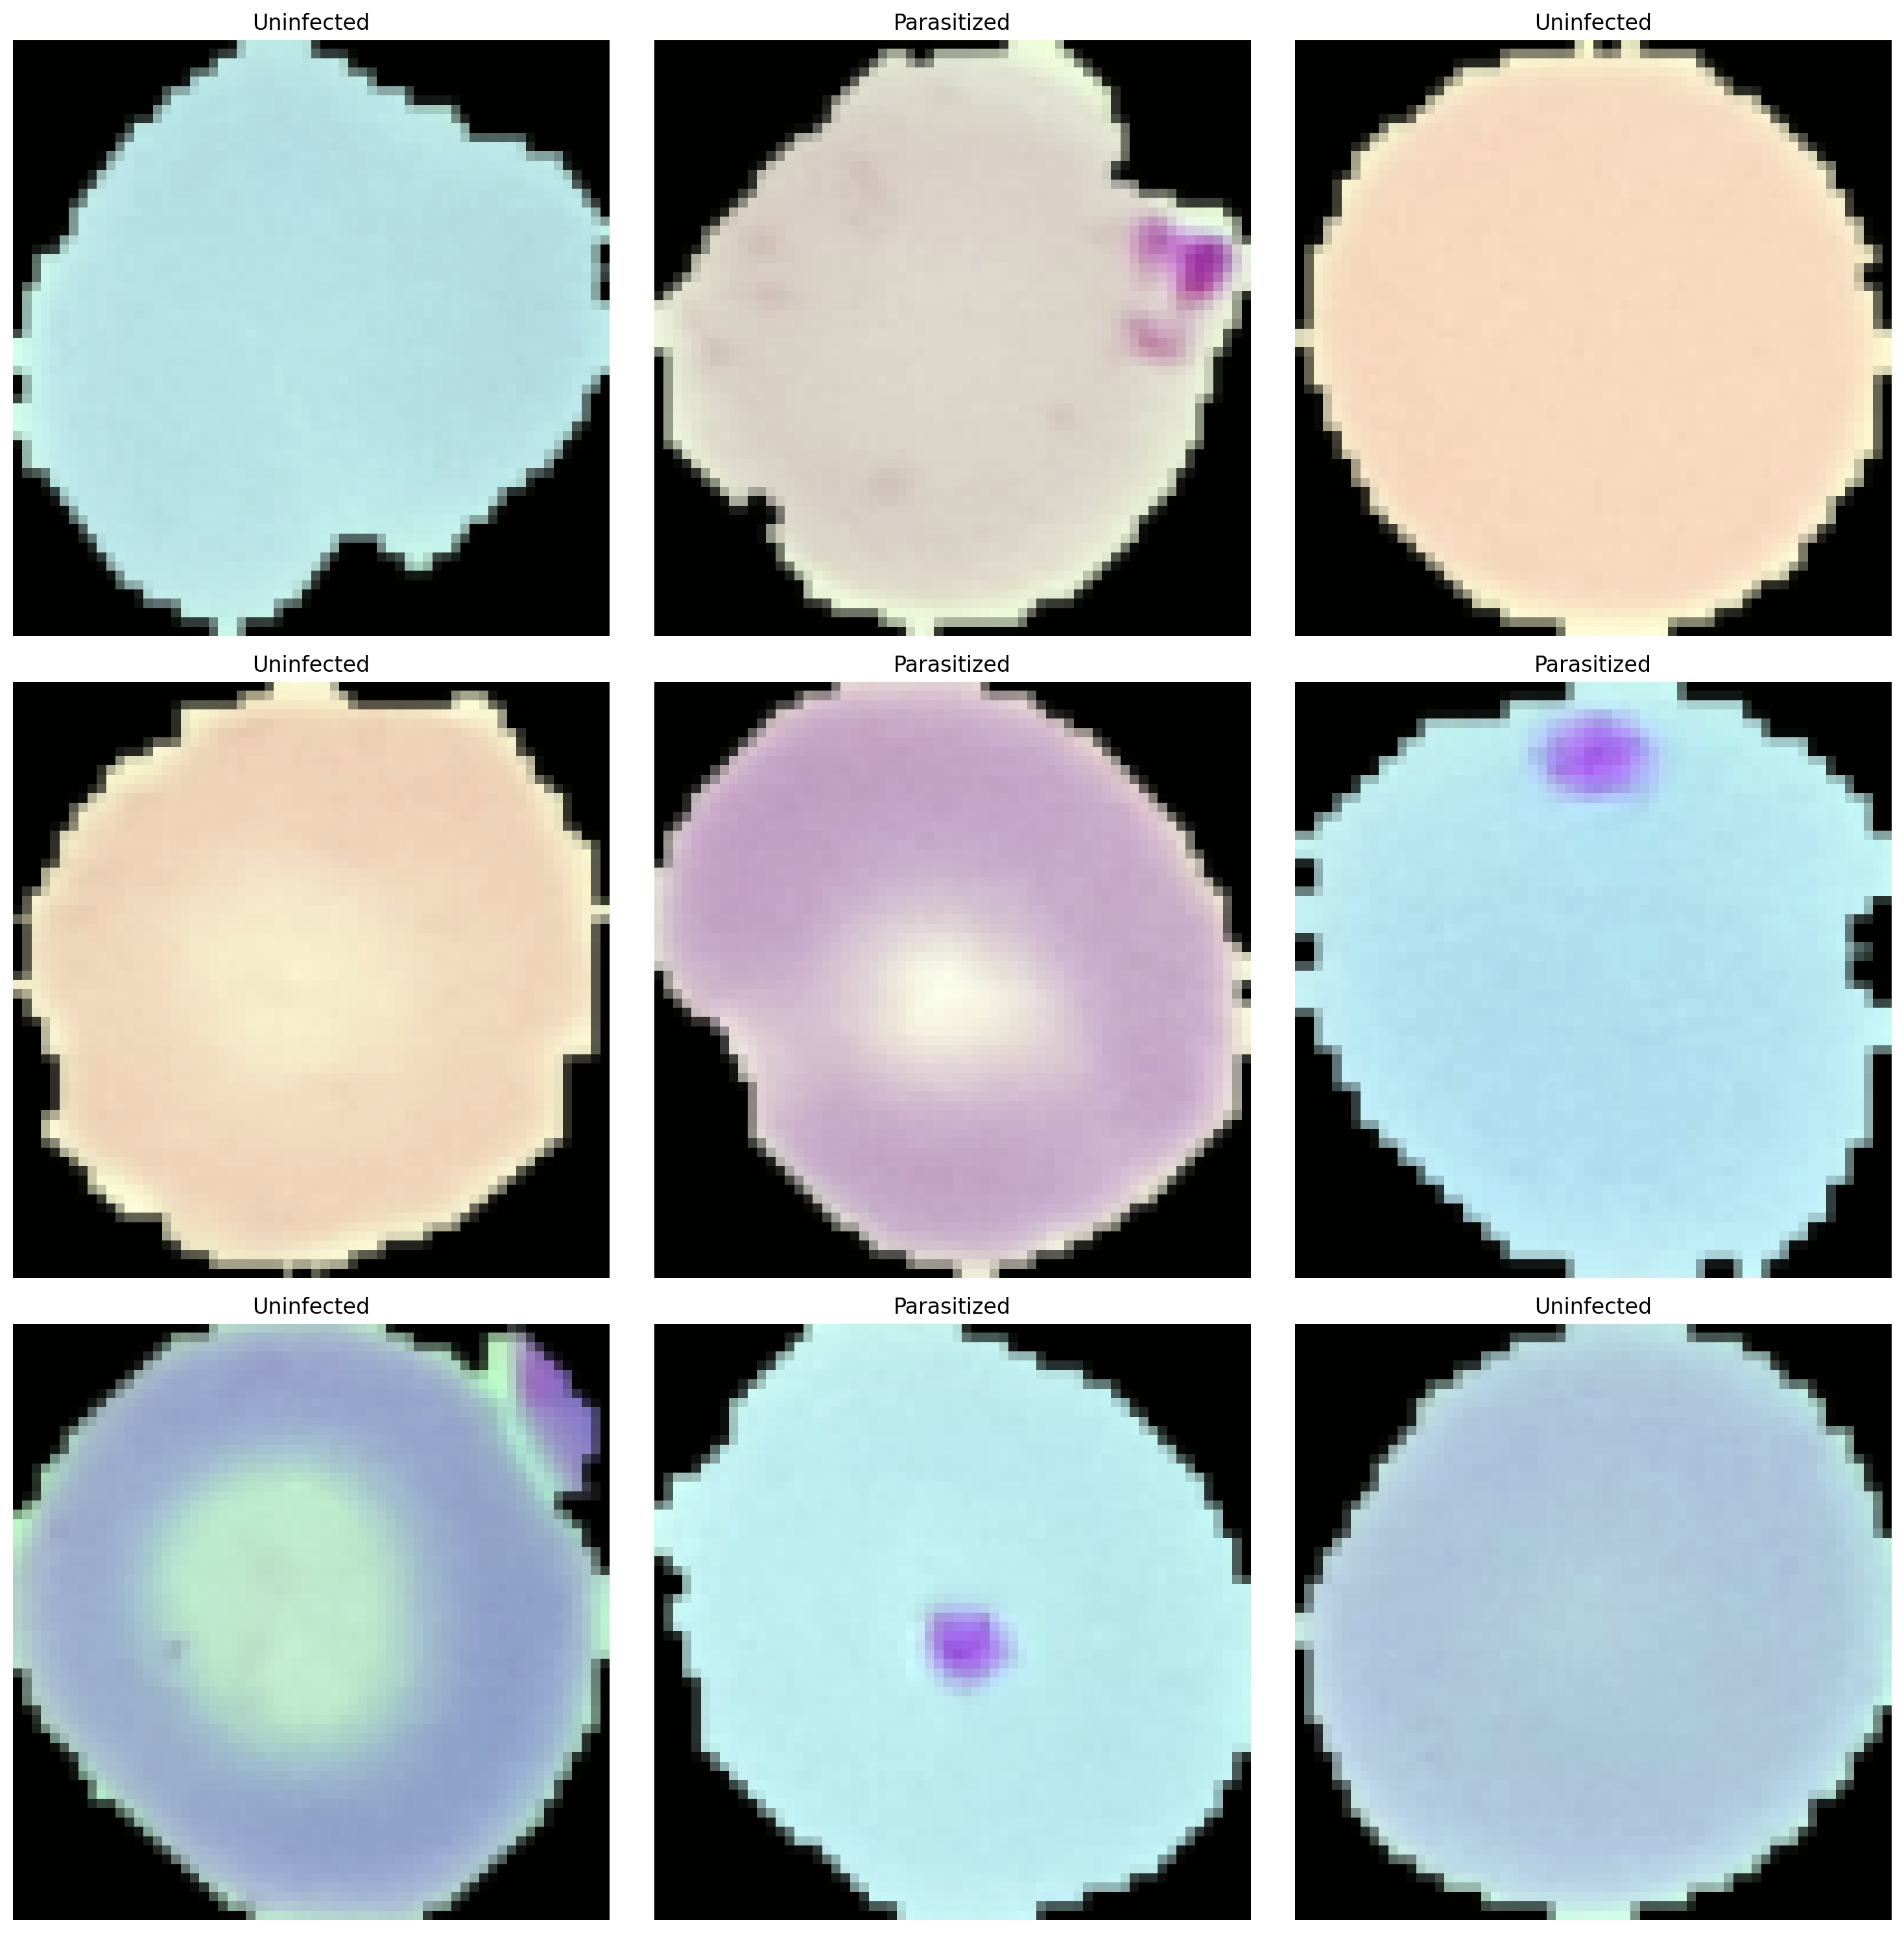

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):
    """
    Plot a grid of images with their corresponding labels.

    Args:
        images (list of tensors): A list of images to plot.
        labels (list of int): A list of corresponding labels for each image.
        classes (list of str): A list of class names.
        normalize (bool): Whether to normalize the images.
    """
    n_images = len(images)
    rows = cols = int(n_images ** 0.5)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))

    for i, ax in enumerate(axs.flatten()):
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

    fig.tight_layout()
    return fig


N_IMAGES = 10
images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train_ds.classes

fig = plot_images(shuffled_images[:N_IMAGES], shuffled_labels[:N_IMAGES], classes)
plt.show()



## Pre-existing Deep Learning Models

##### Helper Functions

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set criterion
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
def count_parameters(model):
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {parameters:,} trainable parameters')

In [ ]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    """
    Trains the model on the given data iterator.

    Args:
        model: A PyTorch model to train.
        iterator: A PyTorch data iterator that generates (x, y) tuples.
        optimizer: The PyTorch optimizer used for training.
        criterion: A PyTorch loss function to compute the loss.
        scheduler: The learning rate scheduler used for training.
            If no learning rate scheduler is used, set this to None.
        device: The device to use for evaluation (e.g., "cpu" or "cuda" or "mps").

    Returns:
        A tuple containing the epoch loss, top-1 accuracy, and top-5 accuracy
        (if applicable).
    """

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        if isinstance(model, ResNet):
            # Calculate top-1 and top-5 accuracy for ResNet models
            y_pred, _ = model(x)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        else:
            # Calculate regular accuracy for other models
            y_pred = model(x)
            acc = calculate_accuracy(y_pred, y)
            epoch_acc_1 += acc.item()

        loss = criterion(y_pred, y)

        loss.backward()

        optimizer.step()

        if scheduler:
            scheduler.step()

        epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    
    return epoch_loss, epoch_acc_1


In [ ]:
def evaluate(model, iterator, criterion, device):
    """
    Evaluates the model on the given data iterator.

    Args:
        model: A PyTorch model to evaluate.
        iterator: A PyTorch data iterator that generates (x, y) tuples.
        criterion: A PyTorch loss function to compute the loss.
        device: The device to use for evaluation (e.g., "cpu" or "cuda" or "mps").

    Returns:
        A tuple containing the epoch loss, top-1 accuracy, and top-5 accuracy
        (if applicable).
    """

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            if isinstance(model, ResNet):
                # Calculate top-1 and top-5 accuracy for ResNet models
                y_pred, _ = model(x)
                acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
                epoch_acc_1 += acc_1.item()
                epoch_acc_5 += acc_5.item()
            else:
                # Calculate regular accuracy for other models
                y_pred = model(x)
                acc = calculate_accuracy(y_pred, y)
                epoch_acc_1 += acc.item()

            loss = criterion(y_pred, y)
            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)

    return epoch_loss, epoch_acc_1


In [ ]:
def get_predictions(model, iterator):
    """
    Get predictions for a PyTorch model on a given data iterator.

    Args:
        model: The PyTorch model to get predictions for.
        iterator: The data iterator for getting predictions.

    Returns:
        Tuple: A tuple containing the predicted images, labels, and probabilities.
    """

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            if isinstance(model, ResNet):
                y_pred, _ = model(x)
            else:
                y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
def train_eval(EPOCHS, model, optimizer, scheduler):

    model = model.to(device)
    counter = 0
    patience = 8
    best_valid_loss = float('inf')
    best_epoch = 0
    best_val_acc = float('inf')
    train_accuracy = []
    valid_accuracy = []
    train_losses = []
    valid_losses = []
    
    for epoch in trange(EPOCHS, desc="EPOCHS"):
        start_time = time.monotonic()
        
        train_loss, train_acc = train(model, train_iter, optimizer, criterion, scheduler, device)
        valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_val_acc = valid_acc
            best_epoch = epoch
            filename = f"{model.__class__.__name__}_{optimizer.__class__.__name__}.pt"
            torch.save(model.state_dict(), filename)
            counter = 0
        else:
            counter += 1
            # increase patience counter on no improvement
            if counter >= patience:
                print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                break
        
        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracy.append(train_acc)
        valid_accuracy.append(valid_acc)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% |")
        print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}% |")
        
    print(f"Best epoch: {best_epoch+1}, Best validation accuracy: {best_val_acc}, Best validation loss: {best_valid_loss}")
    
    return train_accuracy, valid_accuracy, train_losses, valid_losses


In [ ]:
test = pd.read_csv('/Users/ademola/Documents/MMU-DS/DL/Datasets/malaria_cell_images/ground_truth.csv')
y_test = np.array(test.drop(['Title'], axis=1))

In [ ]:
def plot_roc_curve(y_test, probs, class_labels, NN):
    """
    Plots the ROC curves for a given set of true labels and predicted probabilities for each class.
    
    Args:
    y_test (np.array): True class labels of shape (n_samples, n_classes).
    probs (np.array): Predicted probabilities of shape (n_samples, n_classes).
    class_labels (list): List of class labels.
    """
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    colors = ['darkorange', 'green', 'blue', 'red', 'purple']
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:.2f})')
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2, linestyle=':',
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})')
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, linestyle=':',
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{NN} ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(f"{NN}_roc_curve.png", bbox_inches='tight')
    plt.show()


In [ ]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Plot confusion matrix using matplotlib and sklearn metrics.

    Args:
    - y_true (np.ndarray): true labels
    - y_pred (np.ndarray): predicted labels

    Returns:
    - None
    """
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    class_names = unique_labels(y_true, y_pred)

    # Plot raw confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Plot normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, normalize="true", cmap=plt.cm.Blues)

    # Calculate true positives, false positives, and false negatives
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)

    print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))


In [ ]:
def plot_loss_acc(NN, train_losses, valid_losses, train_acc, valid_acc):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(f"Loss and Accuracy plots for {NN}")

    axs[0].plot(train_losses, label='Training loss')
    axs[0].plot(valid_losses, label='Validation loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(frameon=False)

    axs[1].plot(train_acc, label='Training Accuracy')
    axs[1].plot(valid_acc, label='Validation Accuracy')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(frameon=False)

    plt.savefig(f"{NN}_plot.png", bbox_inches='tight')
    plt.show()

### ResNet50

In [ ]:
pretrained_model = models.resnet50(weights="IMAGENET1K_V2")
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = 2

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
r50_model = ResNet(resnet50_config, OUTPUT_DIM)
r50_model.load_state_dict(pretrained_model.state_dict())

count_parameters(r50_model)

The model has 23,512,130 trainable parameters


In [ ]:
summary(r50_model, input_size=(batch_size, 3, 64, 64), col_names=("input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                ))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape
ResNet                                   [64, 3, 64, 64]           [64, 2]                   --                             --                   --
├─Conv2d: 1-1                            [64, 3, 64, 64]           [64, 64, 32, 32]          9,408                       0.04%                   [7, 7]
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          [64, 64, 32, 32]          128                         0.00%                   --
├─ReLU: 1-3                              [64, 64, 32, 32]          [64, 64, 32, 32]          --                             --                   --
├─MaxPool2d: 1-4                         [64, 64, 32, 32]          [64, 64, 16, 16]          --                             --                   3
├─Sequential: 1-5                        [64, 64, 16, 16]          [64, 256, 16, 16]         --    

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': r50_model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': r50_model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': r50_model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': r50_model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': r50_model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': r50_model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': r50_model.fc.parameters()}
         ]

adam_optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
def scheduler(epochs, opt):
    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in opt.param_groups]
    scheduler = lr_scheduler.OneCycleLR(opt, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

    return scheduler

In [ ]:
scheduler = scheduler(100, adam_optimizer)

In [ ]:
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, r50_model, adam_optimizer, scheduler)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 37s
	Train Loss: 0.397 | Train Acc:  83.04% |
	Valid Loss: 0.195 | Valid Acc:  93.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 38s
	Train Loss: 0.147 | Train Acc:  94.63% |
	Valid Loss: 0.137 | Valid Acc:  95.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 36s
	Train Loss: 0.086 | Train Acc:  96.84% |
	Valid Loss: 0.126 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 37s
	Train Loss: 0.046 | Train Acc:  98.24% |
	Valid Loss: 0.145 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 36s
	Train Loss: 0.026 | Train Acc:  99.12% |
	Valid Loss: 0.162 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 36s
	Train Loss: 0.022 | Train Acc:  99.30% |
	Valid Loss: 0.155 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 36s
	Train Loss: 0.025 | Train Acc:  99.15% |
	Valid Loss: 0.175 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 36s
	Train Loss: 0.022 | Train Acc:  99.24% |
	Valid Loss: 0.181 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 35s
	Train Loss: 0.021 | Train Acc:  99.32% |
	Valid Loss: 0.161 | Valid Acc:  96.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 36s
	Train Loss: 0.020 | Train Acc:  99.29% |
	Valid Loss: 0.154 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 3, Best validation accuracy: 0.9589389534883721, Best validation loss: 0.12604339676367682


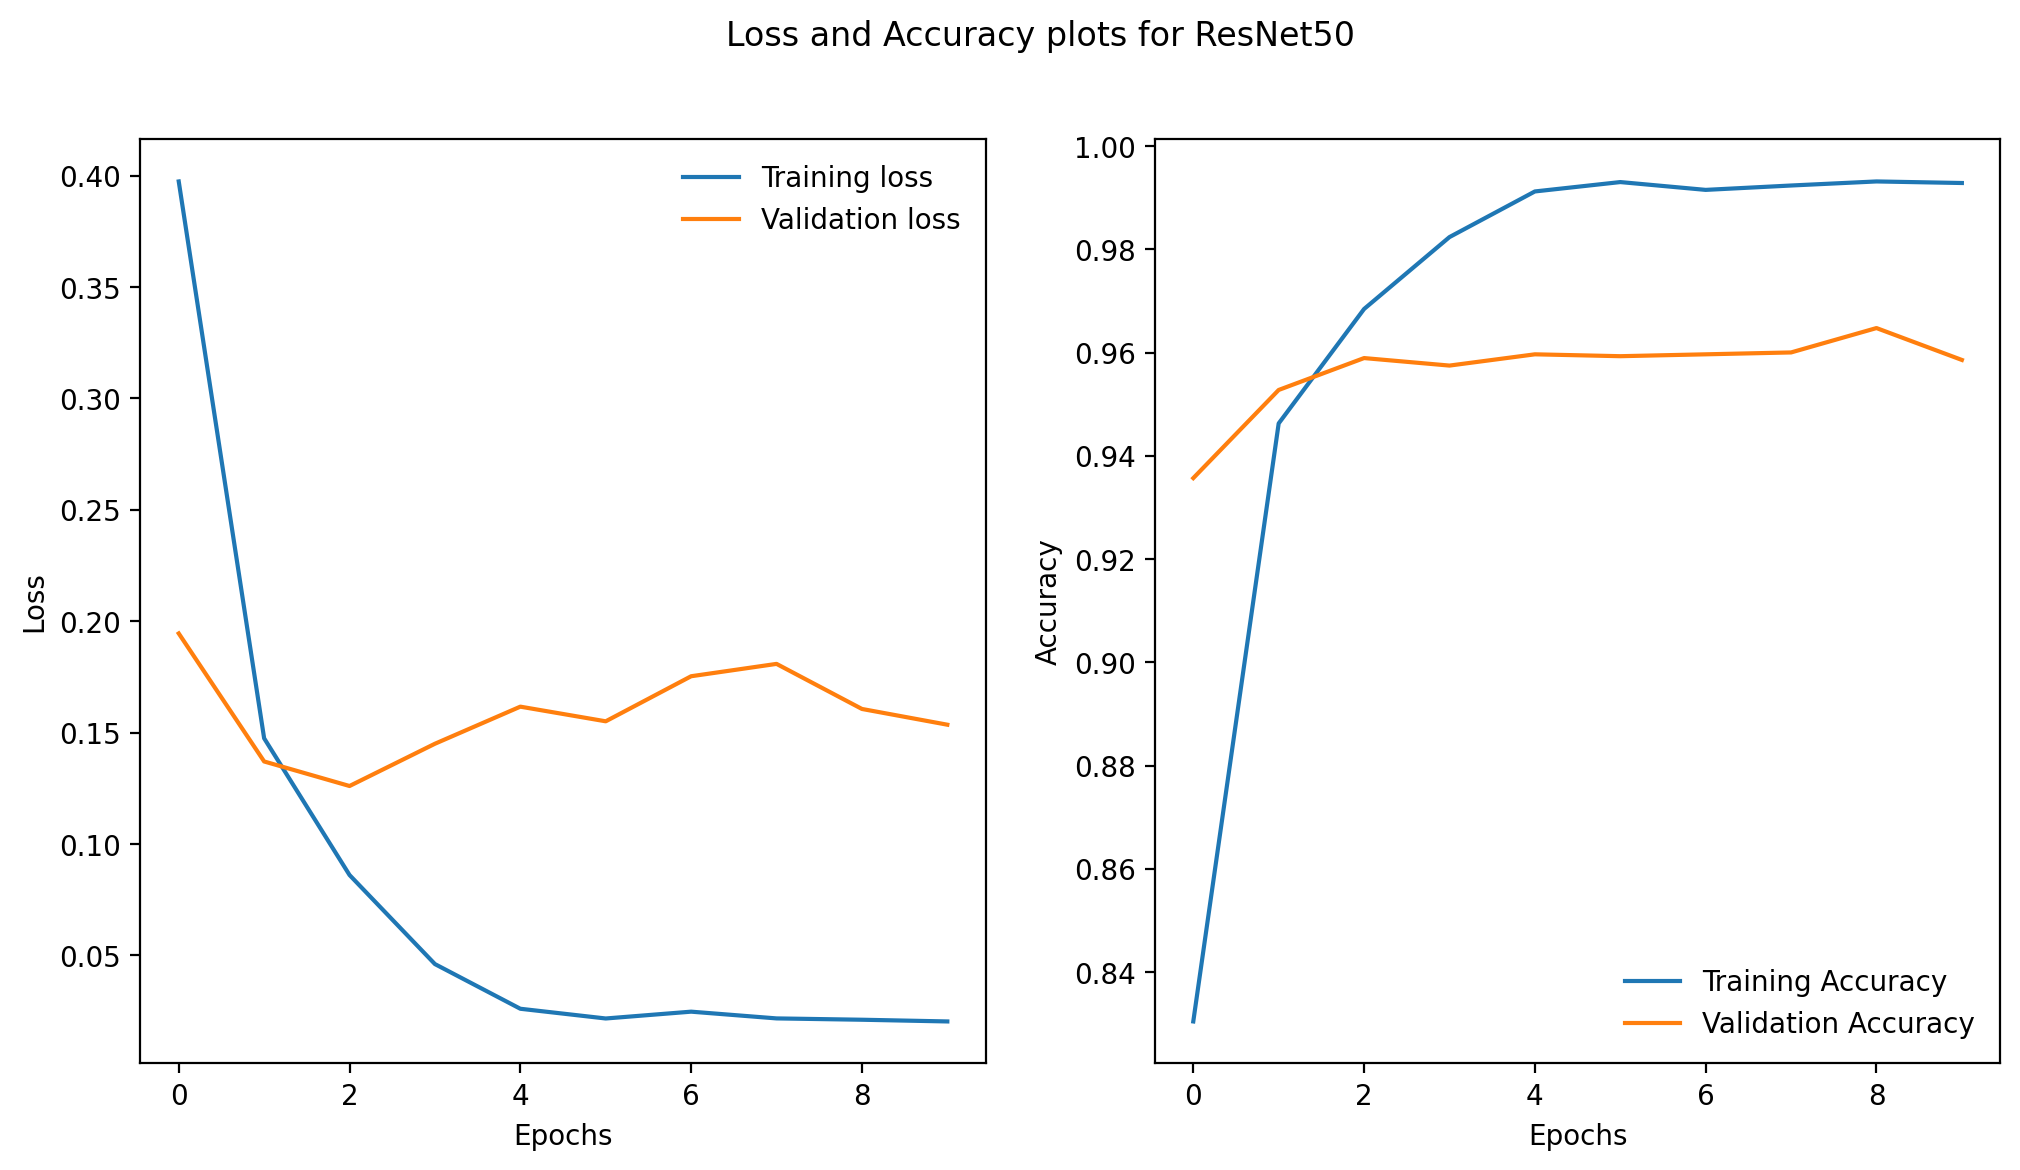

In [ ]:
plot_loss_acc('ResNet50', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

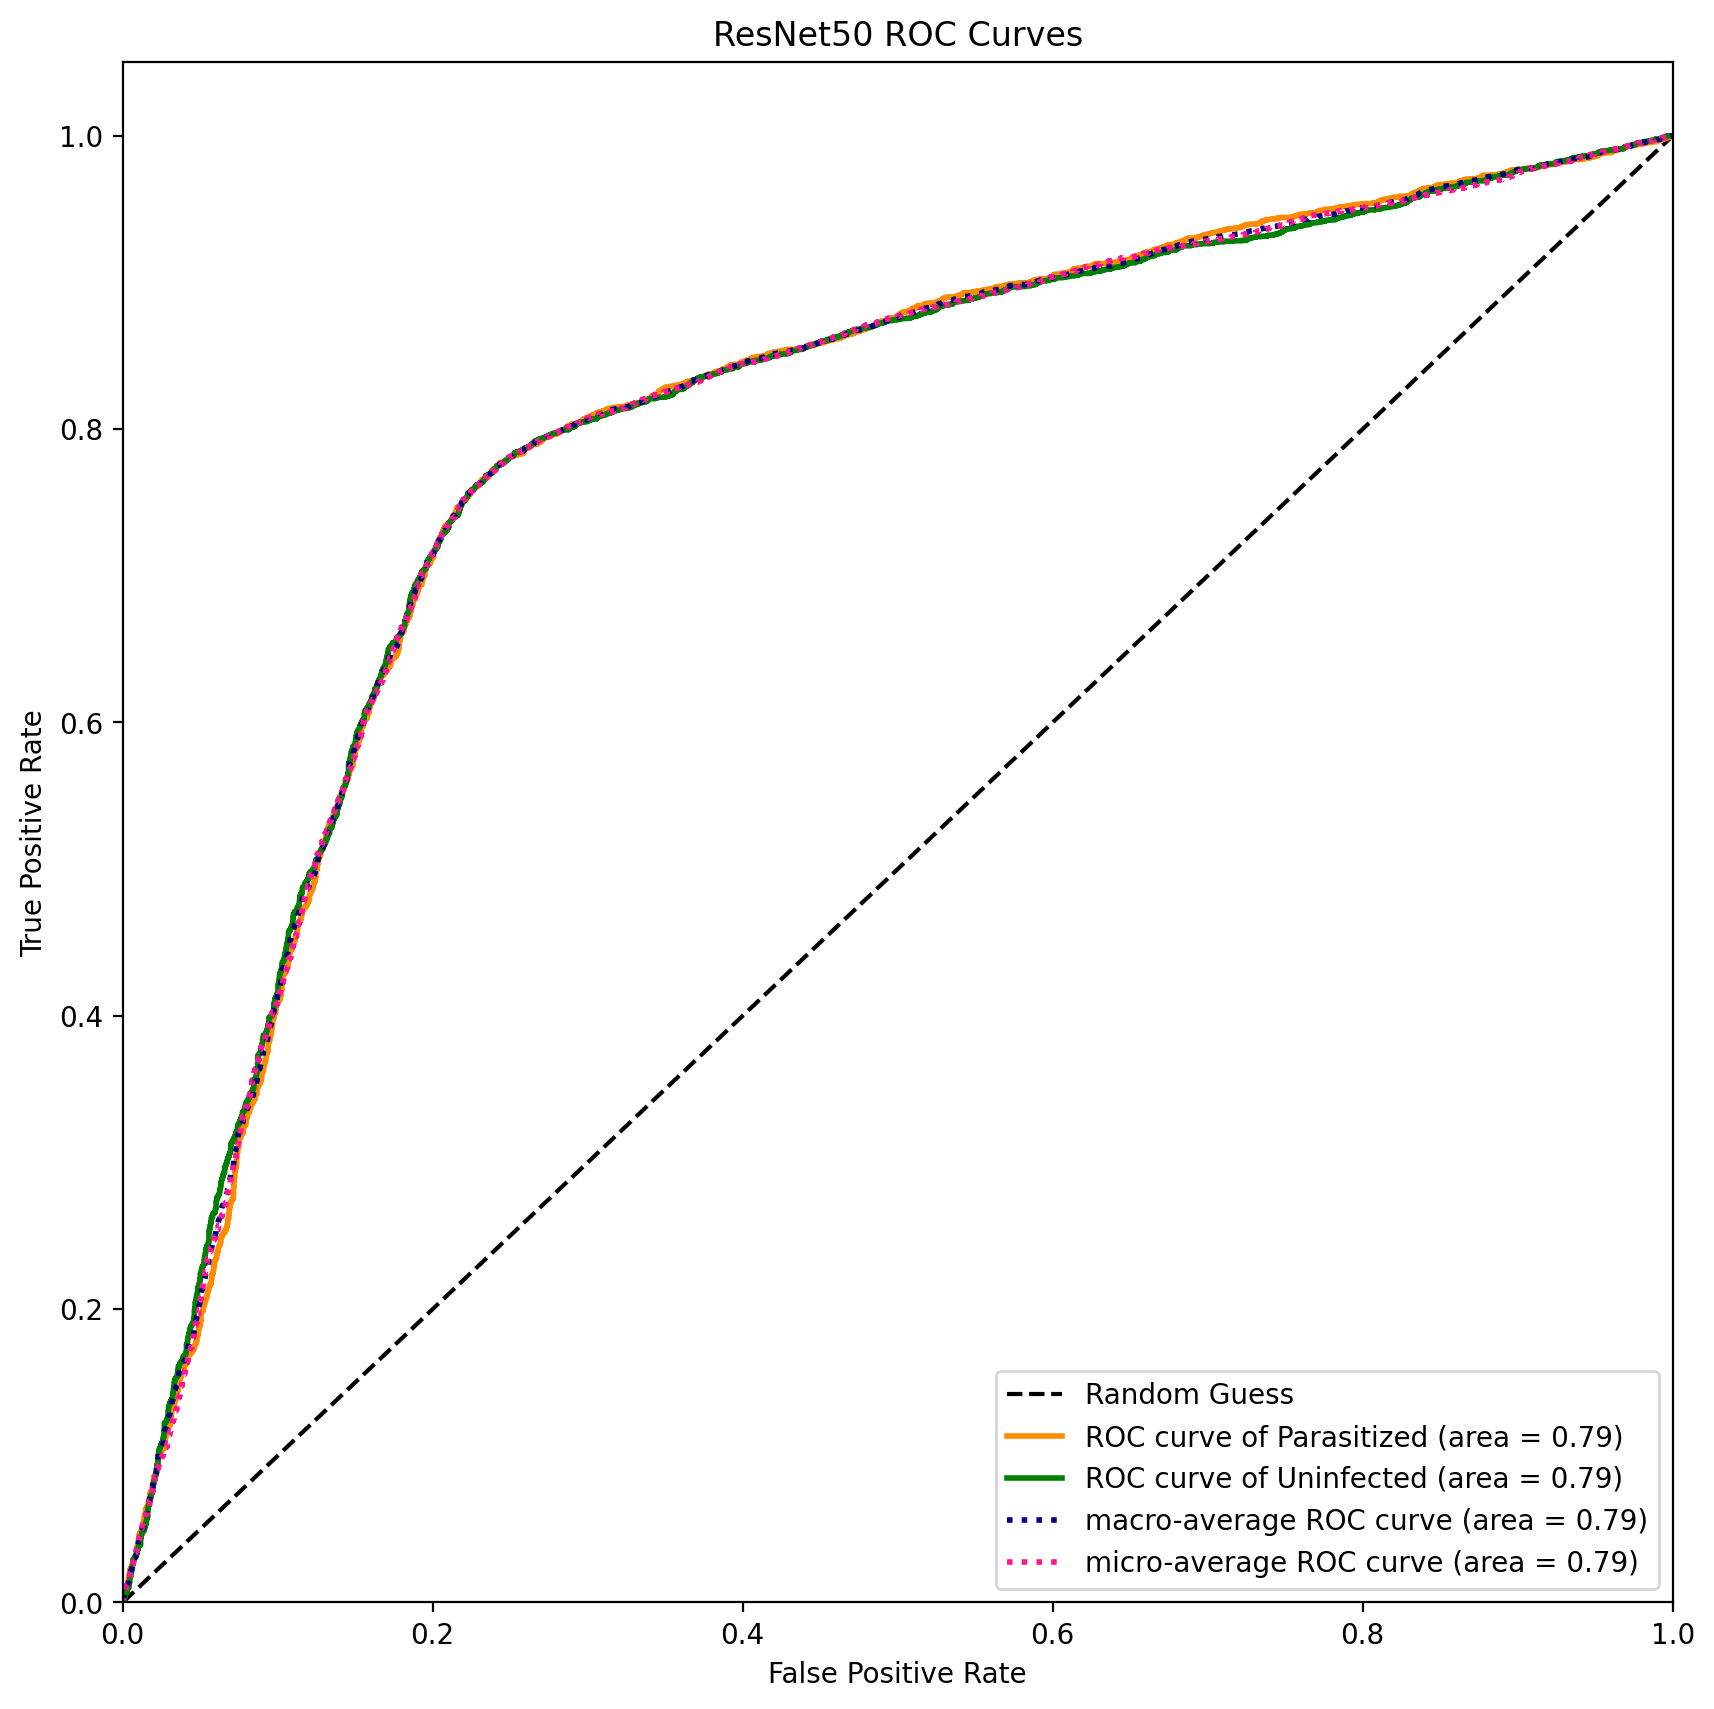

In [ ]:
r50_model.load_state_dict(torch.load('ResNet_Adam.pt'))
r50_model.to(device)
images, labels, probs = get_predictions(r50_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "ResNet50")

              precision    recall  f1-score   support

 Parasitized       0.77      0.76      0.76      4133
  Uninfected       0.76      0.77      0.77      4133

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266



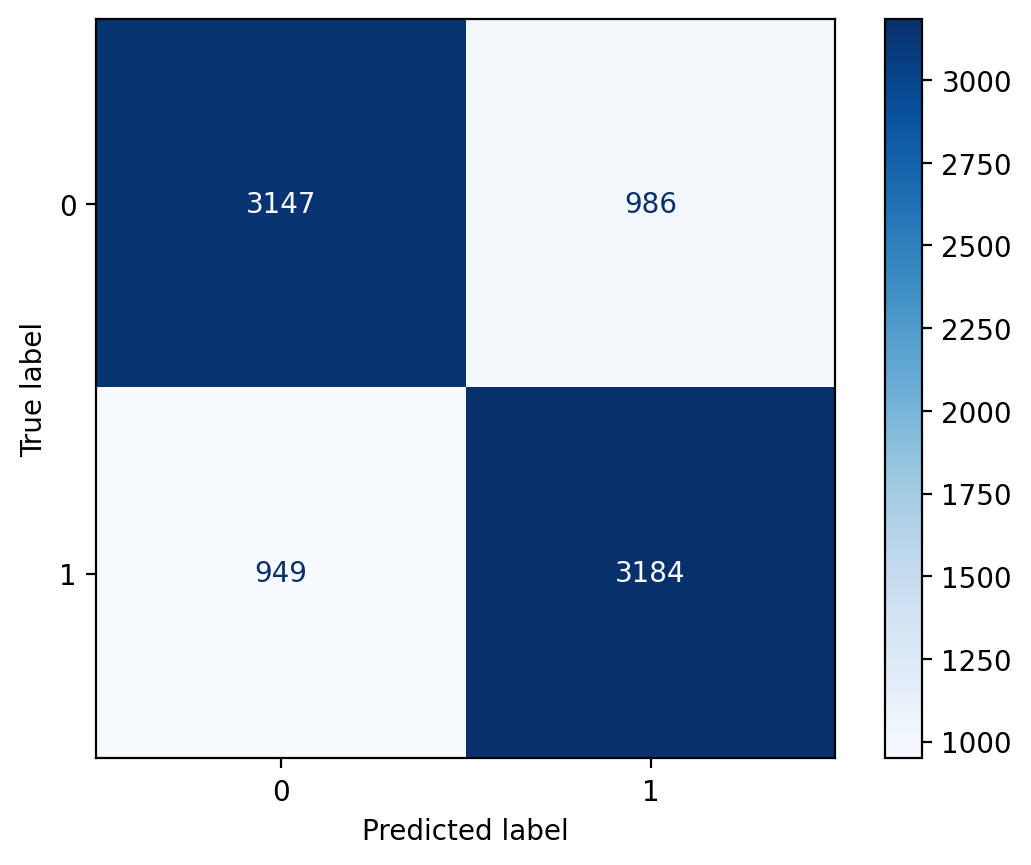

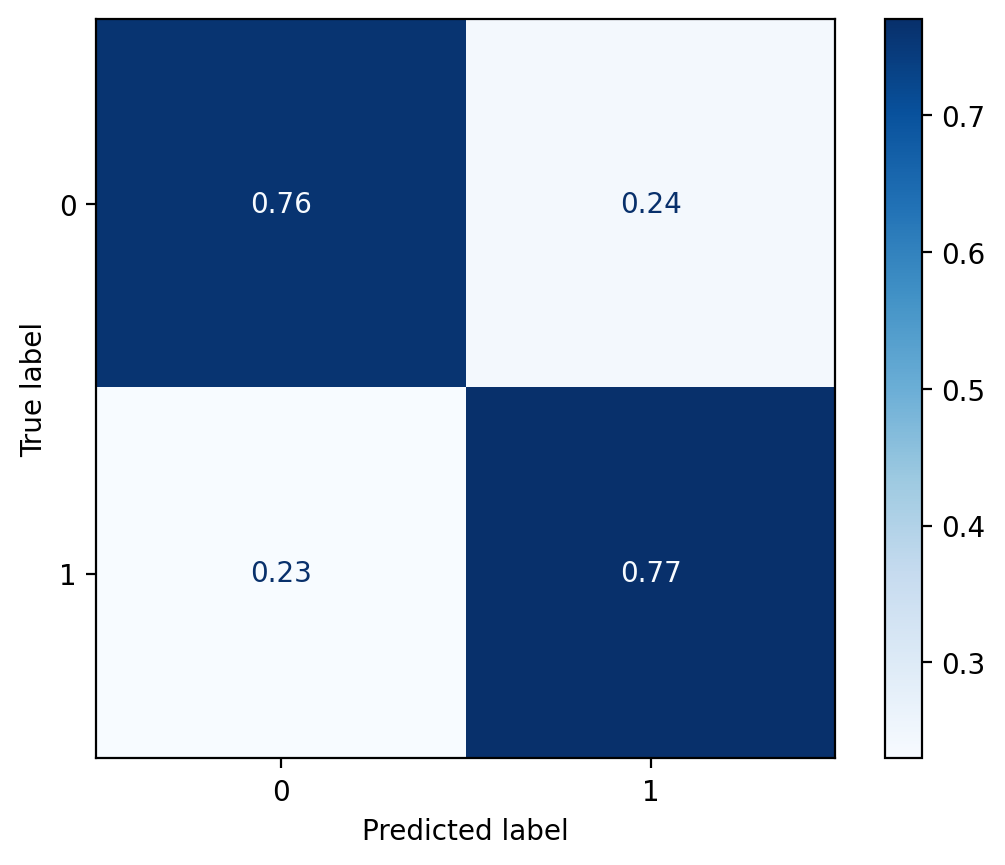

In [ ]:
plot_confusion_matrix(y_test, probs)

#### ResNet w/ SGD

In [ ]:
pretrained_model = models.resnet50(weights="IMAGENET1K_V2")
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = 2

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
r50_model = ResNet(resnet50_config, OUTPUT_DIM)
r50_model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': r50_model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': r50_model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': r50_model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': r50_model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': r50_model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': r50_model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': r50_model.fc.parameters()}
         ]

sgd_optimizer = optim.SGD(params, lr=FOUND_LR)

In [ ]:
def scheduler(epochs, opt):
    STEPS_PER_EPOCH = len(train_iter)
    TOTAL_STEPS = epochs * STEPS_PER_EPOCH

    MAX_LRS = [p['lr'] for p in opt.param_groups]
    scheduler = lr_scheduler.OneCycleLR(opt, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

    return scheduler

In [ ]:
scheduler = scheduler(100, sgd_optimizer)

In [ ]:
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, r50_model, sgd_optimizer, scheduler)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 46s
	Train Loss: 0.625 | Train Acc:  67.19% |
	Valid Loss: 0.557 | Valid Acc:  77.91% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 2m 54s
	Train Loss: 0.496 | Train Acc:  81.33% |
	Valid Loss: 0.441 | Valid Acc:  84.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 2m 51s
	Train Loss: 0.405 | Train Acc:  85.35% |
	Valid Loss: 0.361 | Valid Acc:  87.14% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 2m 52s
	Train Loss: 0.337 | Train Acc:  87.78% |
	Valid Loss: 0.308 | Valid Acc:  89.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 2m 49s
	Train Loss: 0.282 | Train Acc:  89.84% |
	Valid Loss: 0.257 | Valid Acc:  90.99% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 2m 59s
	Train Loss: 0.238 | Train Acc:  91.41% |
	Valid Loss: 0.226 | Valid Acc:  92.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 3m 14s
	Train Loss: 0.204 | Train Acc:  92.59% |
	Valid Loss: 0.201 | Valid Acc:  93.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 2m 59s
	Train Loss: 0.180 | Train Acc:  93.74% |
	Valid Loss: 0.186 | Valid Acc:  93.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 2m 51s
	Train Loss: 0.162 | Train Acc:  94.14% |
	Valid Loss: 0.170 | Valid Acc:  93.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 2m 49s
	Train Loss: 0.144 | Train Acc:  94.94% |
	Valid Loss: 0.160 | Valid Acc:  94.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 2m 51s
	Train Loss: 0.130 | Train Acc:  95.26% |
	Valid Loss: 0.157 | Valid Acc:  94.40% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 2m 57s
	Train Loss: 0.114 | Train Acc:  96.05% |
	Valid Loss: 0.147 | Valid Acc:  94.69% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 2m 28s
	Train Loss: 0.104 | Train Acc:  96.15% |
	Valid Loss: 0.146 | Valid Acc:  94.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 35s
	Train Loss: 0.095 | Train Acc:  96.49% |
	Valid Loss: 0.142 | Valid Acc:  95.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 35s
	Train Loss: 0.086 | Train Acc:  96.85% |
	Valid Loss: 0.142 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 1m 41s
	Train Loss: 0.077 | Train Acc:  97.27% |
	Valid Loss: 0.136 | Valid Acc:  95.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 1m 34s
	Train Loss: 0.068 | Train Acc:  97.50% |
	Valid Loss: 0.140 | Valid Acc:  95.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 32s
	Train Loss: 0.059 | Train Acc:  97.84% |
	Valid Loss: 0.141 | Valid Acc:  95.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 37s
	Train Loss: 0.053 | Train Acc:  98.14% |
	Valid Loss: 0.142 | Valid Acc:  95.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 44s
	Train Loss: 0.046 | Train Acc:  98.46% |
	Valid Loss: 0.144 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 2m 28s
	Train Loss: 0.043 | Train Acc:  98.53% |
	Valid Loss: 0.143 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 35s
	Train Loss: 0.036 | Train Acc:  98.88% |
	Valid Loss: 0.153 | Valid Acc:  95.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 35s
	Train Loss: 0.033 | Train Acc:  98.98% |
	Valid Loss: 0.149 | Valid Acc:  95.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 16, Best validation accuracy: 0.9527616279069767, Best validation loss: 0.1362495970760667


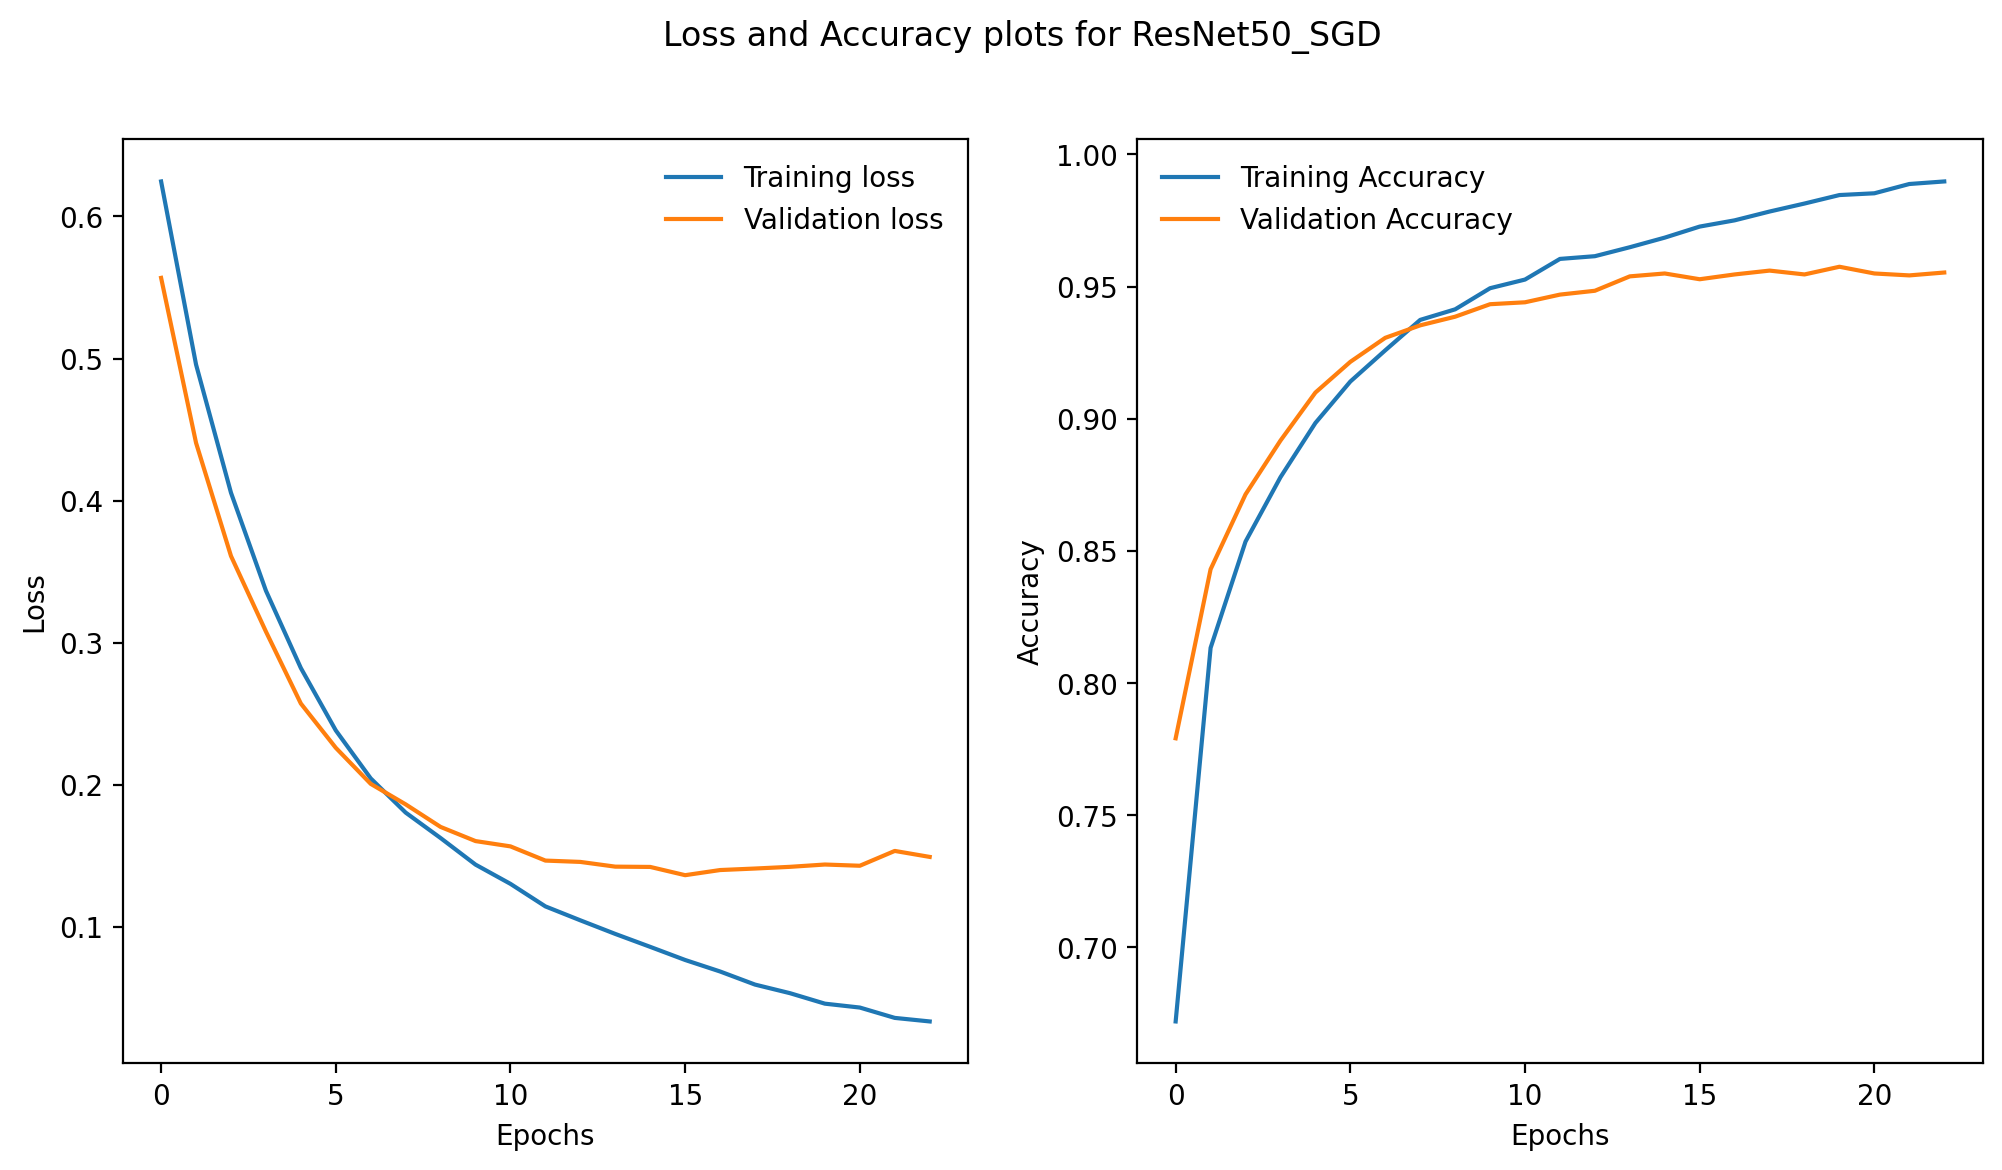

In [ ]:
plot_loss_acc('ResNet50_SGD', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

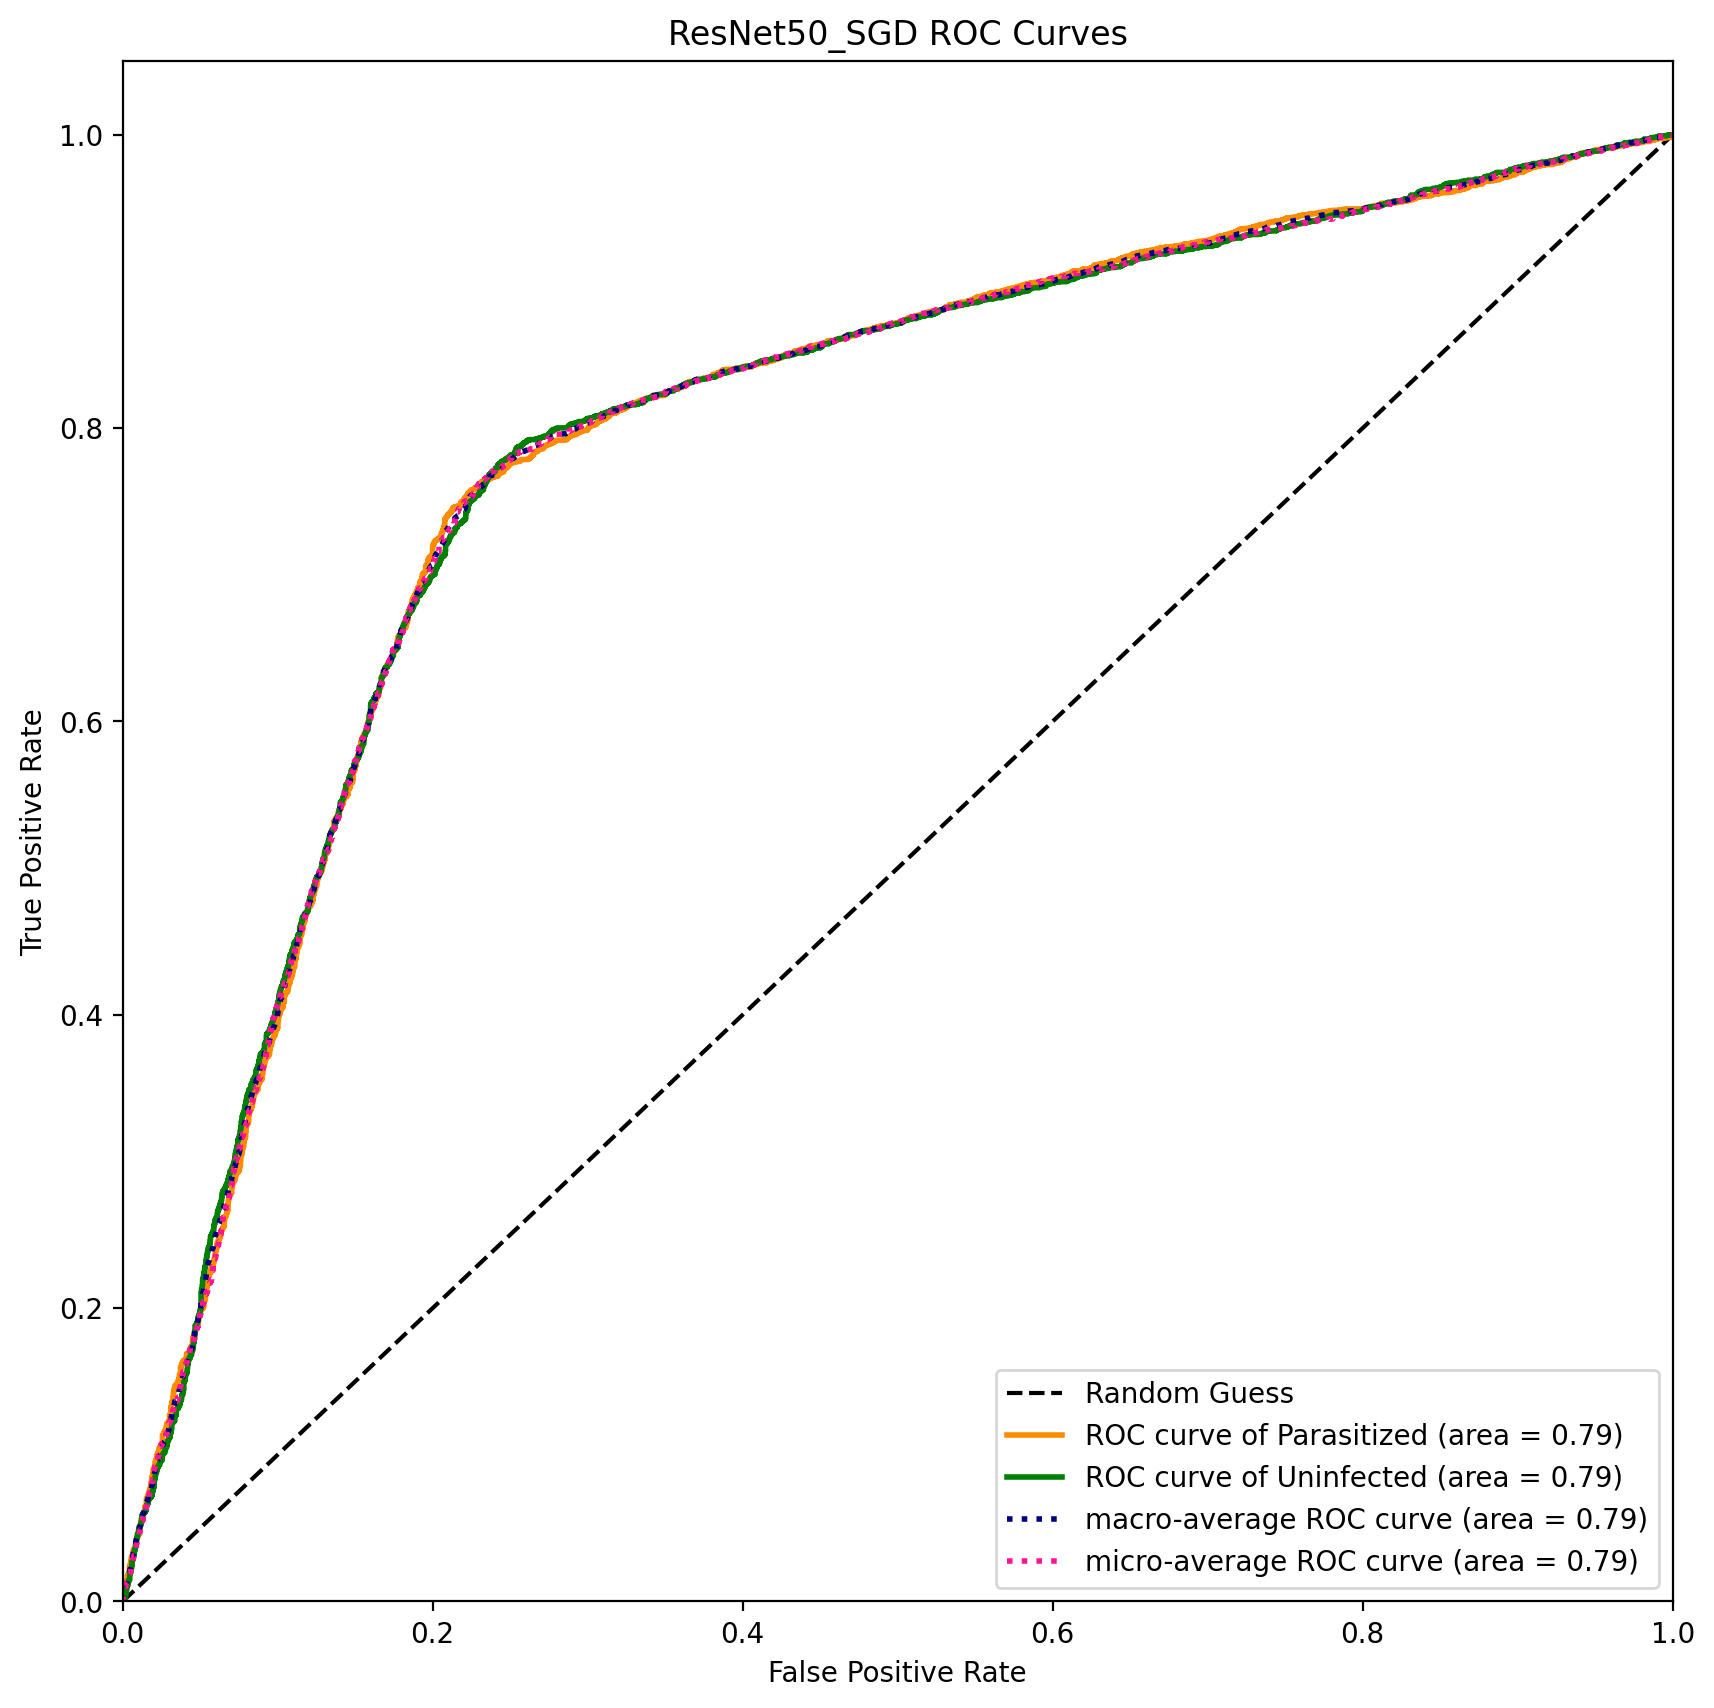

In [ ]:
r50_model.load_state_dict(torch.load('ResNet_SGD.pt'))
r50_model.to(device)
images, labels, probs = get_predictions(r50_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "ResNet50_SGD")

              precision    recall  f1-score   support

 Parasitized       0.77      0.76      0.76      4133
  Uninfected       0.76      0.77      0.77      4133

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266



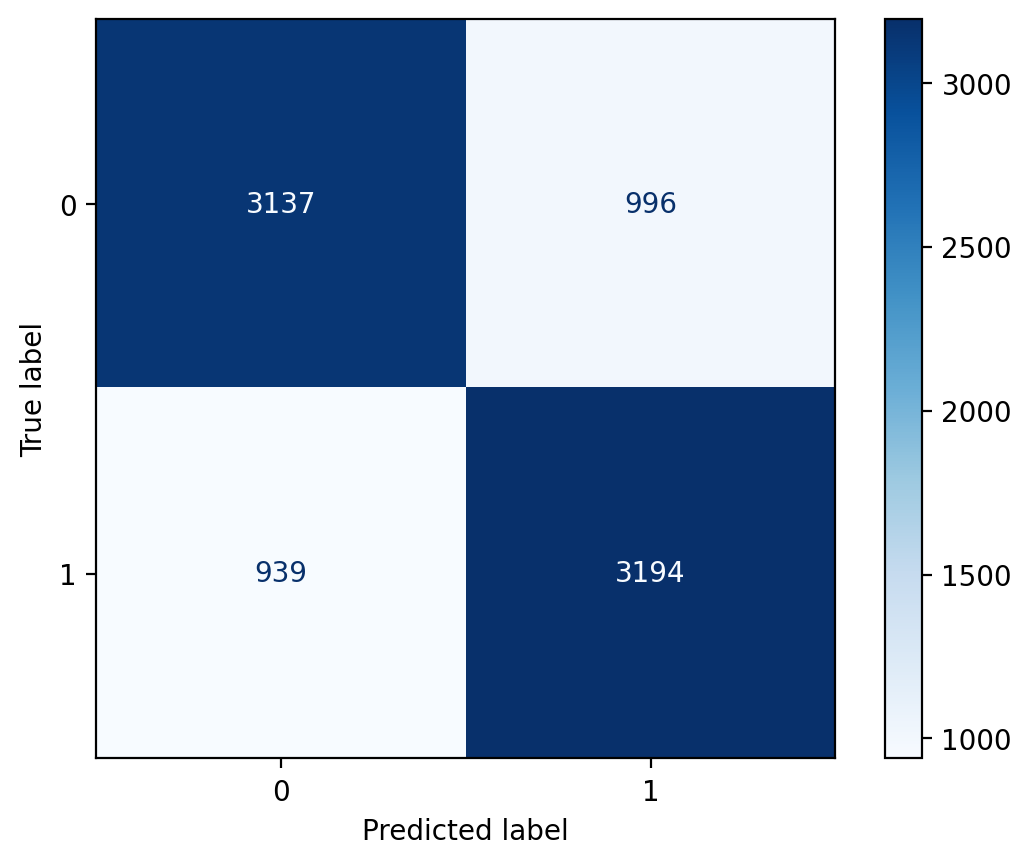

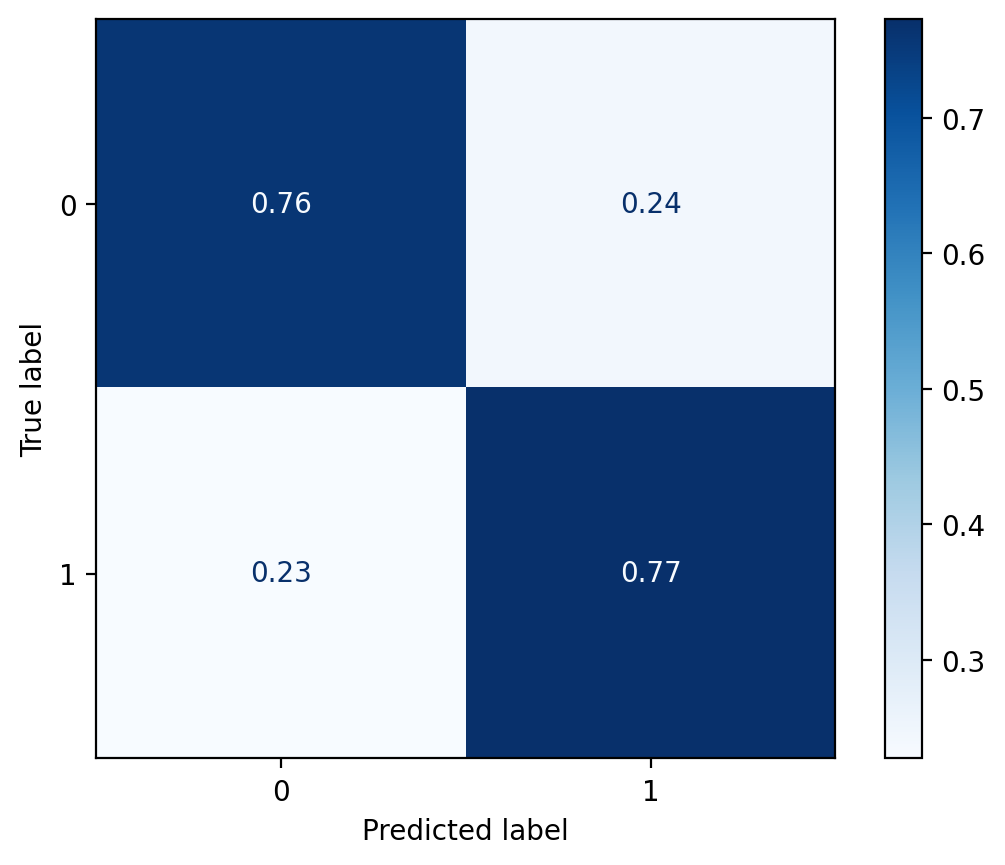

In [ ]:
plot_confusion_matrix(y_test, probs)

### VGG

In [ ]:
vgg11_layers = get_vgg_layers(vgg_configs["11"], batch_norm=True)

NUM_CLASSES = 2
IMG_SIZE = 64

vgg_model = VGG(vgg11_layers, IMG_SIZE, NUM_CLASSES)

count_parameters(vgg_model)

The model has 34,408,194 trainable parameters


In [ ]:
summary(vgg_model, input_size=(batch_size, 3, 64, 64), col_names=("input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                ))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape
VGG                                      [64, 3, 64, 64]           [64, 2]                   --                             --                   --
├─Sequential: 1-1                        [64, 3, 64, 64]           [64, 512, 2, 2]           --                             --                   --
│    └─Conv2d: 2-1                       [64, 3, 64, 64]           [64, 64, 64, 64]          1,792                       0.01%                   [3, 3]
│    └─BatchNorm2d: 2-2                  [64, 64, 64, 64]          [64, 64, 64, 64]          128                         0.00%                   --
│    └─ReLU: 2-3                         [64, 64, 64, 64]          [64, 64, 64, 64]          --                             --                   --
│    └─MaxPool2d: 2-4                    [64, 64, 64, 64]          [64, 64, 32, 32]          --   

In [ ]:
FOUND_LR = 1e-3

params = [
    {'params': vgg_model.features.parameters(), 'lr': FOUND_LR / 10},
    {'params': vgg_model.classifier.parameters()}
]

adam_optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, vgg_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 44s
	Train Loss: 0.484 | Train Acc:  83.47% |
	Valid Loss: 0.148 | Valid Acc:  94.80% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 2m 48s
	Train Loss: 0.145 | Train Acc:  95.52% |
	Valid Loss: 0.133 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 2m 49s
	Train Loss: 0.127 | Train Acc:  96.02% |
	Valid Loss: 0.130 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 2m 44s
	Train Loss: 0.122 | Train Acc:  96.08% |
	Valid Loss: 0.147 | Valid Acc:  95.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 3m 8s
	Train Loss: 0.111 | Train Acc:  96.45% |
	Valid Loss: 0.124 | Valid Acc:  96.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 2m 34s
	Train Loss: 0.103 | Train Acc:  96.64% |
	Valid Loss: 0.145 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 2m 28s
	Train Loss: 0.124 | Train Acc:  96.22% |
	Valid Loss: 0.268 | Valid Acc:  96.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 2m 44s
	Train Loss: 0.108 | Train Acc:  96.69% |
	Valid Loss: 0.162 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 2m 42s
	Train Loss: 0.074 | Train Acc:  97.56% |
	Valid Loss: 0.218 | Valid Acc:  95.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 2m 33s
	Train Loss: 0.088 | Train Acc:  97.34% |
	Valid Loss: 0.289 | Valid Acc:  96.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 2m 36s
	Train Loss: 0.053 | Train Acc:  98.26% |
	Valid Loss: 0.261 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 2m 42s
	Train Loss: 0.037 | Train Acc:  98.63% |
	Valid Loss: 0.386 | Valid Acc:  96.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 5, Best validation accuracy: 0.9625726744186046, Best validation loss: 0.12350597879091321


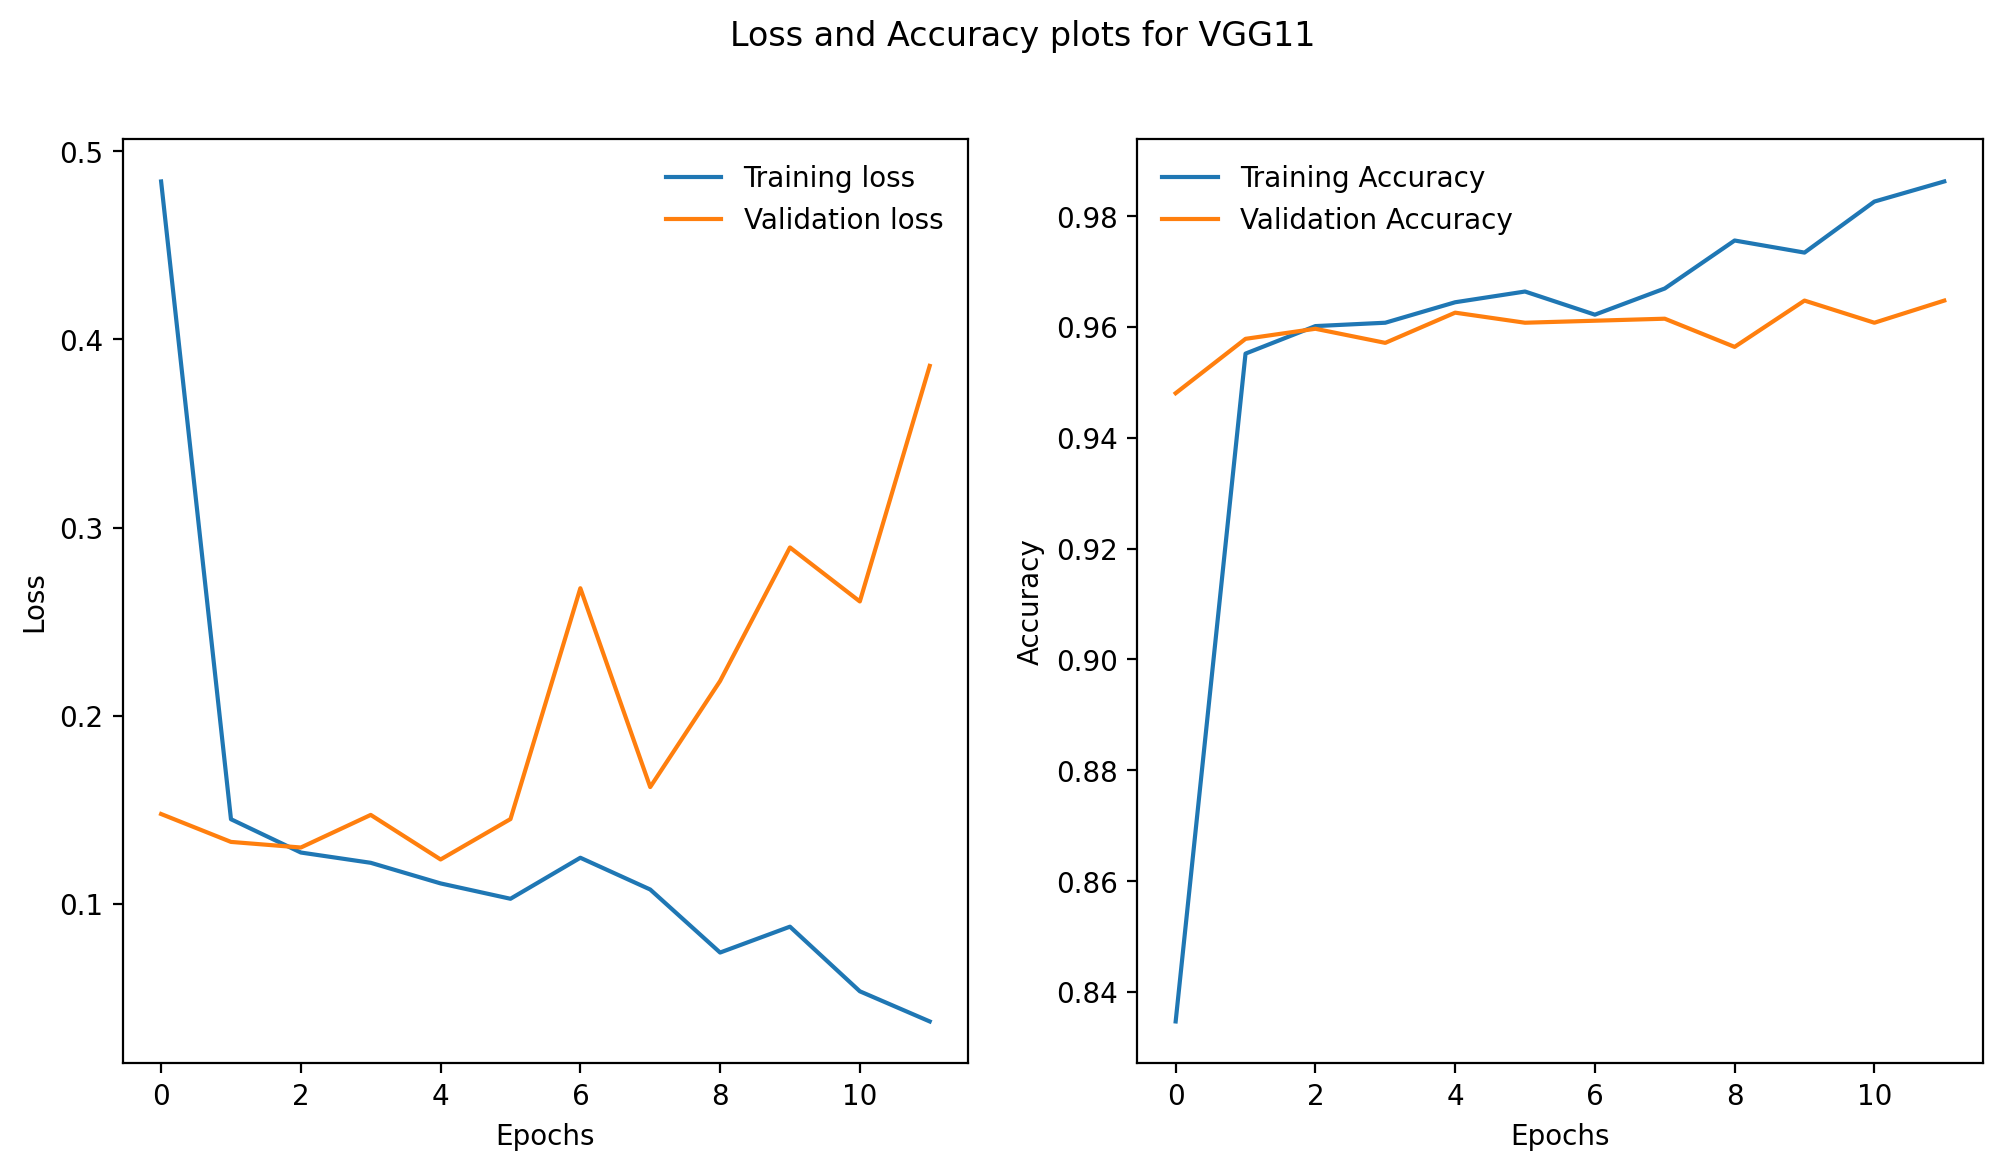

In [ ]:
plot_loss_acc('VGG11', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

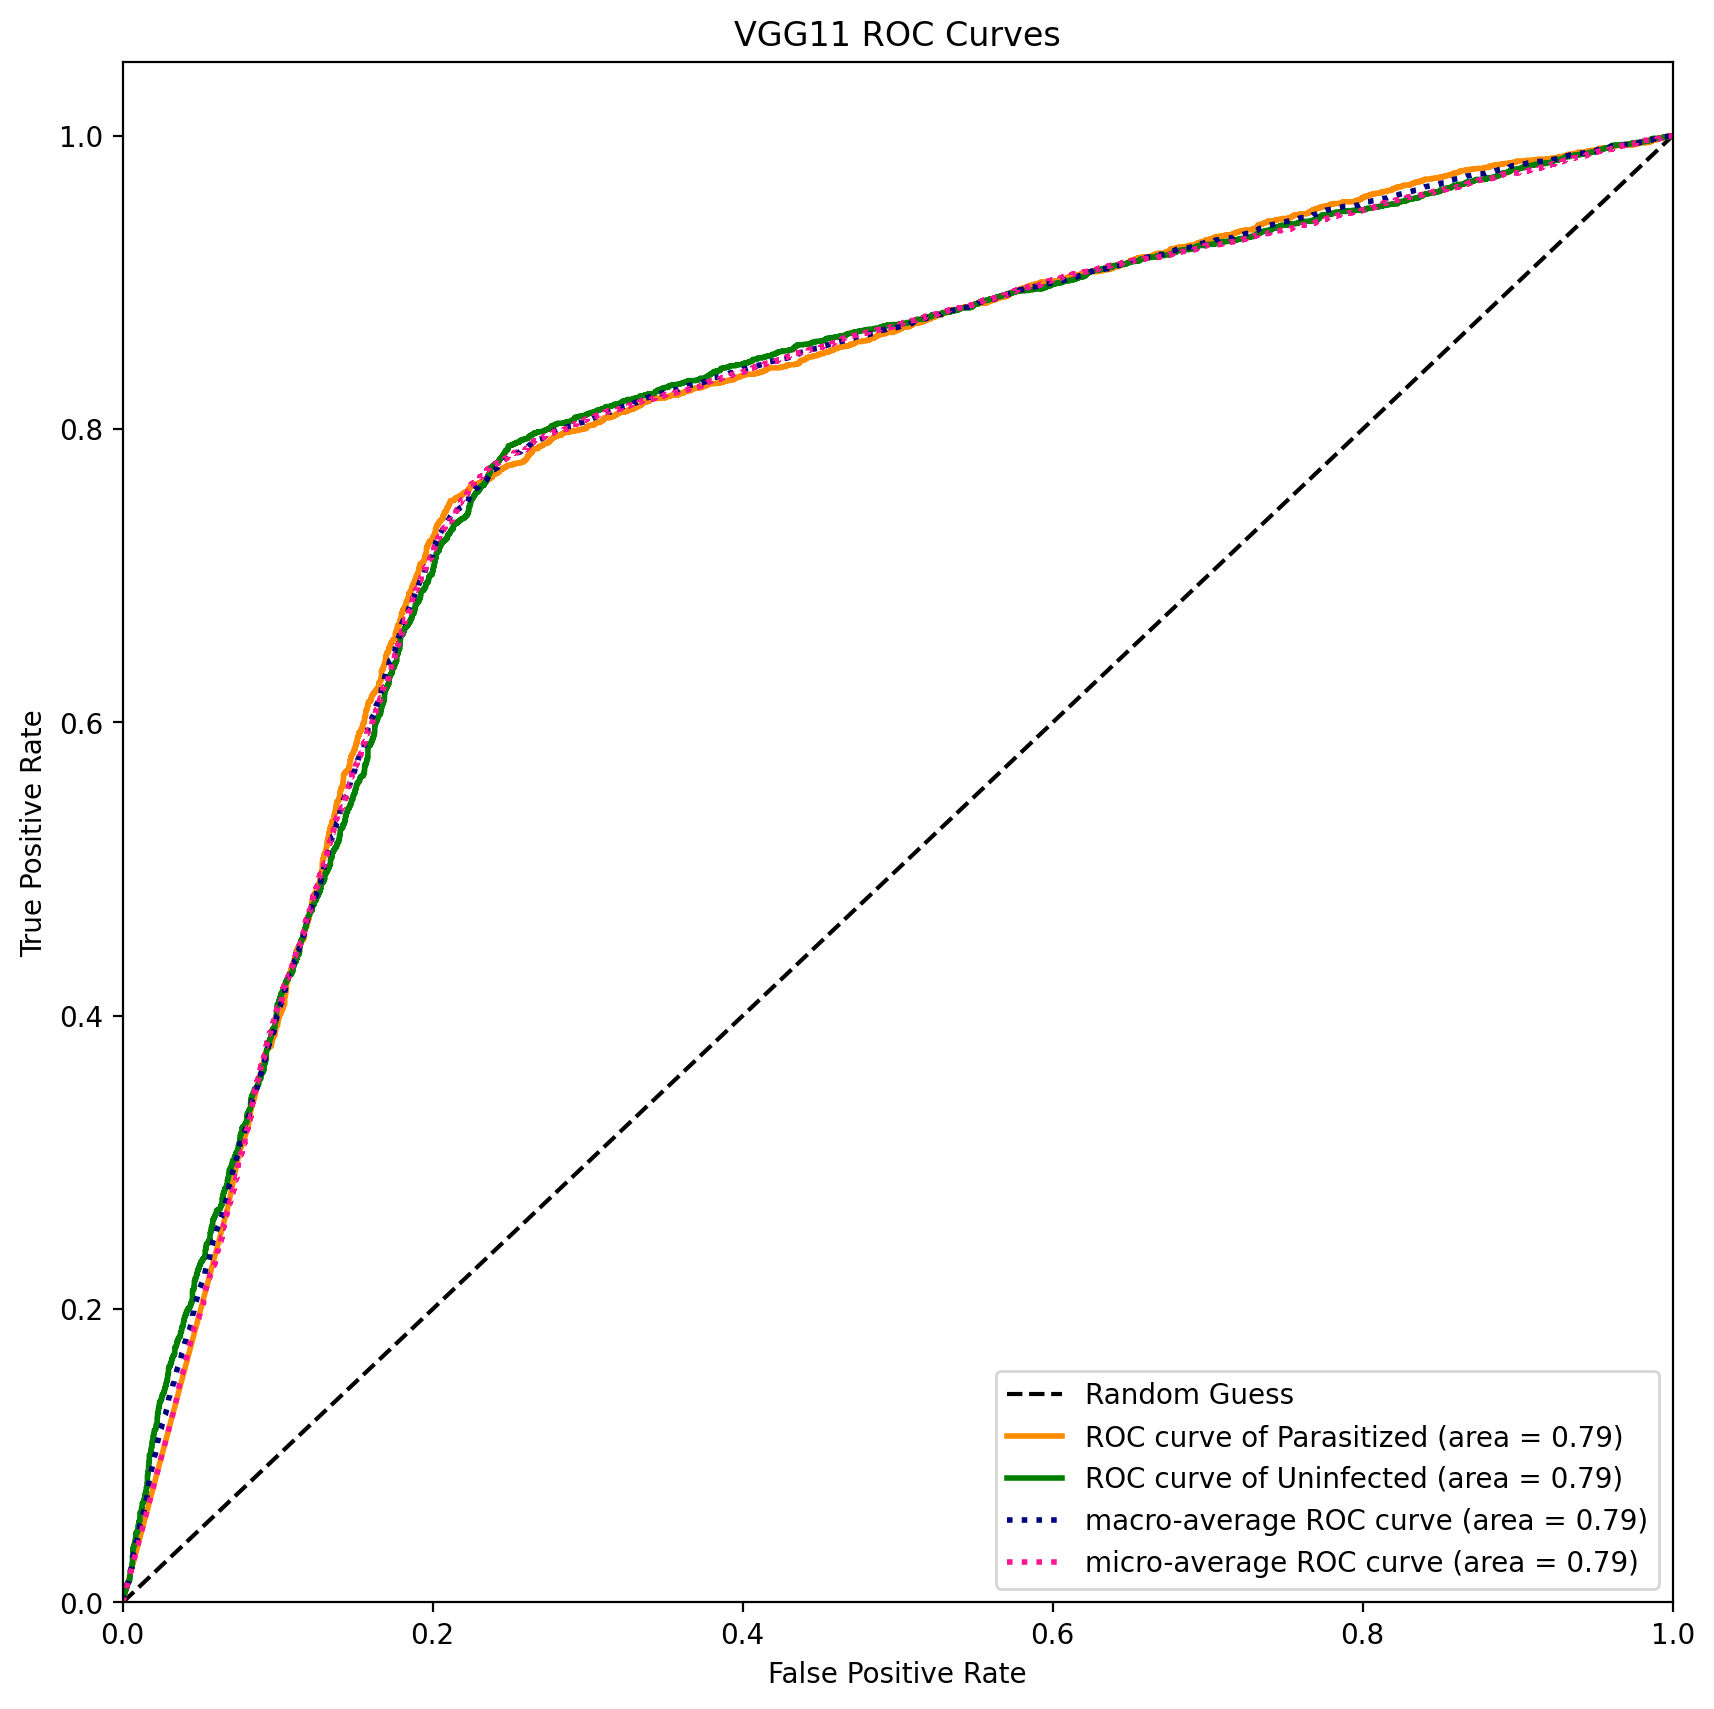

In [ ]:
vgg_model.load_state_dict(torch.load('VGG_Adam.pt'))
vgg_model.to(device)
images, labels, probs = get_predictions(vgg_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "VGG11")

              precision    recall  f1-score   support

 Parasitized       0.77      0.76      0.77      4133
  Uninfected       0.76      0.78      0.77      4133

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266



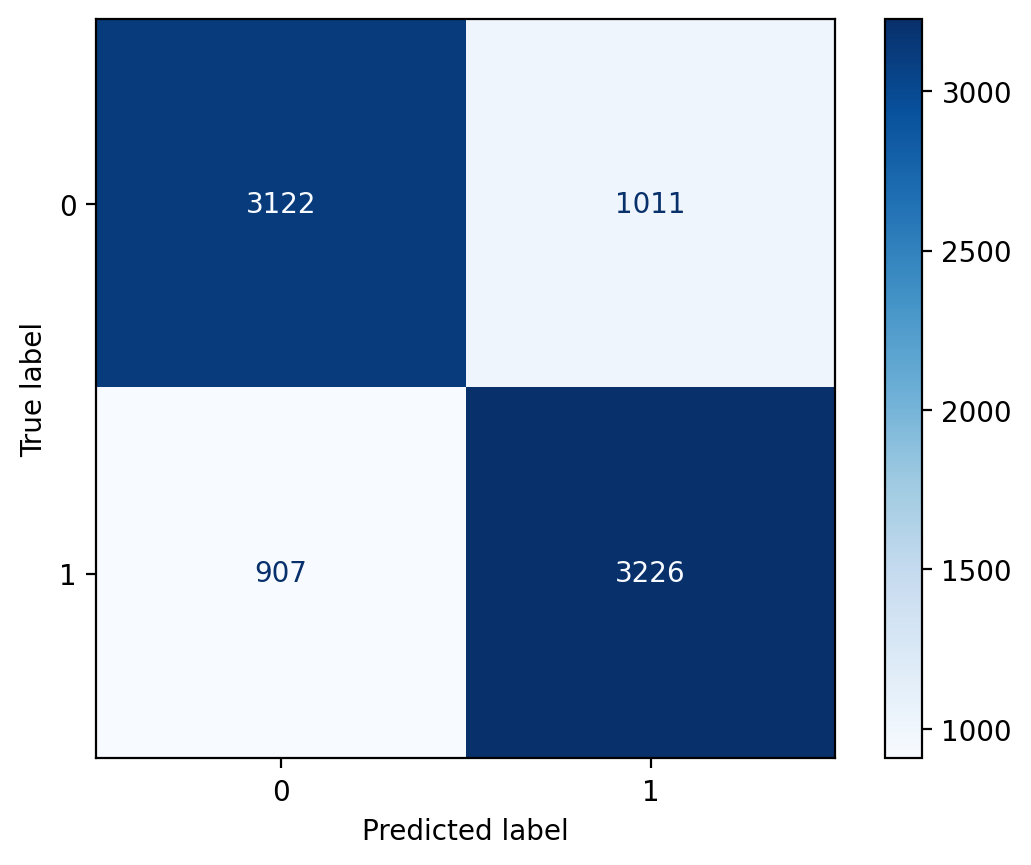

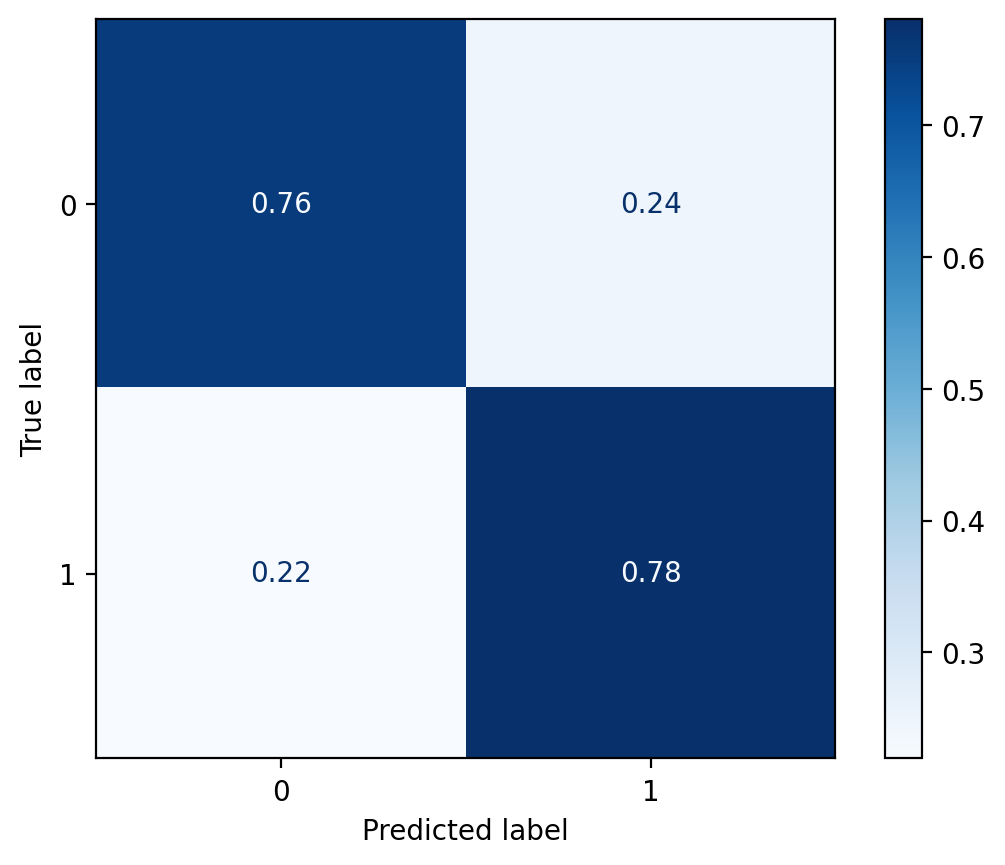

In [ ]:
plot_confusion_matrix(y_test, probs)

#### VGG1 w/ SGD

In [ ]:
vgg11_layers = get_vgg_layers(vgg_configs["11"], batch_norm=True)

NUM_CLASSES = 2
IMG_SIZE = 64

vgg_model = VGG(vgg11_layers, IMG_SIZE, NUM_CLASSES)

In [ ]:
FOUND_LR = 1e-3

params = [
    {'params': vgg_model.features.parameters(), 'lr': FOUND_LR / 10},
    {'params': vgg_model.classifier.parameters()}
]

sgd_optimizer = optim.SGD(params, lr=FOUND_LR)

In [ ]:
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, vgg_model, sgd_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 12m 27s
	Train Loss: 0.673 | Train Acc:  57.90% |
	Valid Loss: 0.632 | Valid Acc:  69.44% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 4m 27s
	Train Loss: 0.636 | Train Acc:  64.87% |
	Valid Loss: 0.598 | Valid Acc:  68.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 57s
	Train Loss: 0.605 | Train Acc:  68.06% |
	Valid Loss: 0.567 | Valid Acc:  70.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 53s
	Train Loss: 0.586 | Train Acc:  69.58% |
	Valid Loss: 0.546 | Valid Acc:  71.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 51s
	Train Loss: 0.566 | Train Acc:  70.83% |
	Valid Loss: 0.532 | Valid Acc:  73.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 44s
	Train Loss: 0.545 | Train Acc:  72.38% |
	Valid Loss: 0.511 | Valid Acc:  73.76% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 44s
	Train Loss: 0.528 | Train Acc:  73.53% |
	Valid Loss: 0.484 | Valid Acc:  75.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 44s
	Train Loss: 0.503 | Train Acc:  75.31% |
	Valid Loss: 0.457 | Valid Acc:  77.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 44s
	Train Loss: 0.479 | Train Acc:  76.93% |
	Valid Loss: 0.431 | Valid Acc:  79.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 44s
	Train Loss: 0.448 | Train Acc:  79.13% |
	Valid Loss: 0.399 | Valid Acc:  82.12% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 45s
	Train Loss: 0.423 | Train Acc:  80.81% |
	Valid Loss: 0.376 | Valid Acc:  83.65% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 45s
	Train Loss: 0.392 | Train Acc:  82.51% |
	Valid Loss: 0.345 | Valid Acc:  84.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 44s
	Train Loss: 0.369 | Train Acc:  83.65% |
	Valid Loss: 0.324 | Valid Acc:  85.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 44s
	Train Loss: 0.346 | Train Acc:  84.99% |
	Valid Loss: 0.307 | Valid Acc:  85.76% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 44s
	Train Loss: 0.320 | Train Acc:  86.34% |
	Valid Loss: 0.287 | Valid Acc:  87.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 2m 26s
	Train Loss: 0.305 | Train Acc:  87.06% |
	Valid Loss: 0.272 | Valid Acc:  88.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 2m 1s
	Train Loss: 0.291 | Train Acc:  87.39% |
	Valid Loss: 0.258 | Valid Acc:  89.03% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 1m 53s
	Train Loss: 0.271 | Train Acc:  88.78% |
	Valid Loss: 0.246 | Valid Acc:  89.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 1m 55s
	Train Loss: 0.258 | Train Acc:  89.38% |
	Valid Loss: 0.235 | Valid Acc:  90.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 1m 54s
	Train Loss: 0.248 | Train Acc:  89.84% |
	Valid Loss: 0.223 | Valid Acc:  91.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 1m 53s
	Train Loss: 0.233 | Train Acc:  90.68% |
	Valid Loss: 0.216 | Valid Acc:  91.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 1m 54s
	Train Loss: 0.219 | Train Acc:  91.34% |
	Valid Loss: 0.210 | Valid Acc:  91.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 1m 53s
	Train Loss: 0.212 | Train Acc:  91.62% |
	Valid Loss: 0.204 | Valid Acc:  92.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 1m 54s
	Train Loss: 0.204 | Train Acc:  92.05% |
	Valid Loss: 0.205 | Valid Acc:  91.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 1m 55s
	Train Loss: 0.197 | Train Acc:  92.38% |
	Valid Loss: 0.192 | Valid Acc:  92.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 1m 54s
	Train Loss: 0.186 | Train Acc:  92.87% |
	Valid Loss: 0.189 | Valid Acc:  92.88% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 1m 59s
	Train Loss: 0.182 | Train Acc:  93.01% |
	Valid Loss: 0.184 | Valid Acc:  93.10% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 2m 6s
	Train Loss: 0.174 | Train Acc:  93.51% |
	Valid Loss: 0.182 | Valid Acc:  92.91% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 2m 31s
	Train Loss: 0.166 | Train Acc:  93.88% |
	Valid Loss: 0.178 | Valid Acc:  93.24% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 2m 16s
	Train Loss: 0.165 | Train Acc:  94.01% |
	Valid Loss: 0.173 | Valid Acc:  93.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 1m 54s
	Train Loss: 0.156 | Train Acc:  94.27% |
	Valid Loss: 0.172 | Valid Acc:  93.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 1m 55s
	Train Loss: 0.156 | Train Acc:  94.28% |
	Valid Loss: 0.168 | Valid Acc:  93.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 1m 54s
	Train Loss: 0.150 | Train Acc:  94.63% |
	Valid Loss: 0.167 | Valid Acc:  93.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 1m 53s
	Train Loss: 0.145 | Train Acc:  94.57% |
	Valid Loss: 0.168 | Valid Acc:  93.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 1m 54s
	Train Loss: 0.143 | Train Acc:  94.78% |
	Valid Loss: 0.164 | Valid Acc:  93.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 1m 53s
	Train Loss: 0.134 | Train Acc:  95.31% |
	Valid Loss: 0.165 | Valid Acc:  93.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 1m 53s
	Train Loss: 0.130 | Train Acc:  95.34% |
	Valid Loss: 0.161 | Valid Acc:  93.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 1m 55s
	Train Loss: 0.127 | Train Acc:  95.39% |
	Valid Loss: 0.160 | Valid Acc:  94.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 1m 53s
	Train Loss: 0.123 | Train Acc:  95.63% |
	Valid Loss: 0.161 | Valid Acc:  94.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 1m 54s
	Train Loss: 0.119 | Train Acc:  95.87% |
	Valid Loss: 0.162 | Valid Acc:  93.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 1m 54s
	Train Loss: 0.118 | Train Acc:  95.78% |
	Valid Loss: 0.157 | Valid Acc:  94.22% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 2m 7s
	Train Loss: 0.115 | Train Acc:  95.98% |
	Valid Loss: 0.157 | Valid Acc:  94.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 1m 56s
	Train Loss: 0.111 | Train Acc:  95.96% |
	Valid Loss: 0.160 | Valid Acc:  94.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 1m 53s
	Train Loss: 0.107 | Train Acc:  96.16% |
	Valid Loss: 0.156 | Valid Acc:  94.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 1m 54s
	Train Loss: 0.102 | Train Acc:  96.41% |
	Valid Loss: 0.158 | Valid Acc:  94.44% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 1m 53s
	Train Loss: 0.100 | Train Acc:  96.46% |
	Valid Loss: 0.161 | Valid Acc:  94.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 1m 55s
	Train Loss: 0.097 | Train Acc:  96.55% |
	Valid Loss: 0.156 | Valid Acc:  94.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 1m 55s
	Train Loss: 0.092 | Train Acc:  96.81% |
	Valid Loss: 0.157 | Valid Acc:  94.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 1m 55s
	Train Loss: 0.091 | Train Acc:  96.91% |
	Valid Loss: 0.163 | Valid Acc:  94.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 2m 0s
	Train Loss: 0.085 | Train Acc:  97.19% |
	Valid Loss: 0.160 | Valid Acc:  94.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 1m 55s
	Train Loss: 0.086 | Train Acc:  96.97% |
	Valid Loss: 0.160 | Valid Acc:  94.66% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 44, Best validation accuracy: 0.9447674418604651, Best validation loss: 0.1555286993673288


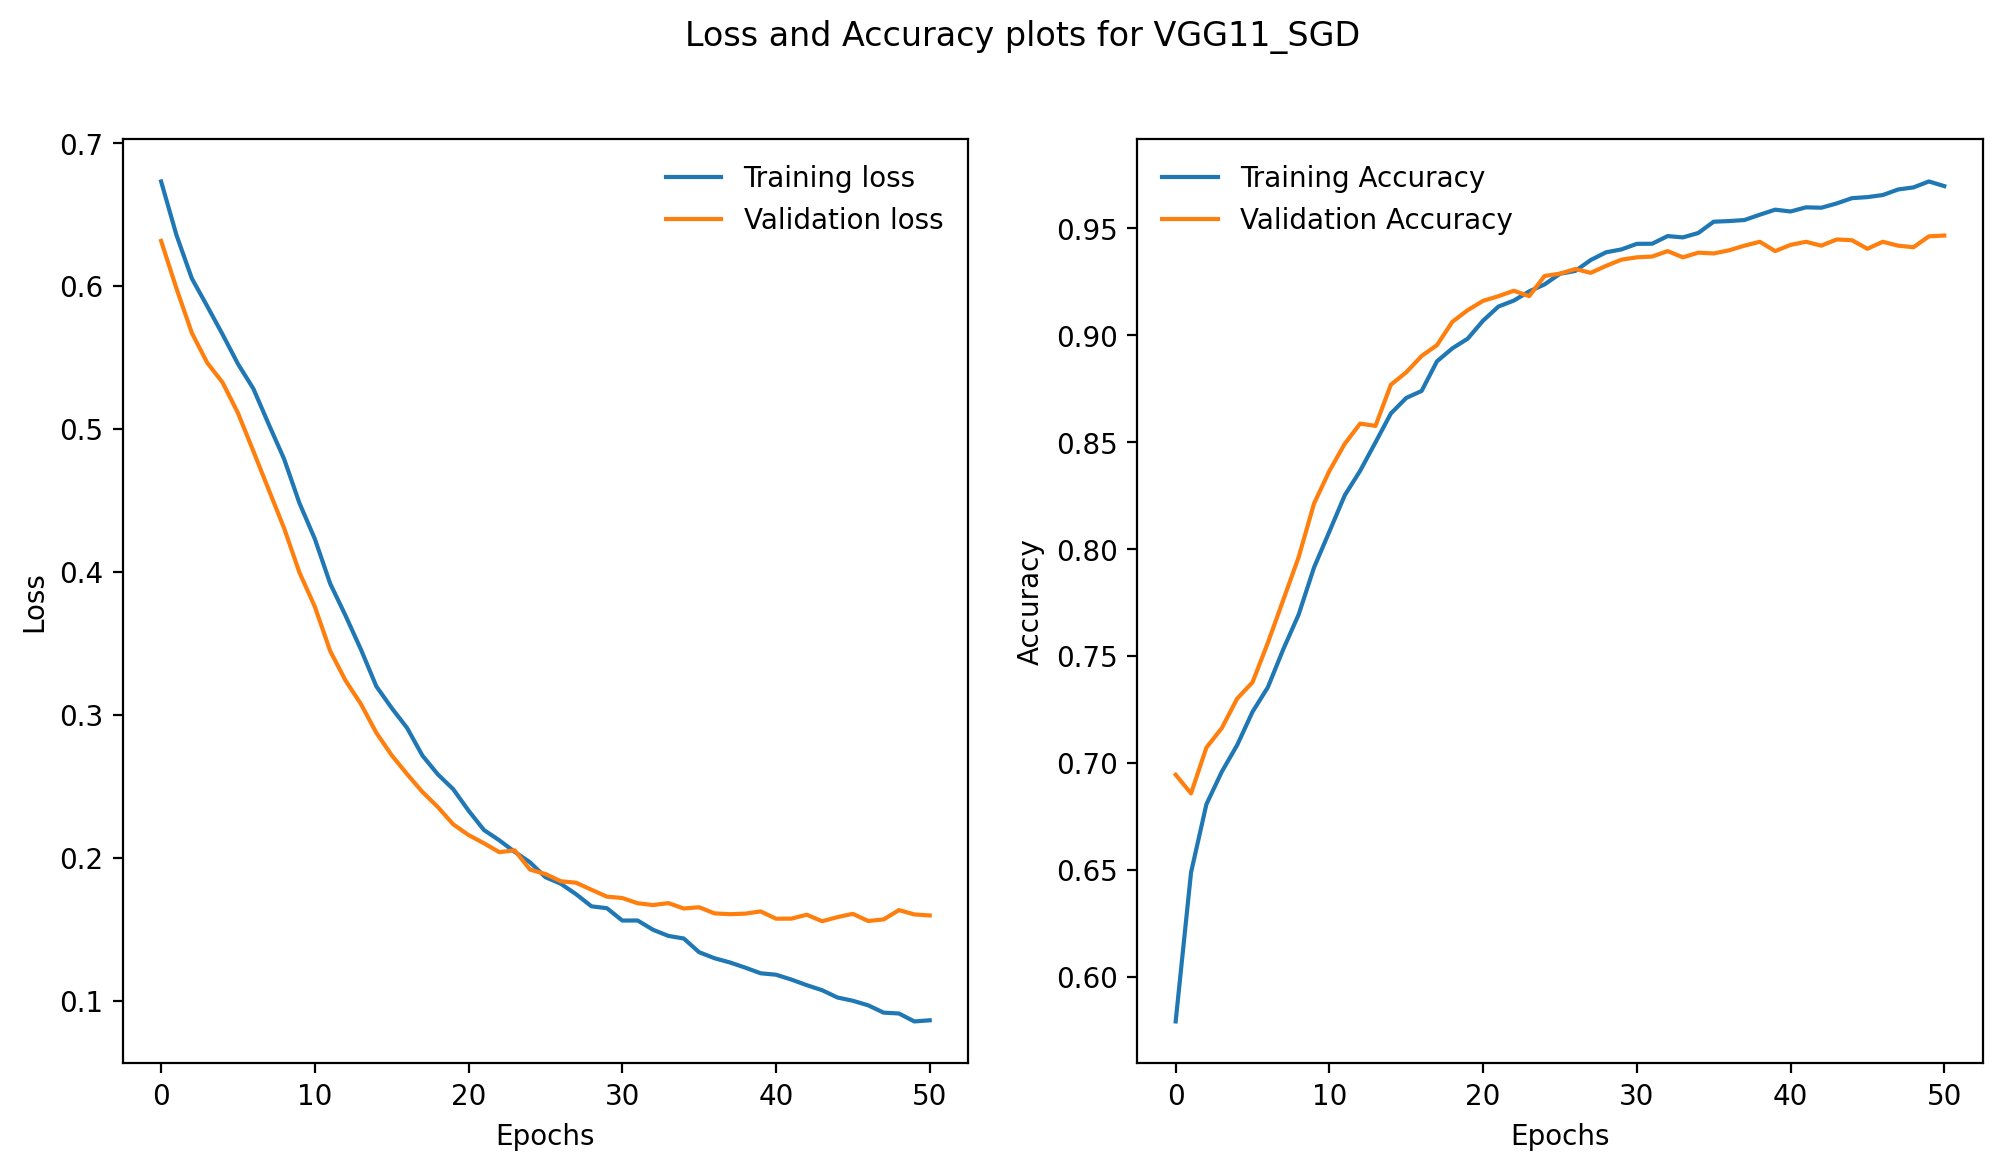

In [ ]:
plot_loss_acc('VGG11_SGD', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

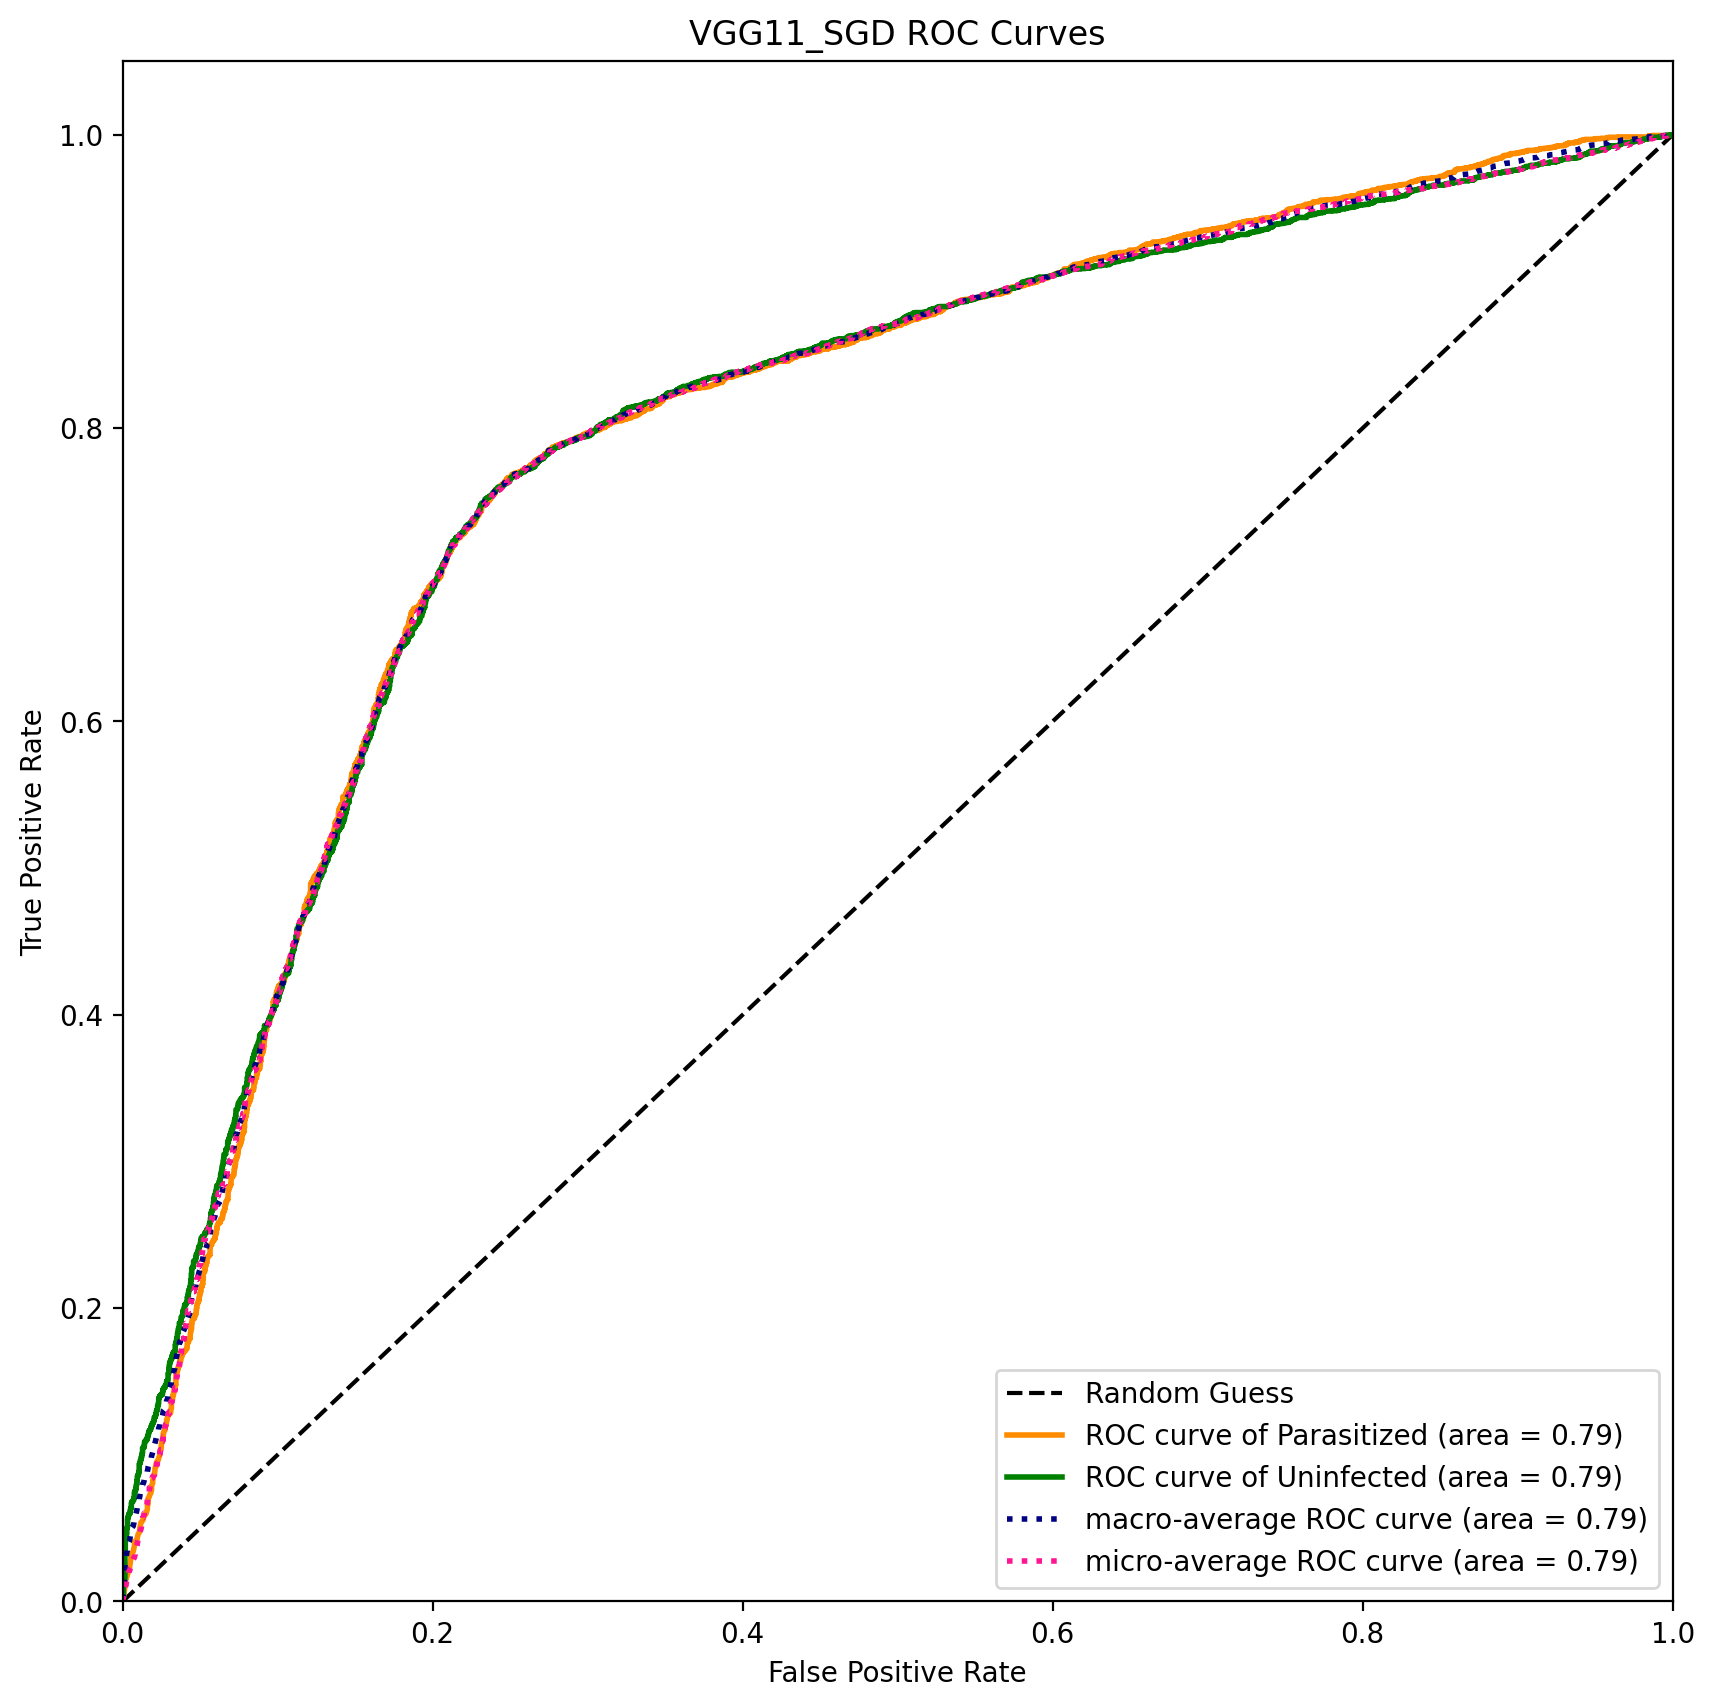

In [ ]:
vgg_model.load_state_dict(torch.load('VGG_SGD.pt'))
vgg_model.to(device)
images, labels, probs = get_predictions(vgg_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "VGG11_SGD")

              precision    recall  f1-score   support

 Parasitized       0.76      0.75      0.76      4133
  Uninfected       0.75      0.77      0.76      4133

    accuracy                           0.76      8266
   macro avg       0.76      0.76      0.76      8266
weighted avg       0.76      0.76      0.76      8266



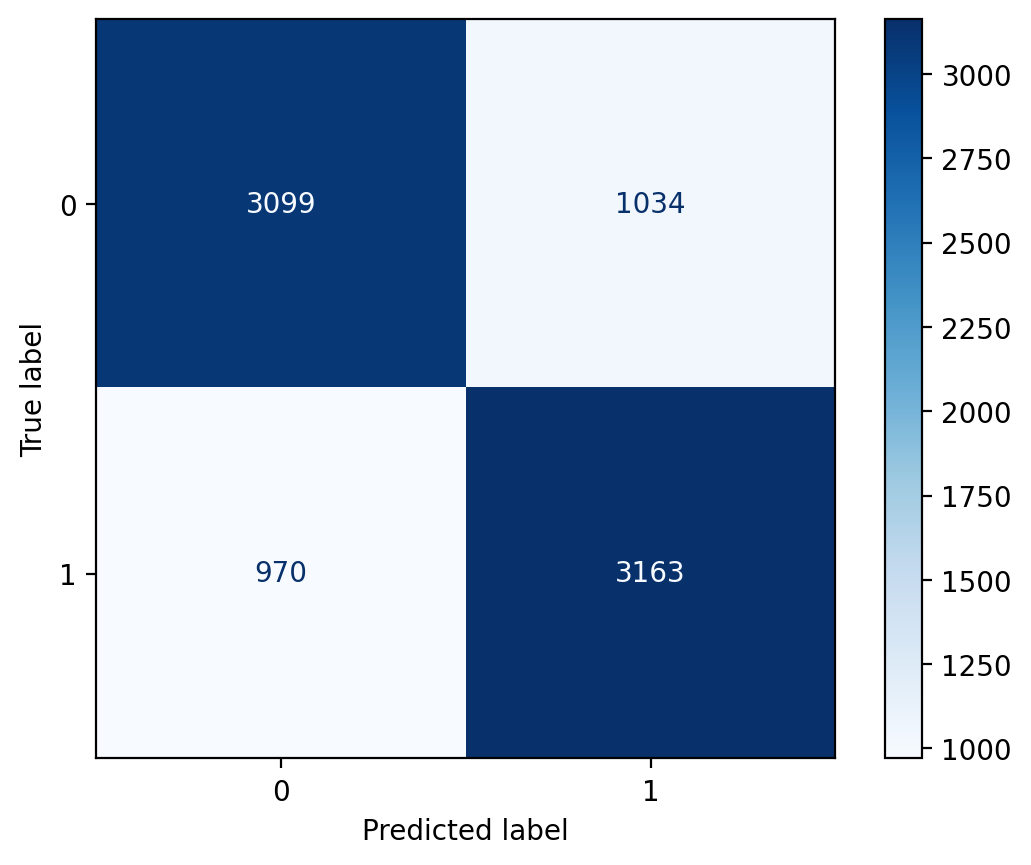

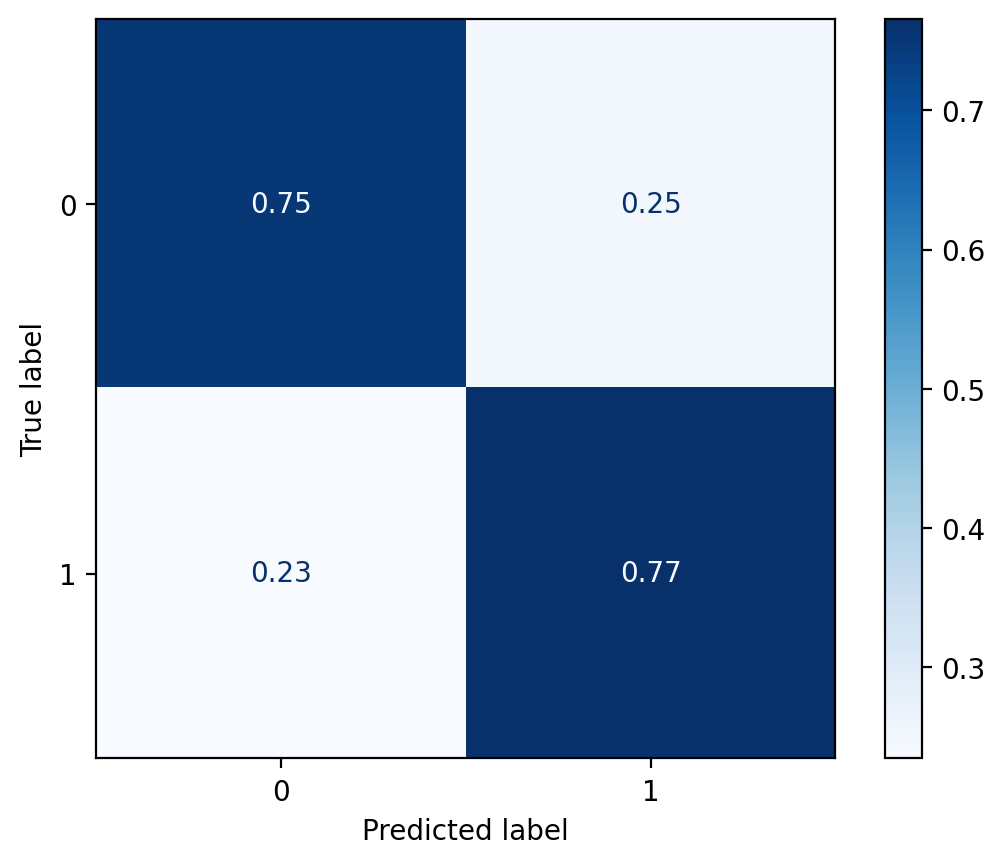

In [ ]:
plot_confusion_matrix(y_test, probs)

### AlexNet

In [ ]:
alexnet_model = AlexNet(64, 2)
count_parameters(alexnet_model)

The model has 20,311,874 trainable parameters


In [ ]:
summary(alexnet_model, input_size=(batch_size, 3, 64, 64), col_names=("input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                ))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape
AlexNet                                  [64, 3, 64, 64]           [64, 2]                   --                             --                   --
├─Sequential: 1-1                        [64, 3, 64, 64]           [64, 256, 1, 1]           --                             --                   --
│    └─Conv2d: 2-1                       [64, 3, 64, 64]           [64, 64, 15, 15]          23,296                      0.11%                   [11, 11]
│    └─ReLU: 2-2                         [64, 64, 15, 15]          [64, 64, 15, 15]          --                             --                   --
│    └─MaxPool2d: 2-3                    [64, 64, 15, 15]          [64, 64, 7, 7]            --                             --                   3
│    └─Conv2d: 2-4                       [64, 64, 7, 7]            [64, 192, 7, 7]           307,

In [ ]:
CHOSE_LR = 1e-3

adam_optimizer = optim.Adam(alexnet_model.parameters(), lr=CHOSE_LR)

In [ ]:
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, alexnet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 5s
	Train Loss: 1.239 | Train Acc:  68.60% |
	Valid Loss: 0.390 | Valid Acc:  83.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.339 | Train Acc:  85.27% |
	Valid Loss: 0.202 | Valid Acc:  92.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.212 | Train Acc:  92.34% |
	Valid Loss: 0.185 | Valid Acc:  93.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.174 | Train Acc:  93.91% |
	Valid Loss: 0.163 | Valid Acc:  94.55% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 0.154 | Train Acc:  94.85% |
	Valid Loss: 0.178 | Valid Acc:  93.50% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 43s
	Train Loss: 0.152 | Train Acc:  94.85% |
	Valid Loss: 0.142 | Valid Acc:  95.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 43s
	Train Loss: 0.143 | Train Acc:  95.09% |
	Valid Loss: 0.134 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 43s
	Train Loss: 0.135 | Train Acc:  95.41% |
	Valid Loss: 0.147 | Valid Acc:  95.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 0.133 | Train Acc:  95.45% |
	Valid Loss: 0.136 | Valid Acc:  95.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 42s
	Train Loss: 0.122 | Train Acc:  95.86% |
	Valid Loss: 0.150 | Valid Acc:  94.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 42s
	Train Loss: 0.127 | Train Acc:  95.69% |
	Valid Loss: 0.144 | Valid Acc:  95.13% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 43s
	Train Loss: 0.131 | Train Acc:  95.74% |
	Valid Loss: 0.155 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 43s
	Train Loss: 0.121 | Train Acc:  95.91% |
	Valid Loss: 0.132 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 42s
	Train Loss: 0.111 | Train Acc:  96.18% |
	Valid Loss: 0.136 | Valid Acc:  95.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 43s
	Train Loss: 0.113 | Train Acc:  96.08% |
	Valid Loss: 0.158 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 43s
	Train Loss: 0.109 | Train Acc:  96.15% |
	Valid Loss: 0.140 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 42s
	Train Loss: 0.104 | Train Acc:  96.32% |
	Valid Loss: 0.159 | Valid Acc:  94.40% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 42s
	Train Loss: 0.097 | Train Acc:  96.55% |
	Valid Loss: 0.141 | Valid Acc:  95.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 42s
	Train Loss: 0.092 | Train Acc:  96.69% |
	Valid Loss: 0.155 | Valid Acc:  95.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 42s
	Train Loss: 0.090 | Train Acc:  96.90% |
	Valid Loss: 0.183 | Valid Acc:  93.79% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 43s
	Train Loss: 0.092 | Train Acc:  96.88% |
	Valid Loss: 0.125 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 44s
	Train Loss: 0.086 | Train Acc:  96.96% |
	Valid Loss: 0.153 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 44s
	Train Loss: 0.090 | Train Acc:  96.95% |
	Valid Loss: 0.155 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 43s
	Train Loss: 0.087 | Train Acc:  97.12% |
	Valid Loss: 0.142 | Valid Acc:  95.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 43s
	Train Loss: 0.094 | Train Acc:  96.72% |
	Valid Loss: 0.154 | Valid Acc:  95.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 43s
	Train Loss: 0.083 | Train Acc:  97.02% |
	Valid Loss: 0.161 | Valid Acc:  95.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 44s
	Train Loss: 0.092 | Train Acc:  96.88% |
	Valid Loss: 0.169 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 43s
	Train Loss: 0.080 | Train Acc:  97.12% |
	Valid Loss: 0.150 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 21, Best validation accuracy: 0.9578488372093024, Best validation loss: 0.12471440848136364


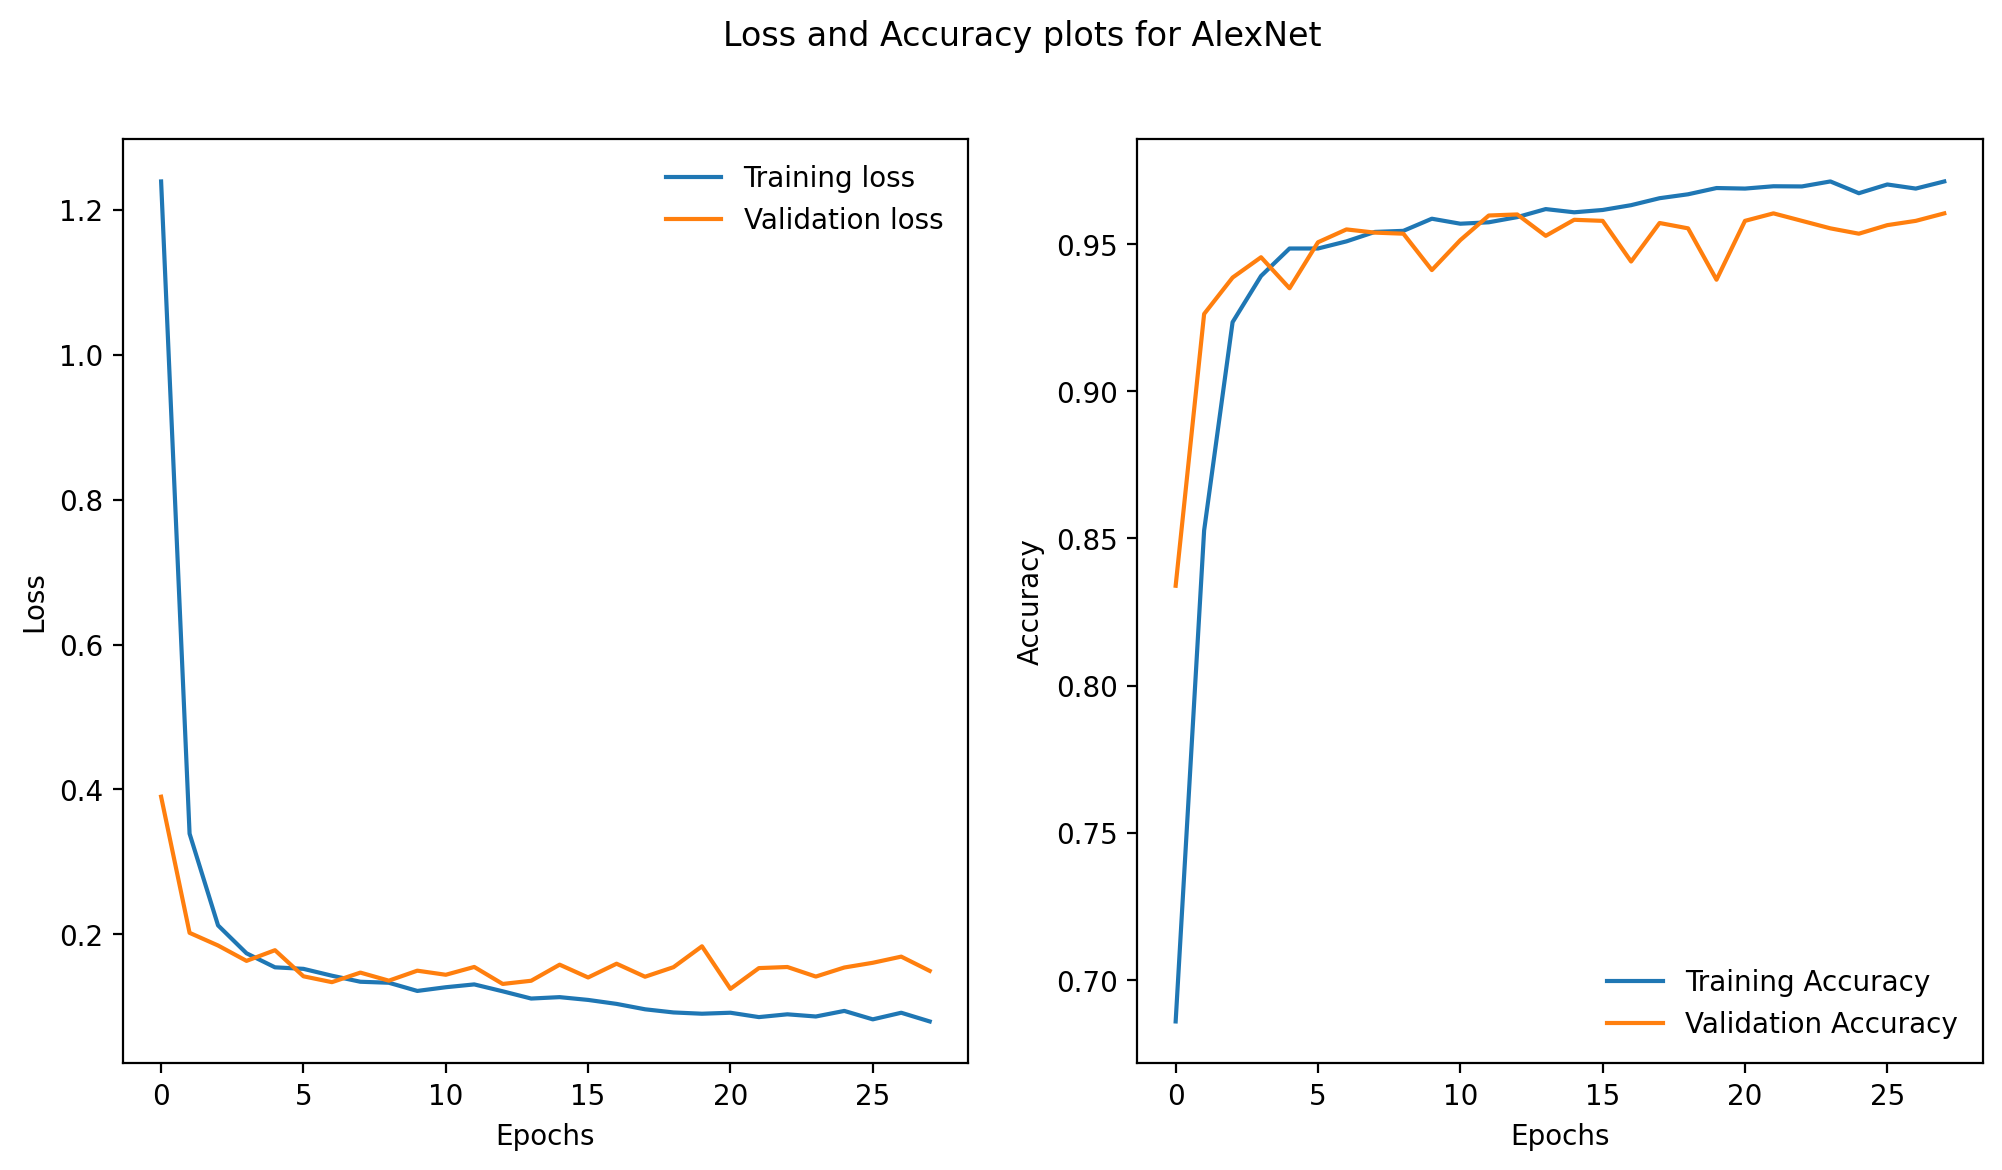

In [ ]:
plot_loss_acc('AlexNet', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

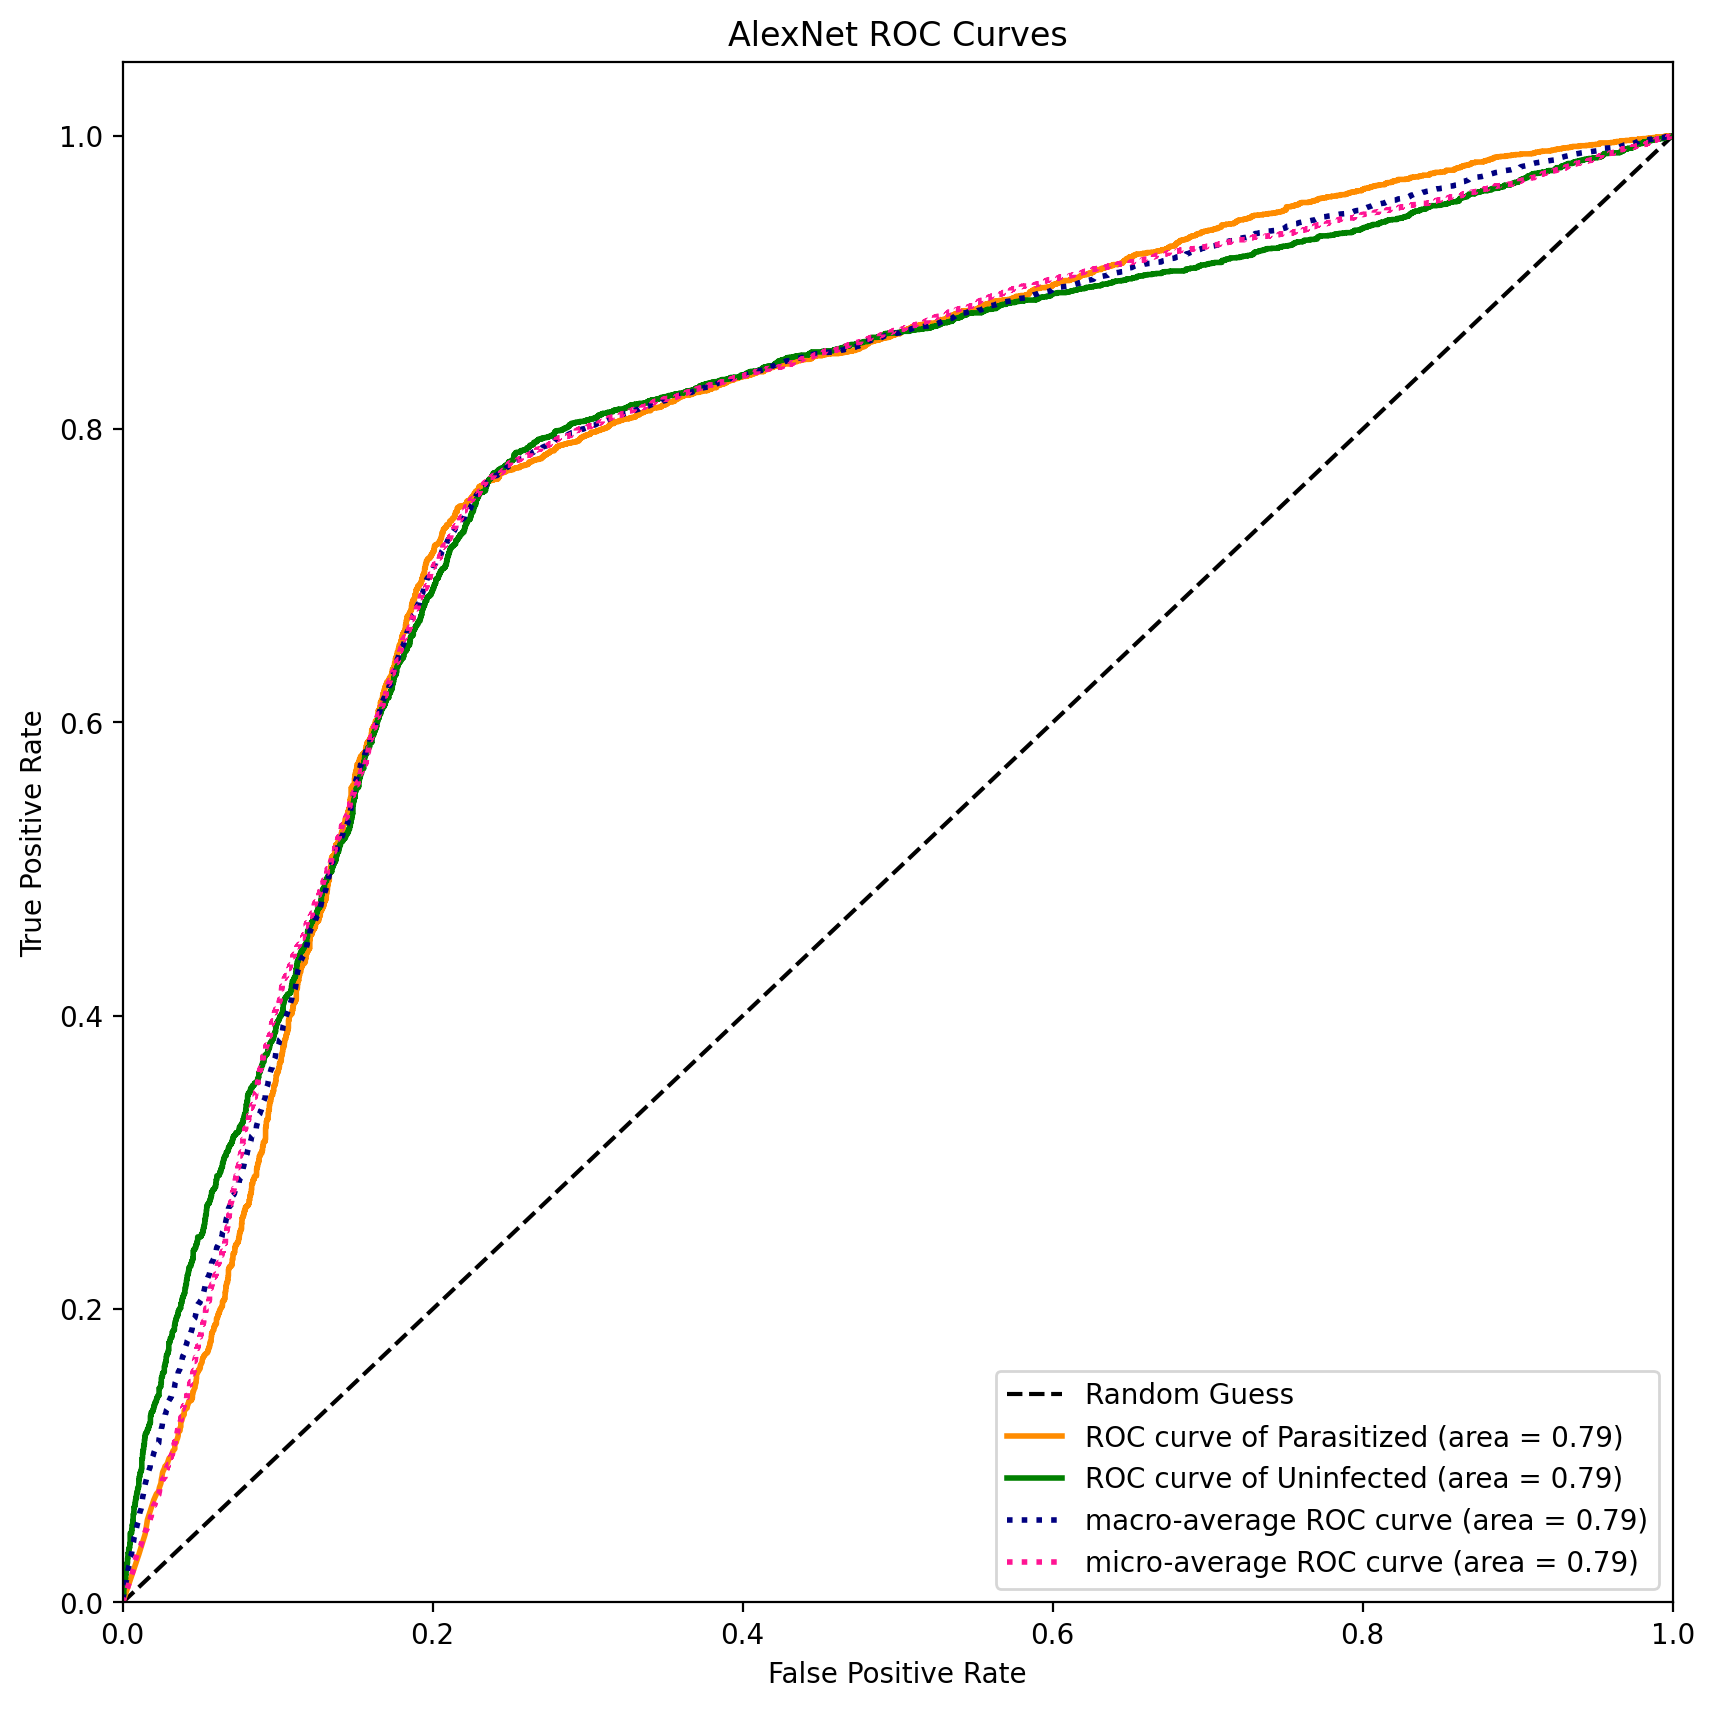

In [ ]:
alexnet_model.load_state_dict(torch.load('AlexNet_Adam.pt'))
alexnet_model.to(device)
images, labels, probs = get_predictions(alexnet_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "AlexNet")

              precision    recall  f1-score   support

 Parasitized       0.77      0.76      0.76      4133
  Uninfected       0.76      0.77      0.77      4133

    accuracy                           0.76      8266
   macro avg       0.76      0.76      0.76      8266
weighted avg       0.76      0.76      0.76      8266



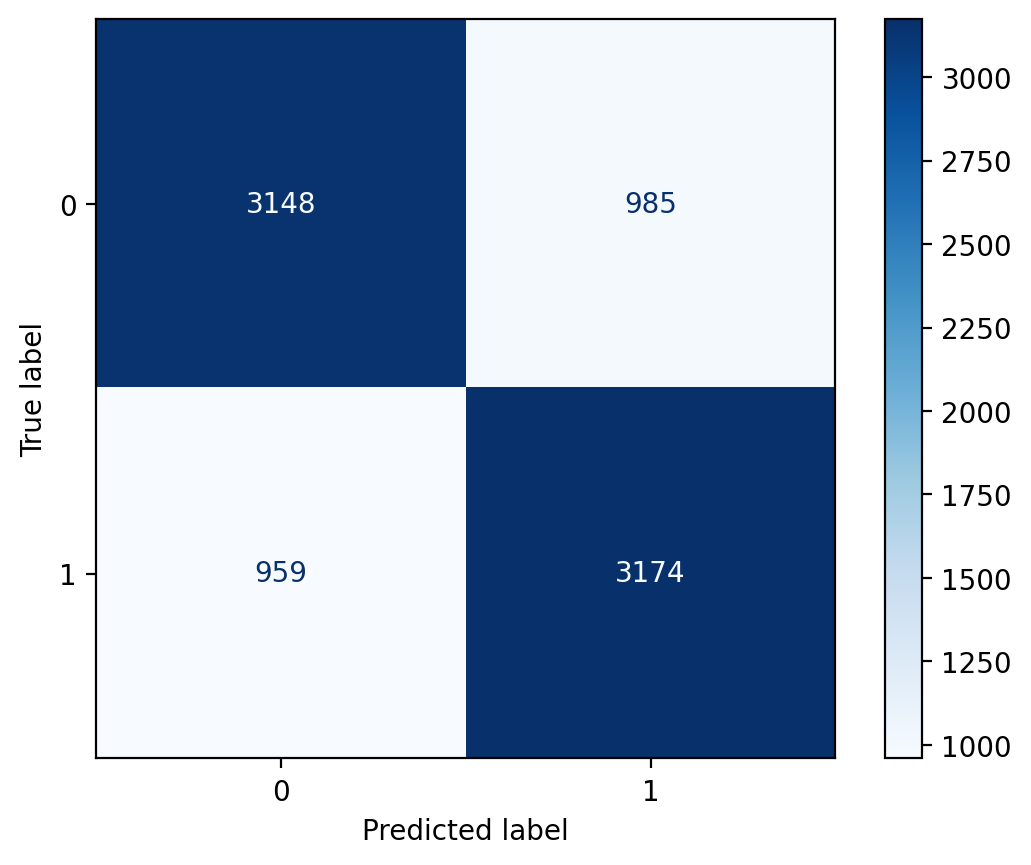

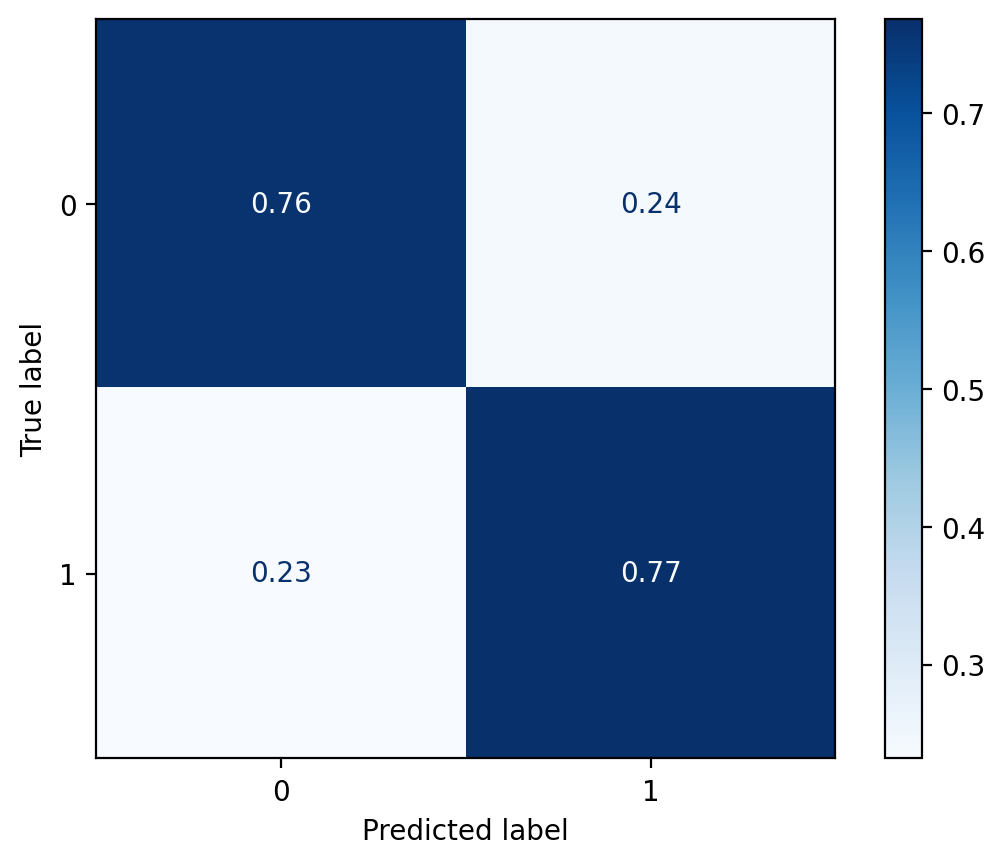

In [ ]:
plot_confusion_matrix(y_test, probs)

#### AlexNet w/ SGD

In [ ]:
alexnet_model = AlexNet(64, 2)
count_parameters(alexnet_model)

The model has 20,311,874 trainable parameters


In [ ]:
sgd_optimizer = optim.SGD(alexnet_model.parameters(), lr=CHOSE_LR)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, alexnet_model, sgd_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 0.823 | Train Acc:  54.91% |
	Valid Loss: 0.619 | Valid Acc:  69.73% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 35s
	Train Loss: 0.673 | Train Acc:  61.19% |
	Valid Loss: 0.576 | Valid Acc:  71.80% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.625 | Train Acc:  66.01% |
	Valid Loss: 0.534 | Valid Acc:  74.09% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.581 | Train Acc:  70.29% |
	Valid Loss: 0.511 | Valid Acc:  76.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 36s
	Train Loss: 0.542 | Train Acc:  73.47% |
	Valid Loss: 0.461 | Valid Acc:  79.32% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 0.504 | Train Acc:  75.48% |
	Valid Loss: 0.425 | Valid Acc:  79.94% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 34s
	Train Loss: 0.480 | Train Acc:  77.74% |
	Valid Loss: 0.402 | Valid Acc:  81.98% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 35s
	Train Loss: 0.463 | Train Acc:  78.53% |
	Valid Loss: 0.388 | Valid Acc:  81.65% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 0.441 | Train Acc:  79.68% |
	Valid Loss: 0.477 | Valid Acc:  78.23% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 34s
	Train Loss: 0.427 | Train Acc:  80.13% |
	Valid Loss: 0.402 | Valid Acc:  80.09% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 34s
	Train Loss: 0.416 | Train Acc:  81.10% |
	Valid Loss: 0.414 | Valid Acc:  81.07% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 35s
	Train Loss: 0.413 | Train Acc:  81.23% |
	Valid Loss: 0.416 | Valid Acc:  79.87% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 35s
	Train Loss: 0.405 | Train Acc:  81.70% |
	Valid Loss: 0.346 | Valid Acc:  83.36% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 35s
	Train Loss: 0.394 | Train Acc:  82.37% |
	Valid Loss: 0.522 | Valid Acc:  74.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 34s
	Train Loss: 0.383 | Train Acc:  82.92% |
	Valid Loss: 0.619 | Valid Acc:  74.16% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 34s
	Train Loss: 0.380 | Train Acc:  82.96% |
	Valid Loss: 0.397 | Valid Acc:  82.34% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 35s
	Train Loss: 0.365 | Train Acc:  83.47% |
	Valid Loss: 0.317 | Valid Acc:  85.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 35s
	Train Loss: 0.363 | Train Acc:  84.18% |
	Valid Loss: 0.311 | Valid Acc:  85.72% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 34s
	Train Loss: 0.355 | Train Acc:  84.27% |
	Valid Loss: 0.304 | Valid Acc:  86.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 35s
	Train Loss: 0.348 | Train Acc:  84.72% |
	Valid Loss: 0.299 | Valid Acc:  86.45% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 34s
	Train Loss: 0.341 | Train Acc:  84.96% |
	Valid Loss: 0.293 | Valid Acc:  86.99% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 35s
	Train Loss: 0.334 | Train Acc:  85.51% |
	Valid Loss: 0.298 | Valid Acc:  86.85% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 35s
	Train Loss: 0.328 | Train Acc:  85.85% |
	Valid Loss: 0.365 | Valid Acc:  83.87% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 35s
	Train Loss: 0.322 | Train Acc:  86.16% |
	Valid Loss: 0.314 | Valid Acc:  86.85% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 35s
	Train Loss: 0.315 | Train Acc:  86.32% |
	Valid Loss: 0.281 | Valid Acc:  87.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 35s
	Train Loss: 0.306 | Train Acc:  86.93% |
	Valid Loss: 0.335 | Valid Acc:  85.54% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 35s
	Train Loss: 0.309 | Train Acc:  86.65% |
	Valid Loss: 0.286 | Valid Acc:  87.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 35s
	Train Loss: 0.296 | Train Acc:  87.42% |
	Valid Loss: 0.266 | Valid Acc:  88.34% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 35s
	Train Loss: 0.295 | Train Acc:  87.54% |
	Valid Loss: 0.264 | Valid Acc:  88.63% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 34s
	Train Loss: 0.283 | Train Acc:  88.01% |
	Valid Loss: 0.259 | Valid Acc:  88.55% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 36s
	Train Loss: 0.277 | Train Acc:  88.65% |
	Valid Loss: 0.265 | Valid Acc:  88.59% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 35s
	Train Loss: 0.281 | Train Acc:  88.11% |
	Valid Loss: 0.270 | Valid Acc:  88.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 35s
	Train Loss: 0.274 | Train Acc:  88.56% |
	Valid Loss: 0.260 | Valid Acc:  88.74% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 35s
	Train Loss: 0.259 | Train Acc:  89.37% |
	Valid Loss: 0.263 | Valid Acc:  89.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 35s
	Train Loss: 0.261 | Train Acc:  89.18% |
	Valid Loss: 0.243 | Valid Acc:  89.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 36s
	Train Loss: 0.267 | Train Acc:  88.97% |
	Valid Loss: 0.248 | Valid Acc:  89.83% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 35s
	Train Loss: 0.250 | Train Acc:  89.64% |
	Valid Loss: 0.310 | Valid Acc:  86.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 35s
	Train Loss: 0.246 | Train Acc:  89.78% |
	Valid Loss: 0.241 | Valid Acc:  89.90% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 35s
	Train Loss: 0.239 | Train Acc:  90.11% |
	Valid Loss: 0.246 | Valid Acc:  90.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 36s
	Train Loss: 0.233 | Train Acc:  90.50% |
	Valid Loss: 0.298 | Valid Acc:  87.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 35s
	Train Loss: 0.222 | Train Acc:  91.05% |
	Valid Loss: 0.296 | Valid Acc:  87.94% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 38s
	Train Loss: 0.232 | Train Acc:  90.59% |
	Valid Loss: 0.230 | Valid Acc:  90.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 38s
	Train Loss: 0.226 | Train Acc:  90.69% |
	Valid Loss: 0.241 | Valid Acc:  89.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 36s
	Train Loss: 0.220 | Train Acc:  91.12% |
	Valid Loss: 0.237 | Valid Acc:  90.44% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 35s
	Train Loss: 0.211 | Train Acc:  91.55% |
	Valid Loss: 0.231 | Valid Acc:  89.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 36s
	Train Loss: 0.206 | Train Acc:  91.75% |
	Valid Loss: 0.218 | Valid Acc:  91.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 35s
	Train Loss: 0.211 | Train Acc:  91.64% |
	Valid Loss: 0.348 | Valid Acc:  86.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 36s
	Train Loss: 0.204 | Train Acc:  91.87% |
	Valid Loss: 0.216 | Valid Acc:  91.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 36s
	Train Loss: 0.196 | Train Acc:  92.25% |
	Valid Loss: 0.232 | Valid Acc:  90.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 36s
	Train Loss: 0.194 | Train Acc:  92.58% |
	Valid Loss: 0.212 | Valid Acc:  91.50% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 0m 36s
	Train Loss: 0.191 | Train Acc:  92.56% |
	Valid Loss: 0.239 | Valid Acc:  90.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 36s
	Train Loss: 0.181 | Train Acc:  92.90% |
	Valid Loss: 0.253 | Valid Acc:  90.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 0m 36s
	Train Loss: 0.181 | Train Acc:  92.87% |
	Valid Loss: 0.207 | Valid Acc:  91.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 35s
	Train Loss: 0.173 | Train Acc:  93.20% |
	Valid Loss: 0.240 | Valid Acc:  90.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 0m 35s
	Train Loss: 0.172 | Train Acc:  93.20% |
	Valid Loss: 0.224 | Valid Acc:  90.81% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 35s
	Train Loss: 0.166 | Train Acc:  93.62% |
	Valid Loss: 0.253 | Valid Acc:  89.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 0m 36s
	Train Loss: 0.167 | Train Acc:  93.47% |
	Valid Loss: 0.208 | Valid Acc:  92.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 36s
	Train Loss: 0.162 | Train Acc:  93.94% |
	Valid Loss: 0.254 | Valid Acc:  90.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 0m 36s
	Train Loss: 0.162 | Train Acc:  93.89% |
	Valid Loss: 0.203 | Valid Acc:  92.01% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 35s
	Train Loss: 0.155 | Train Acc:  94.04% |
	Valid Loss: 0.218 | Valid Acc:  91.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 61 | Epoch Time: 0m 35s
	Train Loss: 0.151 | Train Acc:  94.06% |
	Valid Loss: 0.197 | Valid Acc:  92.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 0m 35s
	Train Loss: 0.157 | Train Acc:  94.00% |
	Valid Loss: 0.246 | Valid Acc:  90.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 63 | Epoch Time: 0m 35s
	Train Loss: 0.141 | Train Acc:  94.55% |
	Valid Loss: 0.208 | Valid Acc:  91.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 0m 35s
	Train Loss: 0.145 | Train Acc:  94.77% |
	Valid Loss: 0.204 | Valid Acc:  92.19% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 65 | Epoch Time: 0m 34s
	Train Loss: 0.152 | Train Acc:  94.33% |
	Valid Loss: 0.205 | Valid Acc:  92.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 0m 35s
	Train Loss: 0.133 | Train Acc:  95.23% |
	Valid Loss: 0.199 | Valid Acc:  92.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 67 | Epoch Time: 0m 37s
	Train Loss: 0.131 | Train Acc:  95.11% |
	Valid Loss: 0.202 | Valid Acc:  92.44% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 0m 35s
	Train Loss: 0.135 | Train Acc:  95.02% |
	Valid Loss: 0.200 | Valid Acc:  92.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 61, Best validation accuracy: 0.921875, Best validation loss: 0.19746766993126205


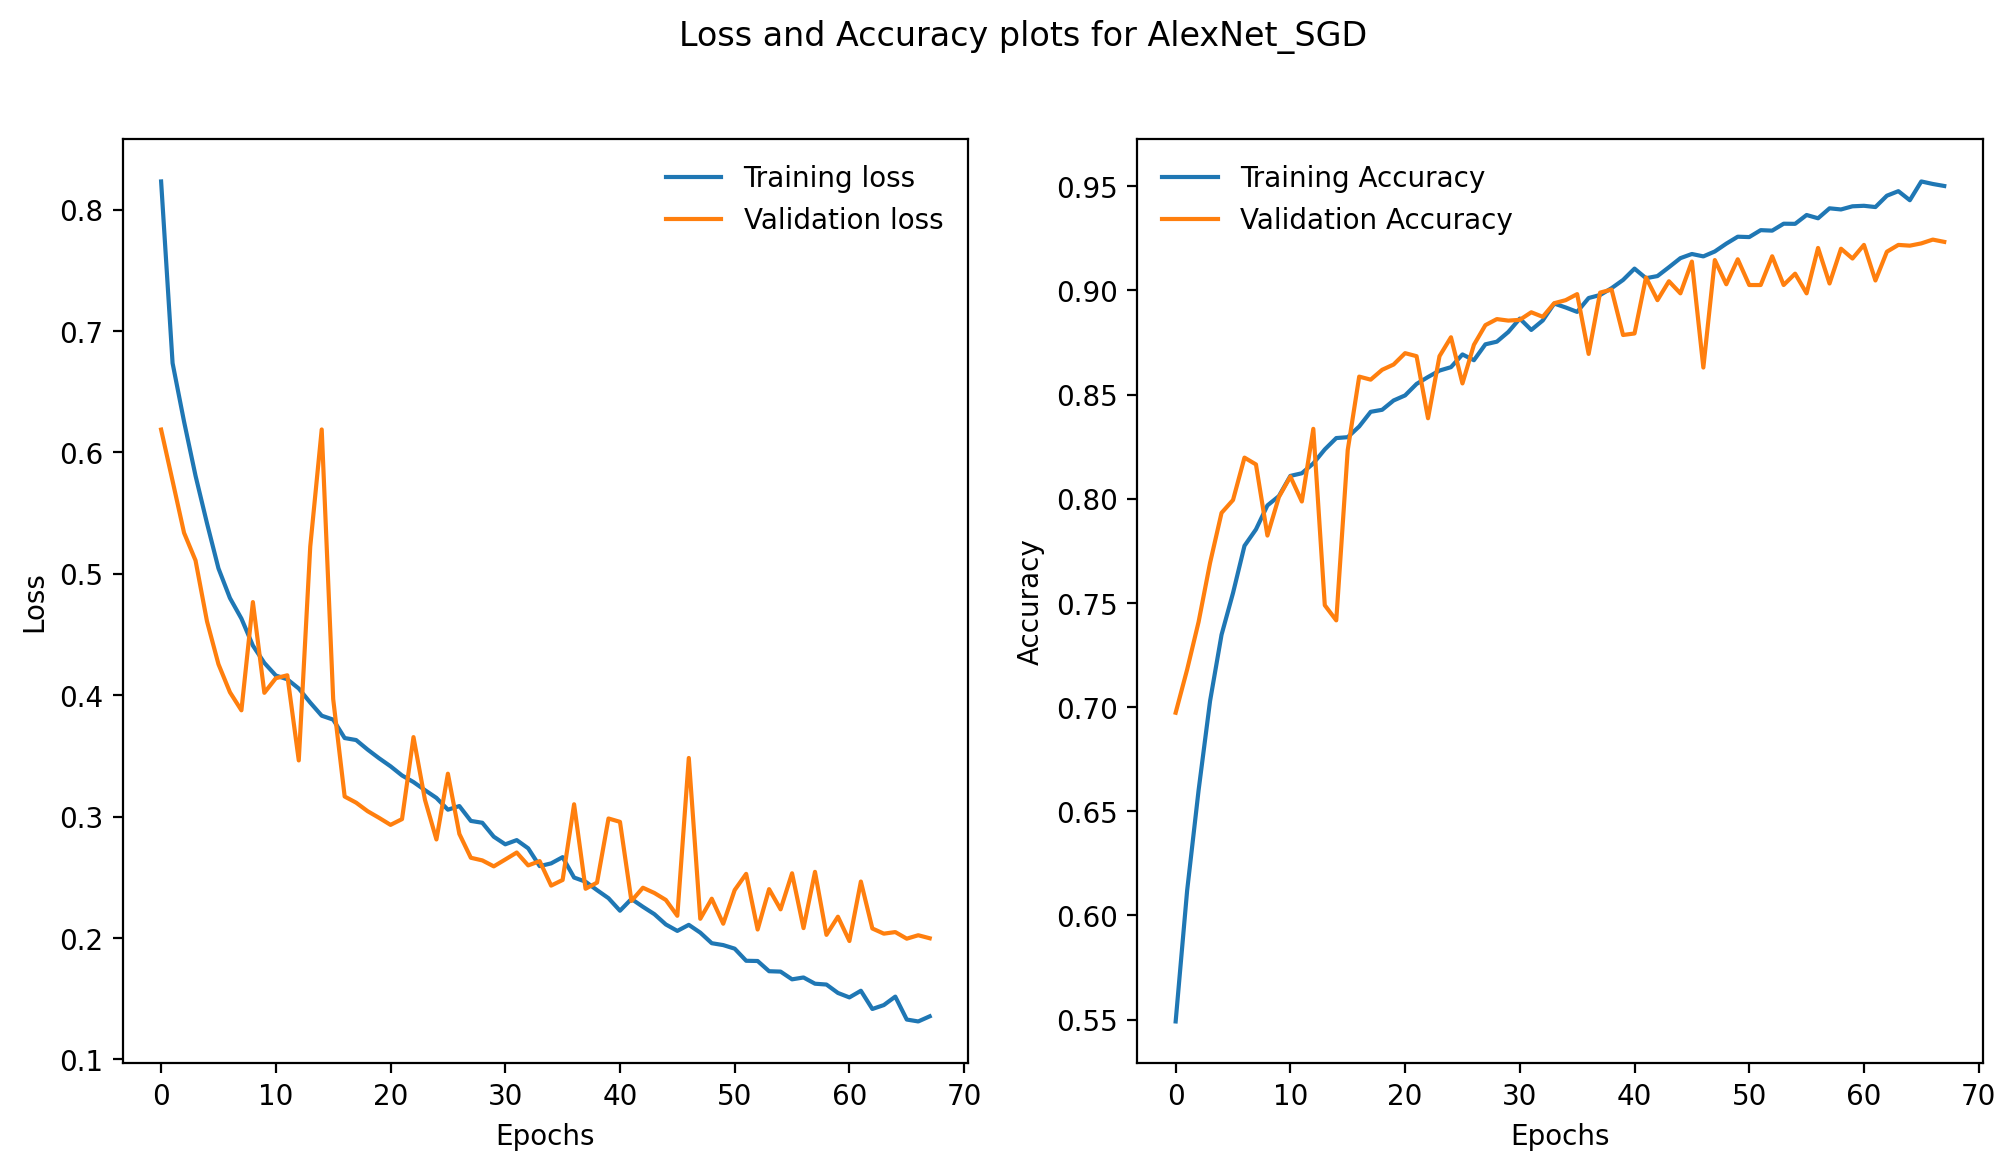

In [ ]:
plot_loss_acc('AlexNet_SGD', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

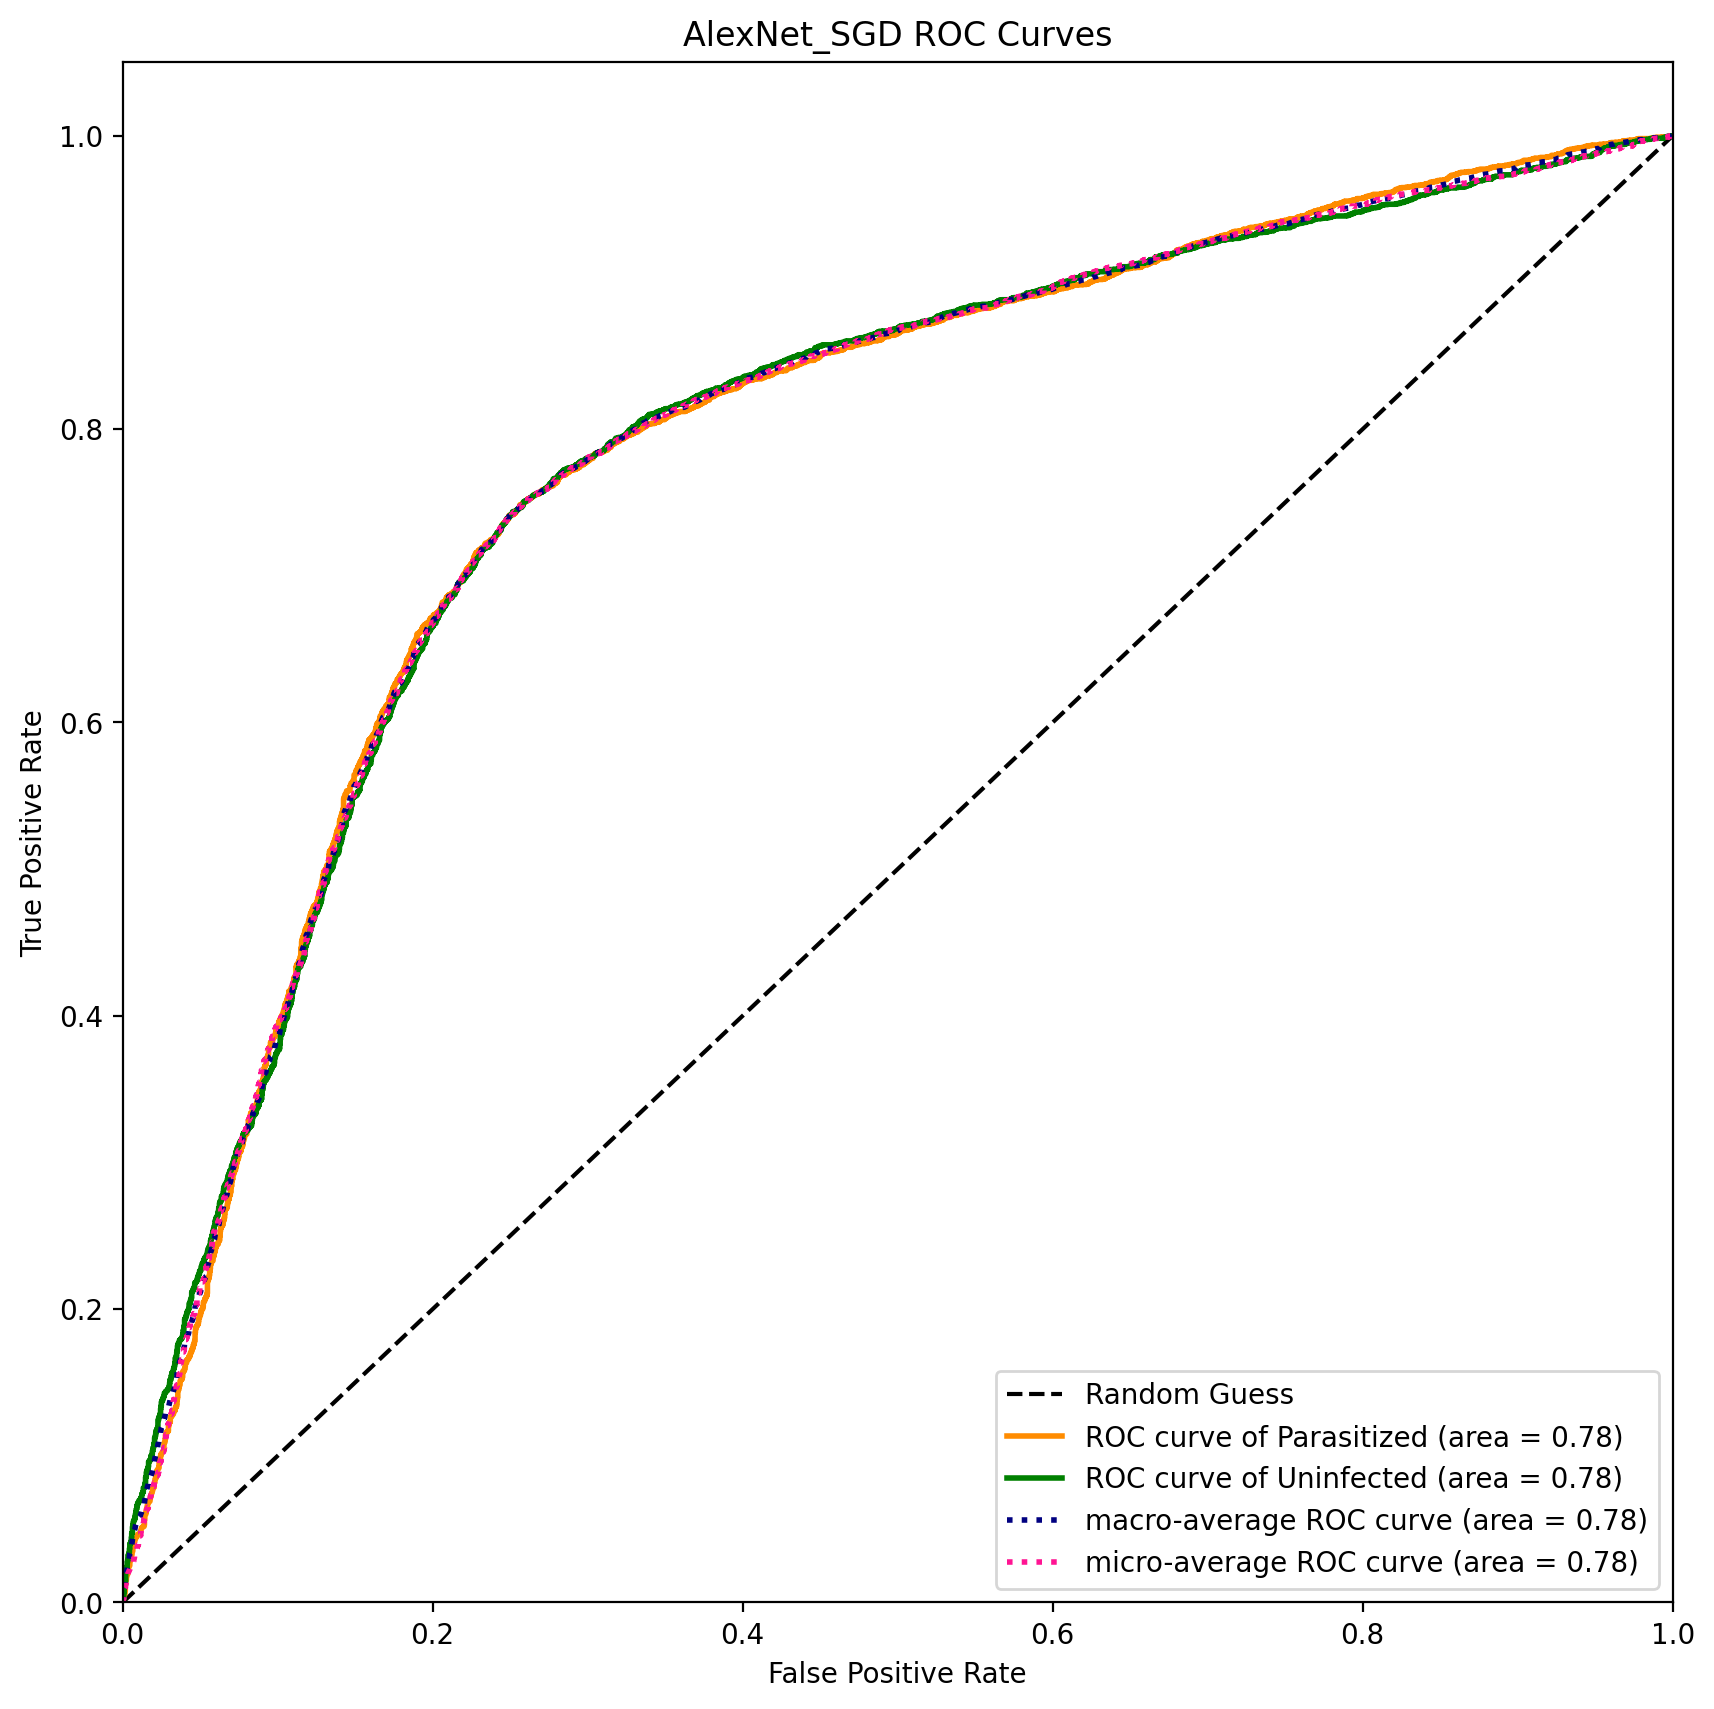

In [ ]:
alexnet_model.load_state_dict(torch.load('AlexNet_SGD.pt'))
alexnet_model.to(device)
images, labels, probs = get_predictions(alexnet_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "AlexNet_SGD")

              precision    recall  f1-score   support

 Parasitized       0.74      0.75      0.75      4133
  Uninfected       0.75      0.74      0.75      4133

    accuracy                           0.75      8266
   macro avg       0.75      0.75      0.75      8266
weighted avg       0.75      0.75      0.75      8266



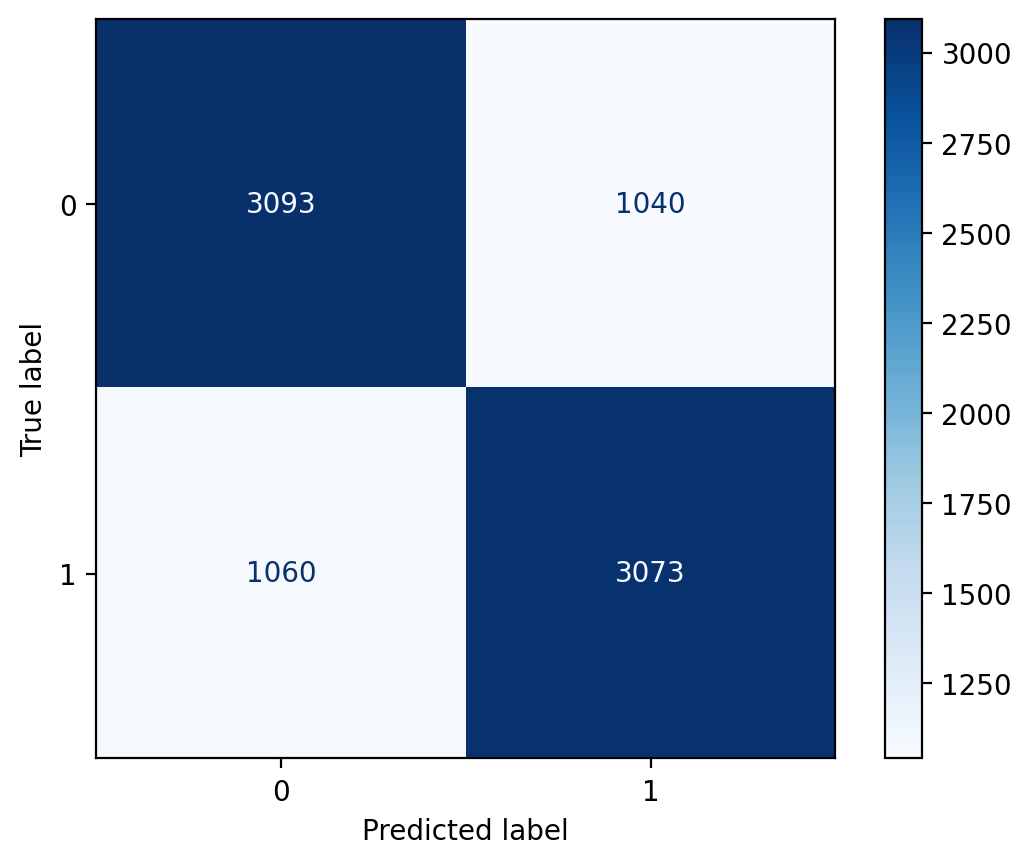

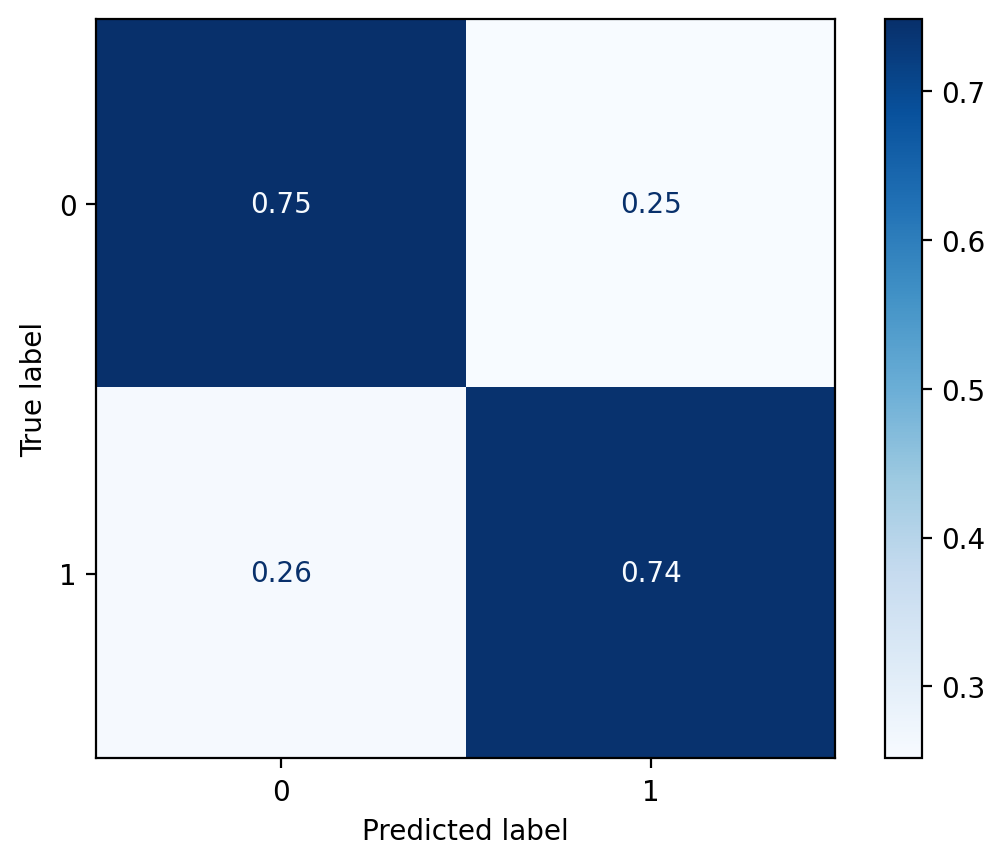

In [ ]:
plot_confusion_matrix(y_test, probs)

### Self-built Architecture (FeeNet)

To construct a customized deep learning architecture, we will iteratively configure and evaluate various model setups, comparing their respective losses to identify the most effective configuration.

1. In the initial step, we will begin with a single Conv2D layer using the following parameters: (input channels=3, output channels=32, kernel size=3).

2. Subsequently, we will augment the output channels in the Conv2D layer from the previous step, adjusting the parameters to: (input channels=3, output channels=64, kernel size=3).

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True), 
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 128))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 246,914 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 0.885 | Train Acc:  66.14% |
	Valid Loss: 0.615 | Valid Acc:  70.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.486 | Train Acc:  77.76% |
	Valid Loss: 0.468 | Valid Acc:  81.18% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.391 | Train Acc:  83.71% |
	Valid Loss: 0.405 | Valid Acc:  82.63% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.307 | Train Acc:  88.09% |
	Valid Loss: 0.433 | Valid Acc:  82.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.265 | Train Acc:  89.77% |
	Valid Loss: 0.381 | Valid Acc:  85.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 0.227 | Train Acc:  91.44% |
	Valid Loss: 0.371 | Valid Acc:  86.66% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.202 | Train Acc:  92.67% |
	Valid Loss: 0.389 | Valid Acc:  85.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 27s
	Train Loss: 0.165 | Train Acc:  93.89% |
	Valid Loss: 0.426 | Valid Acc:  84.41% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.157 | Train Acc:  94.33% |
	Valid Loss: 0.413 | Valid Acc:  86.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.129 | Train Acc:  95.58% |
	Valid Loss: 0.338 | Valid Acc:  88.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 27s
	Train Loss: 0.116 | Train Acc:  96.11% |
	Valid Loss: 0.395 | Valid Acc:  88.01% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 27s
	Train Loss: 0.098 | Train Acc:  96.89% |
	Valid Loss: 0.401 | Valid Acc:  87.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 27s
	Train Loss: 0.093 | Train Acc:  96.86% |
	Valid Loss: 0.347 | Valid Acc:  89.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 27s
	Train Loss: 0.080 | Train Acc:  97.50% |
	Valid Loss: 0.361 | Valid Acc:  89.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 27s
	Train Loss: 0.075 | Train Acc:  97.48% |
	Valid Loss: 0.392 | Valid Acc:  89.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 27s
	Train Loss: 0.062 | Train Acc:  98.09% |
	Valid Loss: 0.400 | Valid Acc:  89.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 27s
	Train Loss: 0.083 | Train Acc:  97.37% |
	Valid Loss: 0.527 | Valid Acc:  85.21% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 10, Best validation accuracy: 0.887718023255814, Best validation loss: 0.3378282251746155


In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True), 
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)


The model has 493,826 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 1.542 | Train Acc:  67.53% |
	Valid Loss: 0.537 | Valid Acc:  76.16% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 0.463 | Train Acc:  80.49% |
	Valid Loss: 0.395 | Valid Acc:  84.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 0.356 | Train Acc:  85.36% |
	Valid Loss: 0.441 | Valid Acc:  82.38% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.256 | Train Acc:  89.93% |
	Valid Loss: 0.376 | Valid Acc:  86.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.231 | Train Acc:  91.19% |
	Valid Loss: 0.442 | Valid Acc:  85.03% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.177 | Train Acc:  93.25% |
	Valid Loss: 0.399 | Valid Acc:  86.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 0.147 | Train Acc:  94.60% |
	Valid Loss: 0.405 | Valid Acc:  88.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.130 | Train Acc:  95.29% |
	Valid Loss: 0.367 | Valid Acc:  88.70% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.109 | Train Acc:  96.34% |
	Valid Loss: 0.399 | Valid Acc:  89.10% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 31s
	Train Loss: 0.094 | Train Acc:  96.95% |
	Valid Loss: 0.453 | Valid Acc:  86.56% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 30s
	Train Loss: 0.094 | Train Acc:  97.01% |
	Valid Loss: 0.392 | Valid Acc:  89.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 30s
	Train Loss: 0.063 | Train Acc:  97.99% |
	Valid Loss: 0.420 | Valid Acc:  89.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 30s
	Train Loss: 0.057 | Train Acc:  98.29% |
	Valid Loss: 0.420 | Valid Acc:  89.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 29s
	Train Loss: 0.055 | Train Acc:  98.24% |
	Valid Loss: 0.437 | Valid Acc:  88.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 29s
	Train Loss: 0.077 | Train Acc:  97.34% |
	Valid Loss: 0.459 | Valid Acc:  86.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 8, Best validation accuracy: 0.8869912790697675, Best validation loss: 0.3668427023776742


    The optimal loss achieved in step 1 is 0.338, whereas in step 2 it is 0.367. This suggests that the output features of 32 outperform that of 64.

3. In the next configuration, we will introduce the "stride" and "padding" parameter in the initial Conv2D layer, utilizing the following specifications: (input channels=3, output channels=32, kernel size=3, stride=2, padding=1).

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 128))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 66,434 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.644 | Train Acc:  68.52% |
	Valid Loss: 0.523 | Valid Acc:  74.85% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.460 | Train Acc:  78.37% |
	Valid Loss: 0.419 | Valid Acc:  81.43% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.367 | Train Acc:  84.36% |
	Valid Loss: 0.391 | Valid Acc:  84.45% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.316 | Train Acc:  87.34% |
	Valid Loss: 0.353 | Valid Acc:  85.50% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.286 | Train Acc:  88.71% |
	Valid Loss: 0.363 | Valid Acc:  85.25% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.267 | Train Acc:  89.55% |
	Valid Loss: 0.358 | Valid Acc:  85.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.238 | Train Acc:  90.90% |
	Valid Loss: 0.354 | Valid Acc:  86.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.221 | Train Acc:  91.74% |
	Valid Loss: 0.329 | Valid Acc:  88.55% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.201 | Train Acc:  92.71% |
	Valid Loss: 0.333 | Valid Acc:  87.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.193 | Train Acc:  92.67% |
	Valid Loss: 0.343 | Valid Acc:  87.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.171 | Train Acc:  93.87% |
	Valid Loss: 0.387 | Valid Acc:  85.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 25s
	Train Loss: 0.161 | Train Acc:  94.50% |
	Valid Loss: 0.310 | Valid Acc:  88.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.145 | Train Acc:  94.91% |
	Valid Loss: 0.334 | Valid Acc:  88.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 23s
	Train Loss: 0.144 | Train Acc:  94.85% |
	Valid Loss: 0.396 | Valid Acc:  87.21% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 23s
	Train Loss: 0.129 | Train Acc:  95.59% |
	Valid Loss: 0.328 | Valid Acc:  89.83% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 23s
	Train Loss: 0.116 | Train Acc:  96.23% |
	Valid Loss: 0.352 | Valid Acc:  89.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 23s
	Train Loss: 0.107 | Train Acc:  96.60% |
	Valid Loss: 0.423 | Valid Acc:  86.81% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 23s
	Train Loss: 0.102 | Train Acc:  96.75% |
	Valid Loss: 0.365 | Valid Acc:  88.81% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 24s
	Train Loss: 0.098 | Train Acc:  96.94% |
	Valid Loss: 0.378 | Valid Acc:  88.63% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 12, Best validation accuracy: 0.889171511627907, Best validation loss: 0.31023395425358485


    After implementing step 3, the optimal loss improved to 0.310, indicating a significant enhancement. Therefore, we will retain this configuration as it outperforms the previous ones.

4. Next, we will introduce a second Conv2D layer into the architecture, incorporating the following parameters: (input channels=32, output channels=64, kernel size=3, padding=1).

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 150,466 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.612 | Train Acc:  69.60% |
	Valid Loss: 0.438 | Valid Acc:  81.87% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.280 | Train Acc:  90.51% |
	Valid Loss: 0.180 | Valid Acc:  94.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.170 | Train Acc:  94.20% |
	Valid Loss: 0.164 | Valid Acc:  95.20% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.143 | Train Acc:  95.26% |
	Valid Loss: 0.153 | Valid Acc:  95.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.126 | Train Acc:  95.69% |
	Valid Loss: 0.150 | Valid Acc:  94.99% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.109 | Train Acc:  96.29% |
	Valid Loss: 0.152 | Valid Acc:  95.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.093 | Train Acc:  96.87% |
	Valid Loss: 0.168 | Valid Acc:  94.44% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 26s
	Train Loss: 0.080 | Train Acc:  97.29% |
	Valid Loss: 0.182 | Valid Acc:  94.30% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.070 | Train Acc:  97.68% |
	Valid Loss: 0.184 | Valid Acc:  94.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 0.056 | Train Acc:  98.16% |
	Valid Loss: 0.188 | Valid Acc:  94.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 28s
	Train Loss: 0.046 | Train Acc:  98.58% |
	Valid Loss: 0.218 | Valid Acc:  94.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 27s
	Train Loss: 0.033 | Train Acc:  99.01% |
	Valid Loss: 0.244 | Valid Acc:  93.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 5, Best validation accuracy: 0.9498546511627907, Best validation loss: 0.1503739437564861


    The introduction of the new Conv2D layer led to an improved best loss of 0.150.

5. Next, we will incorporate a MaxPool2D layer after the first Conv2D layer.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 52,162 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.543 | Train Acc:  72.63% |
	Valid Loss: 0.380 | Valid Acc:  85.65% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.276 | Train Acc:  89.47% |
	Valid Loss: 0.191 | Valid Acc:  93.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.182 | Train Acc:  93.65% |
	Valid Loss: 0.162 | Valid Acc:  94.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.155 | Train Acc:  94.58% |
	Valid Loss: 0.172 | Valid Acc:  94.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.139 | Train Acc:  95.09% |
	Valid Loss: 0.151 | Valid Acc:  95.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.129 | Train Acc:  95.53% |
	Valid Loss: 0.149 | Valid Acc:  95.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.117 | Train Acc:  95.80% |
	Valid Loss: 0.151 | Valid Acc:  94.91% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.108 | Train Acc:  96.23% |
	Valid Loss: 0.153 | Valid Acc:  95.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.099 | Train Acc:  96.57% |
	Valid Loss: 0.172 | Valid Acc:  95.02% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.089 | Train Acc:  96.80% |
	Valid Loss: 0.168 | Valid Acc:  95.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 24s
	Train Loss: 0.082 | Train Acc:  97.13% |
	Valid Loss: 0.169 | Valid Acc:  95.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 25s
	Train Loss: 0.075 | Train Acc:  97.37% |
	Valid Loss: 0.171 | Valid Acc:  95.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.064 | Train Acc:  97.73% |
	Valid Loss: 0.181 | Valid Acc:  94.91% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 6, Best validation accuracy: 0.9571220930232558, Best validation loss: 0.14912237040698528


    The addition of the MaxPool2D layer resulted in a further improvement of the best loss to 0.149.

6. Next, we will include a MaxPool2D layer after the second Conv2D layer and compare the results with the configuration containing only one MaxPool layer.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 27,586 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.528 | Train Acc:  74.27% |
	Valid Loss: 0.305 | Valid Acc:  89.50% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.221 | Train Acc:  92.43% |
	Valid Loss: 0.169 | Valid Acc:  94.88% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.164 | Train Acc:  94.49% |
	Valid Loss: 0.158 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.149 | Train Acc:  95.00% |
	Valid Loss: 0.151 | Valid Acc:  95.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.136 | Train Acc:  95.41% |
	Valid Loss: 0.143 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.128 | Train Acc:  95.75% |
	Valid Loss: 0.141 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.124 | Train Acc:  95.70% |
	Valid Loss: 0.144 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.113 | Train Acc:  96.12% |
	Valid Loss: 0.146 | Valid Acc:  95.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.108 | Train Acc:  96.44% |
	Valid Loss: 0.142 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.103 | Train Acc:  96.43% |
	Valid Loss: 0.148 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.097 | Train Acc:  96.61% |
	Valid Loss: 0.156 | Valid Acc:  95.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 24s
	Train Loss: 0.092 | Train Acc:  96.71% |
	Valid Loss: 0.141 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.086 | Train Acc:  96.93% |
	Valid Loss: 0.148 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 6, Best validation accuracy: 0.9600290697674418, Best validation loss: 0.14143692302452618


    After incorporating a MaxPool2D layer after the second Conv2D layer, the loss further improved to 0.141.

7. Next, we will introduce a dropout layer with a dropout rate of 0.2 before the MaxPool layers.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 27,586 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.510 | Train Acc:  75.30% |
	Valid Loss: 0.277 | Valid Acc:  91.13% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.208 | Train Acc:  92.49% |
	Valid Loss: 0.159 | Valid Acc:  95.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.164 | Train Acc:  94.26% |
	Valid Loss: 0.149 | Valid Acc:  95.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.157 | Train Acc:  94.71% |
	Valid Loss: 0.144 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.148 | Train Acc:  94.99% |
	Valid Loss: 0.149 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.140 | Train Acc:  95.05% |
	Valid Loss: 0.144 | Valid Acc:  95.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.136 | Train Acc:  95.46% |
	Valid Loss: 0.143 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.130 | Train Acc:  95.48% |
	Valid Loss: 0.146 | Valid Acc:  95.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.127 | Train Acc:  95.59% |
	Valid Loss: 0.141 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.125 | Train Acc:  95.77% |
	Valid Loss: 0.143 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 27s
	Train Loss: 0.116 | Train Acc:  95.97% |
	Valid Loss: 0.150 | Valid Acc:  95.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 25s
	Train Loss: 0.116 | Train Acc:  95.71% |
	Valid Loss: 0.147 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.112 | Train Acc:  96.15% |
	Valid Loss: 0.147 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.105 | Train Acc:  96.29% |
	Valid Loss: 0.143 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 25s
	Train Loss: 0.105 | Train Acc:  96.41% |
	Valid Loss: 0.143 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 27s
	Train Loss: 0.102 | Train Acc:  96.49% |
	Valid Loss: 0.144 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 9, Best validation accuracy: 0.9614825581395349, Best validation loss: 0.1407121017380336


    The inclusion of a dropout layer before the MaxPool layer kept the best loss still at 0.141.

8. As the next step, we will attempt a dropout layer after the MaxPool layers and compare its performance with step 7.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 27,586 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 0.511 | Train Acc:  74.07% |
	Valid Loss: 0.241 | Valid Acc:  91.32% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.211 | Train Acc:  92.55% |
	Valid Loss: 0.162 | Valid Acc:  94.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.172 | Train Acc:  94.15% |
	Valid Loss: 0.147 | Valid Acc:  95.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.156 | Train Acc:  94.72% |
	Valid Loss: 0.143 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.150 | Train Acc:  94.92% |
	Valid Loss: 0.141 | Valid Acc:  95.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 0.146 | Train Acc:  95.04% |
	Valid Loss: 0.143 | Valid Acc:  95.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.137 | Train Acc:  95.37% |
	Valid Loss: 0.143 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.136 | Train Acc:  95.29% |
	Valid Loss: 0.152 | Valid Acc:  95.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.130 | Train Acc:  95.49% |
	Valid Loss: 0.142 | Valid Acc:  95.57% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.127 | Train Acc:  95.63% |
	Valid Loss: 0.142 | Valid Acc:  95.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.121 | Train Acc:  95.88% |
	Valid Loss: 0.138 | Valid Acc:  95.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 24s
	Train Loss: 0.119 | Train Acc:  95.80% |
	Valid Loss: 0.142 | Valid Acc:  95.39% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 25s
	Train Loss: 0.115 | Train Acc:  95.91% |
	Valid Loss: 0.138 | Valid Acc:  95.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.110 | Train Acc:  96.11% |
	Valid Loss: 0.143 | Valid Acc:  95.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 25s
	Train Loss: 0.109 | Train Acc:  96.08% |
	Valid Loss: 0.142 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 25s
	Train Loss: 0.111 | Train Acc:  96.21% |
	Valid Loss: 0.144 | Valid Acc:  95.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 24s
	Train Loss: 0.102 | Train Acc:  96.37% |
	Valid Loss: 0.143 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 24s
	Train Loss: 0.099 | Train Acc:  96.37% |
	Valid Loss: 0.147 | Valid Acc:  95.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 11, Best validation accuracy: 0.9567587209302325, Best validation loss: 0.13816551919376782


    The addition of a dropout layer after the MaxPool layers further improved the loss to 0.138. We will proceed to test the combination of dropout and batch normalization.

9. In the next step, we will introduce batch normalization in the first Conv2D layer, in the configuration that previously included dropout after the MaxPool layer.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 27,650 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.498 | Train Acc:  75.42% |
	Valid Loss: 0.232 | Valid Acc:  91.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.240 | Train Acc:  91.89% |
	Valid Loss: 0.178 | Valid Acc:  94.40% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.195 | Train Acc:  93.94% |
	Valid Loss: 0.165 | Valid Acc:  94.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.176 | Train Acc:  94.15% |
	Valid Loss: 0.160 | Valid Acc:  95.60% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.166 | Train Acc:  94.49% |
	Valid Loss: 0.160 | Valid Acc:  95.24% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.158 | Train Acc:  94.94% |
	Valid Loss: 0.160 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.142 | Train Acc:  95.24% |
	Valid Loss: 0.155 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.142 | Train Acc:  95.20% |
	Valid Loss: 0.159 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 0.134 | Train Acc:  95.37% |
	Valid Loss: 0.152 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.129 | Train Acc:  95.57% |
	Valid Loss: 0.159 | Valid Acc:  95.13% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.129 | Train Acc:  95.67% |
	Valid Loss: 0.165 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 25s
	Train Loss: 0.118 | Train Acc:  95.95% |
	Valid Loss: 0.150 | Valid Acc:  95.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 25s
	Train Loss: 0.115 | Train Acc:  96.04% |
	Valid Loss: 0.158 | Valid Acc:  95.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.114 | Train Acc:  96.14% |
	Valid Loss: 0.156 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 25s
	Train Loss: 0.108 | Train Acc:  96.38% |
	Valid Loss: 0.161 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 25s
	Train Loss: 0.107 | Train Acc:  96.24% |
	Valid Loss: 0.175 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 25s
	Train Loss: 0.103 | Train Acc:  96.43% |
	Valid Loss: 0.164 | Valid Acc:  95.24% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 25s
	Train Loss: 0.097 | Train Acc:  96.62% |
	Valid Loss: 0.170 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 25s
	Train Loss: 0.096 | Train Acc:  96.77% |
	Valid Loss: 0.166 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 12, Best validation accuracy: 0.9567587209302325, Best validation loss: 0.15049717208197297


    The addition of the batch normalization layer in step 9 did not result in an improved loss, as it increased to 0.150 compared to the loss at step 8.

10. In the next step, we will introduce batch normalization to the second Conv2D layer and compare.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 27,778 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.470 | Train Acc:  78.05% |
	Valid Loss: 0.211 | Valid Acc:  92.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 0.236 | Train Acc:  91.42% |
	Valid Loss: 0.190 | Valid Acc:  94.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 0.200 | Train Acc:  93.33% |
	Valid Loss: 0.178 | Valid Acc:  95.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.180 | Train Acc:  94.08% |
	Valid Loss: 0.161 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.166 | Train Acc:  94.69% |
	Valid Loss: 0.159 | Valid Acc:  95.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.158 | Train Acc:  94.75% |
	Valid Loss: 0.150 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.145 | Train Acc:  95.03% |
	Valid Loss: 0.155 | Valid Acc:  95.24% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 26s
	Train Loss: 0.144 | Train Acc:  95.30% |
	Valid Loss: 0.144 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.130 | Train Acc:  95.64% |
	Valid Loss: 0.154 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.133 | Train Acc:  95.52% |
	Valid Loss: 0.148 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 24s
	Train Loss: 0.130 | Train Acc:  95.50% |
	Valid Loss: 0.158 | Valid Acc:  95.20% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 24s
	Train Loss: 0.127 | Train Acc:  95.68% |
	Valid Loss: 0.157 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.120 | Train Acc:  95.97% |
	Valid Loss: 0.156 | Valid Acc:  95.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.119 | Train Acc:  95.83% |
	Valid Loss: 0.148 | Valid Acc:  95.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 26s
	Train Loss: 0.112 | Train Acc:  96.21% |
	Valid Loss: 0.152 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 8, Best validation accuracy: 0.9614825581395349, Best validation loss: 0.14365713490135318


    The inclusion of the batch normalization layer in the second Conv2D layer resulted in a improvement of loss to 0.144 over step 9, but not beating the best loss so far of 0.138. We'll take out the BatchNorm layer from the architecture going forward.

11. Next, we will add in a third layer of conv + maxpool + dropout

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 175,298 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.392 | Train Acc:  80.75% |
	Valid Loss: 0.172 | Valid Acc:  94.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.171 | Train Acc:  94.54% |
	Valid Loss: 0.140 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.152 | Train Acc:  94.94% |
	Valid Loss: 0.159 | Valid Acc:  95.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.147 | Train Acc:  95.22% |
	Valid Loss: 0.136 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.140 | Train Acc:  95.26% |
	Valid Loss: 0.135 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.133 | Train Acc:  95.45% |
	Valid Loss: 0.131 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.126 | Train Acc:  95.78% |
	Valid Loss: 0.135 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.123 | Train Acc:  95.75% |
	Valid Loss: 0.131 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.117 | Train Acc:  95.98% |
	Valid Loss: 0.132 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 19s
	Train Loss: 0.111 | Train Acc:  96.07% |
	Valid Loss: 0.133 | Valid Acc:  95.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 19s
	Train Loss: 0.104 | Train Acc:  96.46% |
	Valid Loss: 0.138 | Valid Acc:  95.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 20s
	Train Loss: 0.098 | Train Acc:  96.58% |
	Valid Loss: 0.136 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 20s
	Train Loss: 0.091 | Train Acc:  96.82% |
	Valid Loss: 0.136 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 6, Best validation accuracy: 0.9589389534883721, Best validation loss: 0.1306792421504682


    The inclusion of the third layer resulted to a best optimal loss of 0.131, with an accuracy of 96%. We'll use this model going forward.

12. Next, we will test for 2 and 3 fully connected linear layers and compare the results.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 16,956,610 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 0.424 | Train Acc:  78.46% |
	Valid Loss: 0.171 | Valid Acc:  94.55% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 0.167 | Train Acc:  94.81% |
	Valid Loss: 0.139 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.144 | Train Acc:  95.42% |
	Valid Loss: 0.135 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.137 | Train Acc:  95.77% |
	Valid Loss: 0.129 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.132 | Train Acc:  95.85% |
	Valid Loss: 0.139 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 0.126 | Train Acc:  96.01% |
	Valid Loss: 0.121 | Valid Acc:  96.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.126 | Train Acc:  95.86% |
	Valid Loss: 0.119 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 0.120 | Train Acc:  96.08% |
	Valid Loss: 0.126 | Valid Acc:  96.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.117 | Train Acc:  96.05% |
	Valid Loss: 0.123 | Valid Acc:  96.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.114 | Train Acc:  96.23% |
	Valid Loss: 0.119 | Valid Acc:  96.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 28s
	Train Loss: 0.109 | Train Acc:  96.42% |
	Valid Loss: 0.122 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 28s
	Train Loss: 0.103 | Train Acc:  96.43% |
	Valid Loss: 0.118 | Valid Acc:  96.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 30s
	Train Loss: 0.101 | Train Acc:  96.51% |
	Valid Loss: 0.121 | Valid Acc:  96.37% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 28s
	Train Loss: 0.096 | Train Acc:  96.73% |
	Valid Loss: 0.125 | Valid Acc:  96.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 33s
	Train Loss: 0.091 | Train Acc:  96.75% |
	Valid Loss: 0.119 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 29s
	Train Loss: 0.093 | Train Acc:  96.80% |
	Valid Loss: 0.124 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 30s
	Train Loss: 0.085 | Train Acc:  96.86% |
	Valid Loss: 0.130 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 30s
	Train Loss: 0.083 | Train Acc:  96.99% |
	Valid Loss: 0.126 | Valid Acc:  96.22% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 30s
	Train Loss: 0.076 | Train Acc:  97.32% |
	Valid Loss: 0.144 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 12, Best validation accuracy: 0.9632994186046512, Best validation loss: 0.11797251812247343


    The inclusion of a second linear layer improved the loss to 0.118. We'll run a model with 3 Linear Layers and see if we can get a better result.

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=2048, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 25,343,170 trainable parameters


In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.419 | Train Acc:  79.28% |
	Valid Loss: 0.160 | Valid Acc:  94.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.168 | Train Acc:  94.67% |
	Valid Loss: 0.142 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.152 | Train Acc:  95.05% |
	Valid Loss: 0.136 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.143 | Train Acc:  95.46% |
	Valid Loss: 0.125 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.137 | Train Acc:  95.62% |
	Valid Loss: 0.137 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.132 | Train Acc:  95.71% |
	Valid Loss: 0.127 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 0.126 | Train Acc:  95.95% |
	Valid Loss: 0.128 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 31s
	Train Loss: 0.120 | Train Acc:  95.98% |
	Valid Loss: 0.136 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.117 | Train Acc:  96.10% |
	Valid Loss: 0.133 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.111 | Train Acc:  96.36% |
	Valid Loss: 0.124 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 33s
	Train Loss: 0.110 | Train Acc:  96.24% |
	Valid Loss: 0.126 | Valid Acc:  96.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 36s
	Train Loss: 0.106 | Train Acc:  96.50% |
	Valid Loss: 0.122 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 33s
	Train Loss: 0.098 | Train Acc:  96.68% |
	Valid Loss: 0.148 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 33s
	Train Loss: 0.096 | Train Acc:  96.72% |
	Valid Loss: 0.123 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 36s
	Train Loss: 0.088 | Train Acc:  96.88% |
	Valid Loss: 0.138 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 37s
	Train Loss: 0.087 | Train Acc:  96.98% |
	Valid Loss: 0.136 | Valid Acc:  95.89% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 33s
	Train Loss: 0.083 | Train Acc:  97.11% |
	Valid Loss: 0.137 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 39s
	Train Loss: 0.078 | Train Acc:  97.18% |
	Valid Loss: 0.144 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 40s
	Train Loss: 0.078 | Train Acc:  97.30% |
	Valid Loss: 0.146 | Valid Acc:  96.00% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 12, Best validation accuracy: 0.9600290697674418, Best validation loss: 0.12217630029569358


    The inclusion of the third layer seems to deteriorate the performance of the model. Hence we'll utilise the architecture with 2 FC layers and this will make up the architecture of our custom CNN FeeNet.

#### Testing FeeNet on new data

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 16,956,610 trainable parameters


In [ ]:
summary(feenet_model, input_size=(batch_size, 3, 64, 64), col_names=("input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                "mult_adds",
                "trainable",))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
FeeNet                                   [64, 3, 64, 64]           [64, 2]                   --                             --                   --                        --                        True
├─Sequential: 1-1                        [64, 3, 64, 64]           [64, 256, 4, 4]           --                             --                   --                        --                        True
│    └─Conv2d: 2-1                       [64, 3, 64, 64]           [64, 32, 32, 32]          896                         0.01%                   [3, 3]                    58,720,256                True
│    └─ReLU: 2-2                         [64, 32, 32, 32]          [64, 32, 32, 32]          --                             --                   --                        --              

In [ ]:
adam_optimizer = optim.Adam(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, adam_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.424 | Train Acc:  78.42% |
	Valid Loss: 0.179 | Valid Acc:  93.79% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.177 | Train Acc:  94.13% |
	Valid Loss: 0.143 | Valid Acc:  95.46% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.156 | Train Acc:  95.12% |
	Valid Loss: 0.134 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.142 | Train Acc:  95.47% |
	Valid Loss: 0.131 | Valid Acc:  95.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 0.137 | Train Acc:  95.65% |
	Valid Loss: 0.129 | Valid Acc:  96.15% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.126 | Train Acc:  95.82% |
	Valid Loss: 0.127 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.124 | Train Acc:  95.96% |
	Valid Loss: 0.121 | Valid Acc:  95.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.120 | Train Acc:  96.03% |
	Valid Loss: 0.116 | Valid Acc:  96.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.113 | Train Acc:  96.23% |
	Valid Loss: 0.119 | Valid Acc:  96.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.111 | Train Acc:  96.18% |
	Valid Loss: 0.117 | Valid Acc:  96.29% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 27s
	Train Loss: 0.103 | Train Acc:  96.29% |
	Valid Loss: 0.136 | Valid Acc:  96.08% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 26s
	Train Loss: 0.104 | Train Acc:  96.46% |
	Valid Loss: 0.126 | Valid Acc:  95.86% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 26s
	Train Loss: 0.098 | Train Acc:  96.63% |
	Valid Loss: 0.134 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 26s
	Train Loss: 0.094 | Train Acc:  96.69% |
	Valid Loss: 0.127 | Valid Acc:  95.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 26s
	Train Loss: 0.087 | Train Acc:  96.88% |
	Valid Loss: 0.124 | Valid Acc:  96.40% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Validation loss hasn't improved in 8 epochs. Stopping early.
Best epoch: 8, Best validation accuracy: 0.9611191860465116, Best validation loss: 0.11597553856107731


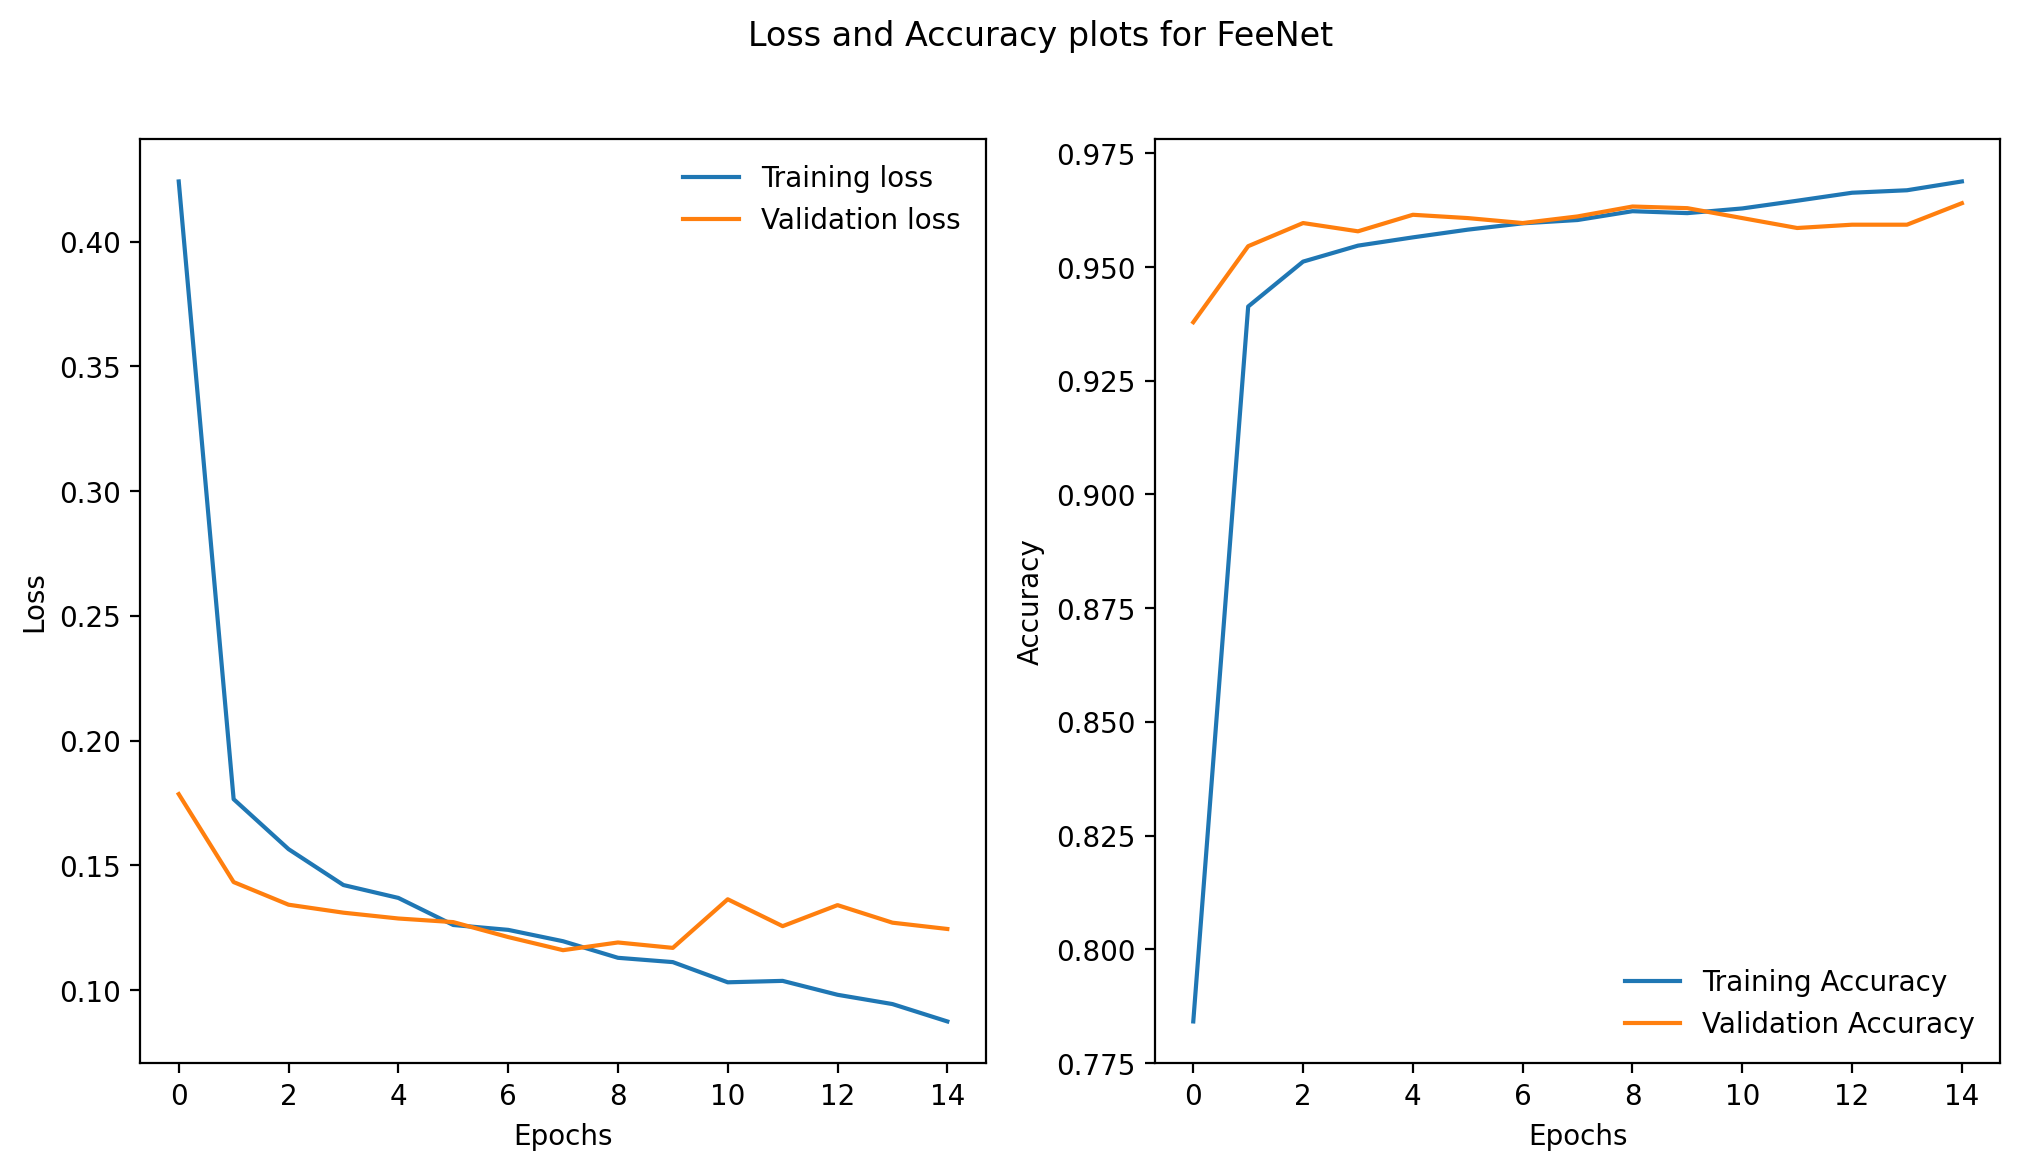

In [ ]:
plot_loss_acc('FeeNet', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

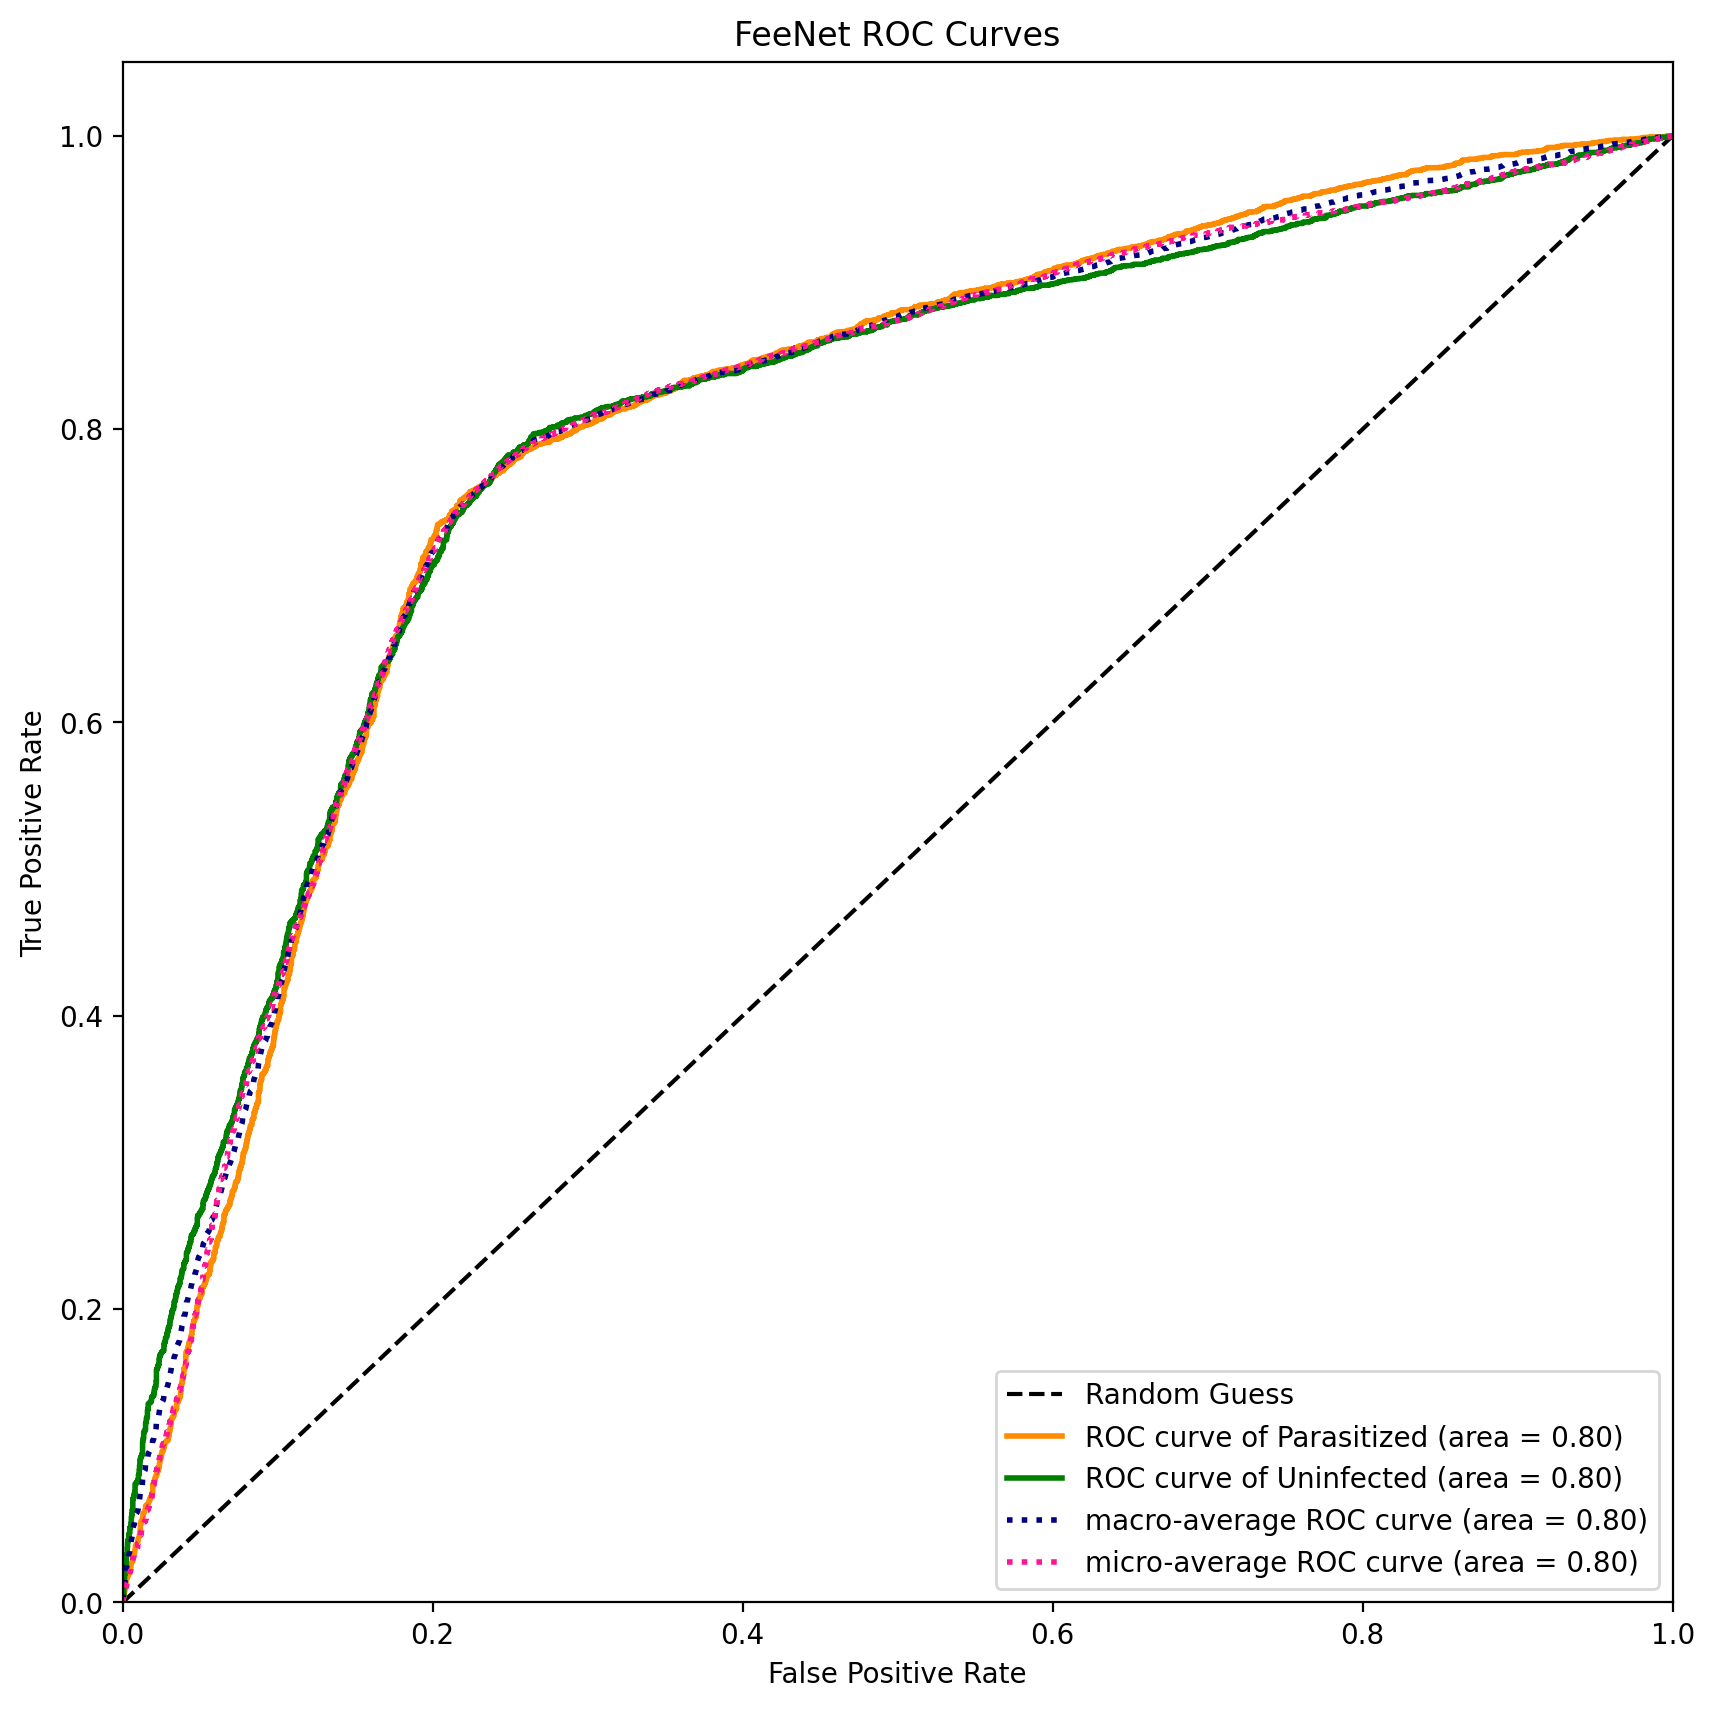

In [ ]:
feenet_model.load_state_dict(torch.load('FeeNet_Adam.pt'))
feenet_model.to(device)
images, labels, probs = get_predictions(feenet_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "FeeNet")

              precision    recall  f1-score   support

 Parasitized       0.77      0.76      0.76      4133
  Uninfected       0.76      0.77      0.77      4133

    accuracy                           0.77      8266
   macro avg       0.77      0.77      0.77      8266
weighted avg       0.77      0.77      0.77      8266



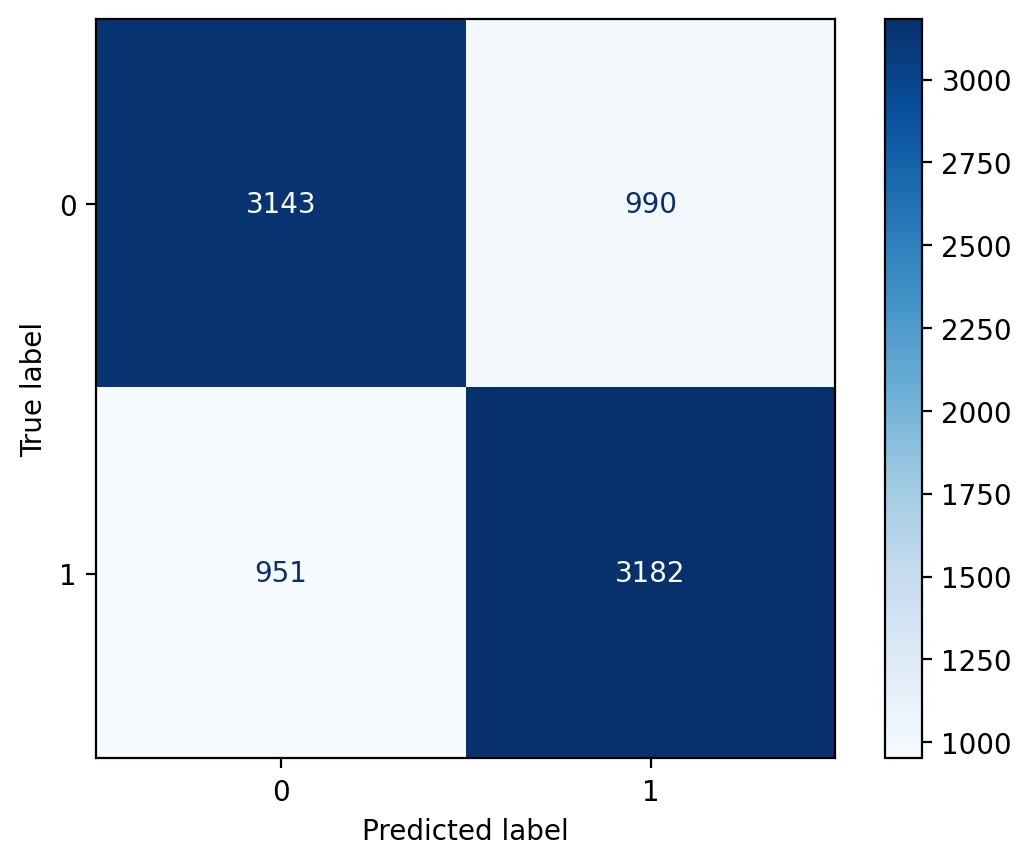

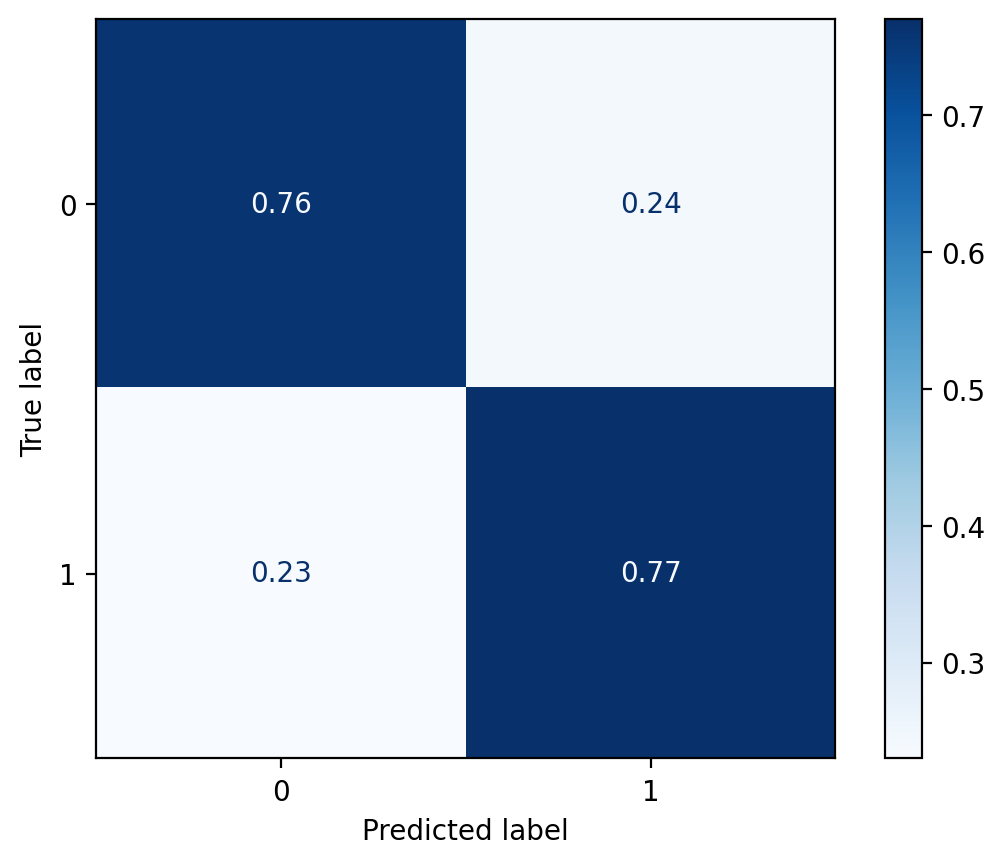

In [ ]:
plot_confusion_matrix(y_test, probs)

#### FeeNet with SGD as Optimizer

In [ ]:
class FeeNet(nn.Module): 
    def __init__(self, input_size: int, num_classes: int): 
        super(FeeNet, self).__init__() 

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2),
            
        )

        in_features = torch.randn(1, 3, input_size, input_size)
        out_features = self.features(in_features).view(1, -1).size(1)
        hxw = int(np.sqrt(out_features / 256))
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * hxw * hxw, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes)
        )
         
    def forward(self, x): 
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x) 
        return x

In [ ]:
feenet_model = FeeNet(64, 2)
count_parameters(feenet_model)

The model has 16,956,610 trainable parameters


In [ ]:
sgd_optimizer = optim.SGD(feenet_model.parameters(), lr=1e-3)
train_accuracy, valid_accuracy, train_losses, valid_losses = train_eval(100, feenet_model, sgd_optimizer, None)

EPOCHS:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.693 | Train Acc:  51.25% |
	Valid Loss: 0.692 | Valid Acc:  55.52% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 0.691 | Train Acc:  55.67% |
	Valid Loss: 0.690 | Valid Acc:  64.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 0.690 | Train Acc:  56.58% |
	Valid Loss: 0.688 | Valid Acc:  63.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.689 | Train Acc:  58.66% |
	Valid Loss: 0.686 | Valid Acc:  65.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.687 | Train Acc:  59.31% |
	Valid Loss: 0.684 | Valid Acc:  66.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.685 | Train Acc:  60.28% |
	Valid Loss: 0.682 | Valid Acc:  66.10% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 0.683 | Train Acc:  60.83% |
	Valid Loss: 0.679 | Valid Acc:  66.24% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.682 | Train Acc:  60.30% |
	Valid Loss: 0.676 | Valid Acc:  66.10% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.679 | Train Acc:  60.76% |
	Valid Loss: 0.672 | Valid Acc:  66.13% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.676 | Train Acc:  60.89% |
	Valid Loss: 0.668 | Valid Acc:  66.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 0.672 | Train Acc:  61.81% |
	Valid Loss: 0.663 | Valid Acc:  66.21% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 0.669 | Train Acc:  61.62% |
	Valid Loss: 0.658 | Valid Acc:  66.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 21s
	Train Loss: 0.665 | Train Acc:  62.11% |
	Valid Loss: 0.652 | Valid Acc:  66.06% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 0.661 | Train Acc:  61.94% |
	Valid Loss: 0.647 | Valid Acc:  66.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 0.658 | Train Acc:  62.52% |
	Valid Loss: 0.641 | Valid Acc:  65.66% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 22s
	Train Loss: 0.654 | Train Acc:  62.70% |
	Valid Loss: 0.636 | Valid Acc:  66.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 21s
	Train Loss: 0.648 | Train Acc:  63.41% |
	Valid Loss: 0.630 | Valid Acc:  66.79% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 22s
	Train Loss: 0.646 | Train Acc:  63.62% |
	Valid Loss: 0.626 | Valid Acc:  66.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 0.642 | Train Acc:  63.70% |
	Valid Loss: 0.622 | Valid Acc:  67.51% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 21s
	Train Loss: 0.640 | Train Acc:  64.22% |
	Valid Loss: 0.618 | Valid Acc:  67.73% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 21s
	Train Loss: 0.637 | Train Acc:  64.30% |
	Valid Loss: 0.614 | Valid Acc:  67.91% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 21s
	Train Loss: 0.632 | Train Acc:  65.38% |
	Valid Loss: 0.609 | Valid Acc:  68.13% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 23s
	Train Loss: 0.627 | Train Acc:  65.96% |
	Valid Loss: 0.605 | Valid Acc:  68.35% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 34s
	Train Loss: 0.624 | Train Acc:  66.59% |
	Valid Loss: 0.600 | Valid Acc:  68.82% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 34s
	Train Loss: 0.621 | Train Acc:  66.58% |
	Valid Loss: 0.595 | Valid Acc:  69.22% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 34s
	Train Loss: 0.615 | Train Acc:  67.42% |
	Valid Loss: 0.590 | Valid Acc:  69.66% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 32s
	Train Loss: 0.609 | Train Acc:  67.88% |
	Valid Loss: 0.584 | Valid Acc:  70.09% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 28s
	Train Loss: 0.606 | Train Acc:  68.44% |
	Valid Loss: 0.579 | Valid Acc:  70.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 28s
	Train Loss: 0.600 | Train Acc:  69.03% |
	Valid Loss: 0.574 | Valid Acc:  70.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 28s
	Train Loss: 0.595 | Train Acc:  69.62% |
	Valid Loss: 0.568 | Valid Acc:  71.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 28s
	Train Loss: 0.591 | Train Acc:  69.67% |
	Valid Loss: 0.562 | Valid Acc:  71.66% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 28s
	Train Loss: 0.587 | Train Acc:  70.48% |
	Valid Loss: 0.557 | Valid Acc:  71.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 29s
	Train Loss: 0.581 | Train Acc:  70.63% |
	Valid Loss: 0.552 | Valid Acc:  72.71% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 29s
	Train Loss: 0.575 | Train Acc:  71.26% |
	Valid Loss: 0.546 | Valid Acc:  72.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 28s
	Train Loss: 0.567 | Train Acc:  71.85% |
	Valid Loss: 0.541 | Valid Acc:  73.36% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 33s
	Train Loss: 0.566 | Train Acc:  72.28% |
	Valid Loss: 0.536 | Valid Acc:  73.84% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 36s
	Train Loss: 0.562 | Train Acc:  72.47% |
	Valid Loss: 0.531 | Valid Acc:  74.38% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 32s
	Train Loss: 0.556 | Train Acc:  73.03% |
	Valid Loss: 0.527 | Valid Acc:  74.85% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 32s
	Train Loss: 0.554 | Train Acc:  73.00% |
	Valid Loss: 0.522 | Valid Acc:  75.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 33s
	Train Loss: 0.549 | Train Acc:  73.46% |
	Valid Loss: 0.518 | Valid Acc:  75.33% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 33s
	Train Loss: 0.543 | Train Acc:  74.07% |
	Valid Loss: 0.515 | Valid Acc:  76.09% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 33s
	Train Loss: 0.541 | Train Acc:  74.36% |
	Valid Loss: 0.510 | Valid Acc:  76.16% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 33s
	Train Loss: 0.539 | Train Acc:  74.38% |
	Valid Loss: 0.506 | Valid Acc:  76.53% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 33s
	Train Loss: 0.534 | Train Acc:  74.69% |
	Valid Loss: 0.502 | Valid Acc:  76.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 33s
	Train Loss: 0.528 | Train Acc:  75.10% |
	Valid Loss: 0.498 | Valid Acc:  76.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 33s
	Train Loss: 0.528 | Train Acc:  75.30% |
	Valid Loss: 0.494 | Valid Acc:  77.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 33s
	Train Loss: 0.524 | Train Acc:  75.55% |
	Valid Loss: 0.490 | Valid Acc:  77.58% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 37s
	Train Loss: 0.519 | Train Acc:  75.68% |
	Valid Loss: 0.487 | Valid Acc:  77.54% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 34s
	Train Loss: 0.516 | Train Acc:  76.08% |
	Valid Loss: 0.482 | Valid Acc:  77.87% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 33s
	Train Loss: 0.513 | Train Acc:  76.06% |
	Valid Loss: 0.477 | Valid Acc:  78.52% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 0m 33s
	Train Loss: 0.508 | Train Acc:  76.58% |
	Valid Loss: 0.473 | Valid Acc:  78.52% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 33s
	Train Loss: 0.505 | Train Acc:  76.87% |
	Valid Loss: 0.468 | Valid Acc:  78.16% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 0m 33s
	Train Loss: 0.500 | Train Acc:  77.11% |
	Valid Loss: 0.463 | Valid Acc:  78.78% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 33s
	Train Loss: 0.496 | Train Acc:  77.31% |
	Valid Loss: 0.458 | Valid Acc:  78.49% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 0m 33s
	Train Loss: 0.491 | Train Acc:  77.76% |
	Valid Loss: 0.452 | Valid Acc:  79.36% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 33s
	Train Loss: 0.486 | Train Acc:  77.60% |
	Valid Loss: 0.447 | Valid Acc:  79.22% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 0m 33s
	Train Loss: 0.481 | Train Acc:  78.18% |
	Valid Loss: 0.441 | Valid Acc:  79.25% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 28s
	Train Loss: 0.472 | Train Acc:  78.54% |
	Valid Loss: 0.434 | Valid Acc:  79.80% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 0m 28s
	Train Loss: 0.470 | Train Acc:  78.55% |
	Valid Loss: 0.428 | Valid Acc:  80.05% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 29s
	Train Loss: 0.464 | Train Acc:  78.88% |
	Valid Loss: 0.421 | Valid Acc:  80.41% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 61 | Epoch Time: 0m 29s
	Train Loss: 0.458 | Train Acc:  79.31% |
	Valid Loss: 0.412 | Valid Acc:  80.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 0m 29s
	Train Loss: 0.449 | Train Acc:  79.84% |
	Valid Loss: 0.405 | Valid Acc:  81.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 63 | Epoch Time: 0m 29s
	Train Loss: 0.442 | Train Acc:  80.29% |
	Valid Loss: 0.397 | Valid Acc:  81.98% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 0m 28s
	Train Loss: 0.434 | Train Acc:  80.55% |
	Valid Loss: 0.386 | Valid Acc:  82.96% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 65 | Epoch Time: 0m 29s
	Train Loss: 0.426 | Train Acc:  81.16% |
	Valid Loss: 0.379 | Valid Acc:  83.28% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 0m 28s
	Train Loss: 0.415 | Train Acc:  81.51% |
	Valid Loss: 0.368 | Valid Acc:  84.23% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 67 | Epoch Time: 0m 28s
	Train Loss: 0.406 | Train Acc:  82.03% |
	Valid Loss: 0.360 | Valid Acc:  84.81% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 0m 28s
	Train Loss: 0.397 | Train Acc:  82.30% |
	Valid Loss: 0.351 | Valid Acc:  86.05% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 69 | Epoch Time: 0m 29s
	Train Loss: 0.390 | Train Acc:  82.78% |
	Valid Loss: 0.342 | Valid Acc:  86.99% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 0m 28s
	Train Loss: 0.378 | Train Acc:  83.68% |
	Valid Loss: 0.328 | Valid Acc:  87.61% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 71 | Epoch Time: 0m 29s
	Train Loss: 0.368 | Train Acc:  84.25% |
	Valid Loss: 0.318 | Valid Acc:  88.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 0m 29s
	Train Loss: 0.361 | Train Acc:  84.43% |
	Valid Loss: 0.311 | Valid Acc:  88.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 73 | Epoch Time: 0m 29s
	Train Loss: 0.348 | Train Acc:  85.32% |
	Valid Loss: 0.300 | Valid Acc:  88.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 0m 33s
	Train Loss: 0.338 | Train Acc:  85.71% |
	Valid Loss: 0.293 | Valid Acc:  89.17% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 75 | Epoch Time: 0m 36s
	Train Loss: 0.326 | Train Acc:  86.47% |
	Valid Loss: 0.282 | Valid Acc:  89.68% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 0m 38s
	Train Loss: 0.322 | Train Acc:  86.95% |
	Valid Loss: 0.283 | Valid Acc:  88.95% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 77 | Epoch Time: 0m 33s
	Train Loss: 0.311 | Train Acc:  87.36% |
	Valid Loss: 0.264 | Valid Acc:  90.48% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 78 | Epoch Time: 0m 33s
	Train Loss: 0.303 | Train Acc:  87.80% |
	Valid Loss: 0.255 | Valid Acc:  90.92% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 79 | Epoch Time: 0m 33s
	Train Loss: 0.295 | Train Acc:  88.00% |
	Valid Loss: 0.258 | Valid Acc:  89.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 80 | Epoch Time: 0m 33s
	Train Loss: 0.287 | Train Acc:  88.62% |
	Valid Loss: 0.249 | Valid Acc:  90.52% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 81 | Epoch Time: 0m 33s
	Train Loss: 0.278 | Train Acc:  89.24% |
	Valid Loss: 0.238 | Valid Acc:  91.02% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 82 | Epoch Time: 0m 33s
	Train Loss: 0.274 | Train Acc:  89.44% |
	Valid Loss: 0.239 | Valid Acc:  90.77% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 83 | Epoch Time: 0m 33s
	Train Loss: 0.268 | Train Acc:  89.63% |
	Valid Loss: 0.230 | Valid Acc:  91.32% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 84 | Epoch Time: 0m 32s
	Train Loss: 0.261 | Train Acc:  90.07% |
	Valid Loss: 0.233 | Valid Acc:  90.99% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 85 | Epoch Time: 0m 32s
	Train Loss: 0.255 | Train Acc:  90.34% |
	Valid Loss: 0.218 | Valid Acc:  91.90% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 86 | Epoch Time: 0m 32s
	Train Loss: 0.253 | Train Acc:  90.46% |
	Valid Loss: 0.219 | Valid Acc:  91.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 87 | Epoch Time: 0m 32s
	Train Loss: 0.249 | Train Acc:  90.61% |
	Valid Loss: 0.216 | Valid Acc:  91.93% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 88 | Epoch Time: 0m 34s
	Train Loss: 0.242 | Train Acc:  91.11% |
	Valid Loss: 0.224 | Valid Acc:  91.42% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 89 | Epoch Time: 0m 33s
	Train Loss: 0.239 | Train Acc:  91.29% |
	Valid Loss: 0.212 | Valid Acc:  92.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 90 | Epoch Time: 0m 33s
	Train Loss: 0.232 | Train Acc:  91.67% |
	Valid Loss: 0.209 | Valid Acc:  92.04% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 91 | Epoch Time: 0m 33s
	Train Loss: 0.232 | Train Acc:  91.56% |
	Valid Loss: 0.216 | Valid Acc:  91.64% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 92 | Epoch Time: 0m 33s
	Train Loss: 0.231 | Train Acc:  91.78% |
	Valid Loss: 0.213 | Valid Acc:  91.75% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 93 | Epoch Time: 0m 35s
	Train Loss: 0.225 | Train Acc:  91.88% |
	Valid Loss: 0.198 | Valid Acc:  92.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 94 | Epoch Time: 0m 34s
	Train Loss: 0.222 | Train Acc:  92.00% |
	Valid Loss: 0.203 | Valid Acc:  91.97% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 95 | Epoch Time: 0m 34s
	Train Loss: 0.219 | Train Acc:  92.23% |
	Valid Loss: 0.192 | Valid Acc:  92.70% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 96 | Epoch Time: 0m 33s
	Train Loss: 0.219 | Train Acc:  92.07% |
	Valid Loss: 0.200 | Valid Acc:  92.11% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 97 | Epoch Time: 0m 33s
	Train Loss: 0.217 | Train Acc:  92.47% |
	Valid Loss: 0.201 | Valid Acc:  92.26% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 98 | Epoch Time: 0m 36s
	Train Loss: 0.215 | Train Acc:  92.38% |
	Valid Loss: 0.192 | Valid Acc:  92.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 99 | Epoch Time: 0m 34s
	Train Loss: 0.212 | Train Acc:  92.79% |
	Valid Loss: 0.190 | Valid Acc:  92.62% |


Training:   0%|          | 0/258 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch: 100 | Epoch Time: 0m 34s
	Train Loss: 0.210 | Train Acc:  92.72% |
	Valid Loss: 0.190 | Valid Acc:  92.73% |
Best epoch: 100, Best validation accuracy: 0.9273255813953488, Best validation loss: 0.18950941773174806


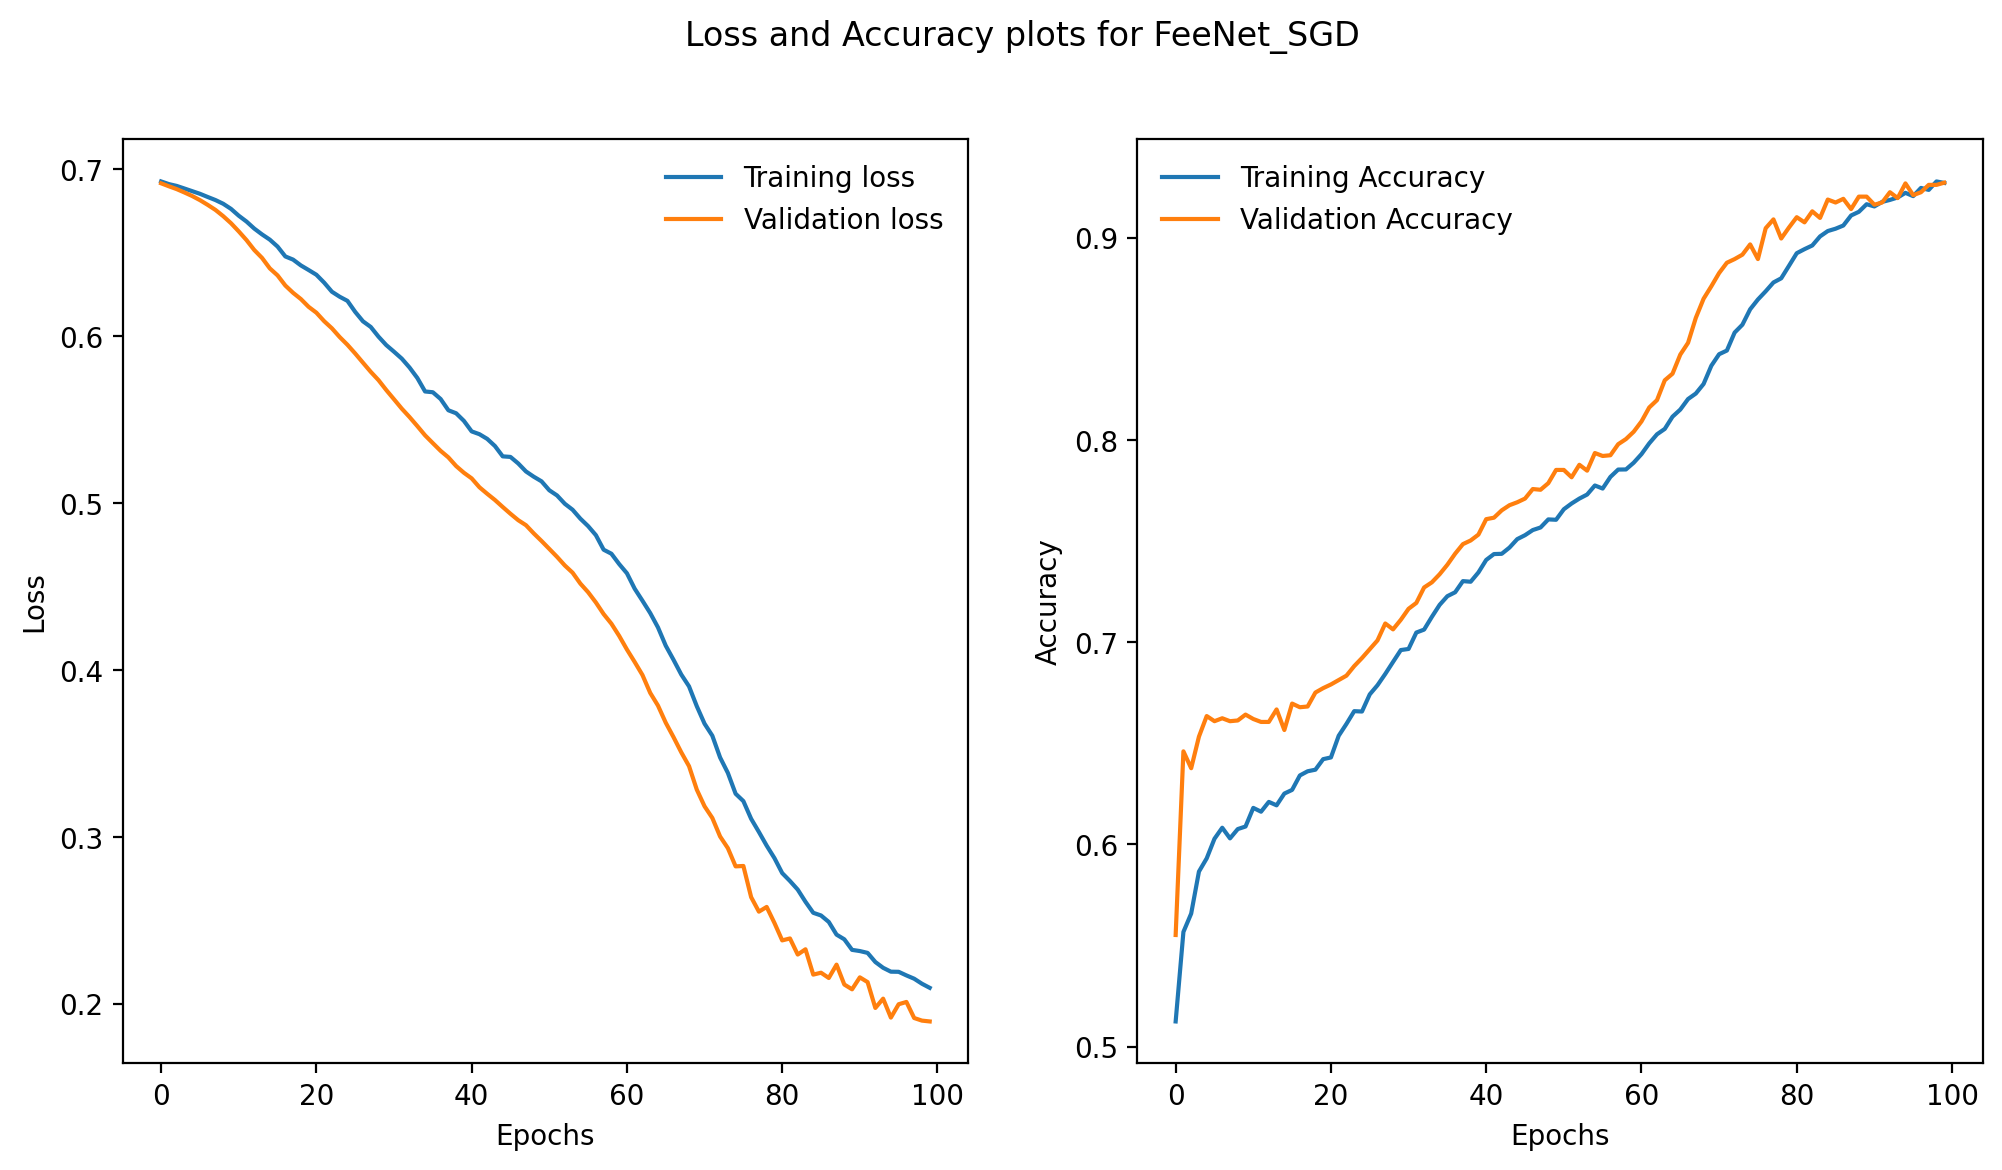

In [ ]:
plot_loss_acc('FeeNet_SGD', train_losses, valid_losses, train_accuracy, valid_accuracy)

  0%|          | 0/130 [00:00<?, ?it/s]

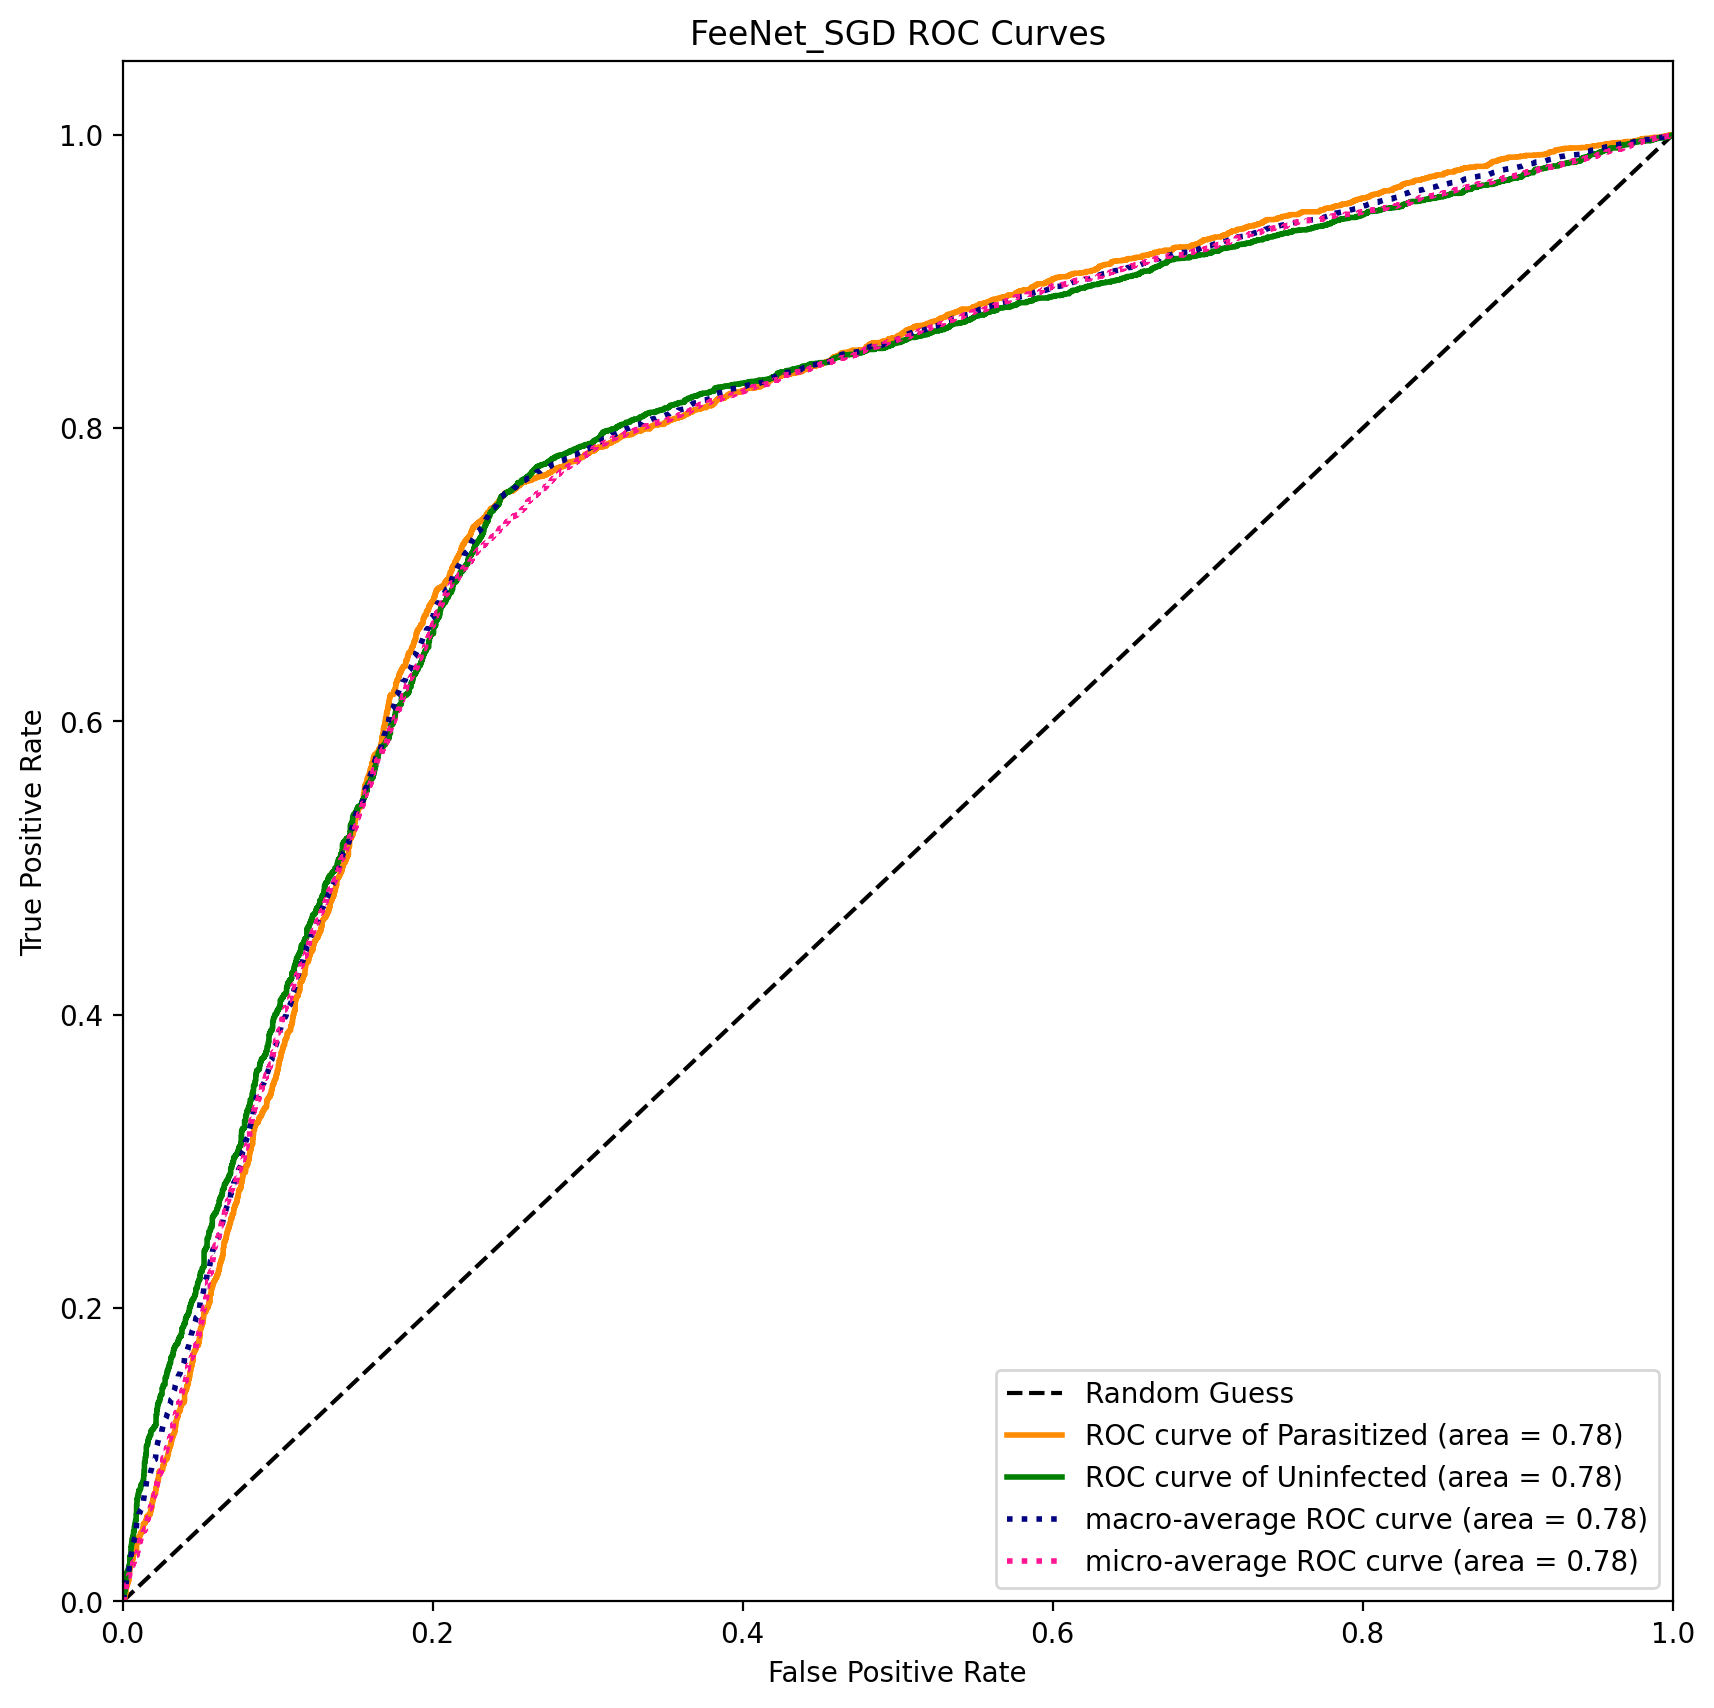

In [ ]:
feenet_model.load_state_dict(torch.load('FeeNet_SGD.pt'))
feenet_model.to(device)
images, labels, probs = get_predictions(feenet_model, test_iter)
images, labels = images.to(device), labels.to(device)

plot_roc_curve(y_test, probs, valid_ds.classes, "FeeNet_SGD")

              precision    recall  f1-score   support

 Parasitized       0.77      0.70      0.73      4133
  Uninfected       0.72      0.79      0.76      4133

    accuracy                           0.74      8266
   macro avg       0.75      0.74      0.74      8266
weighted avg       0.75      0.74      0.74      8266



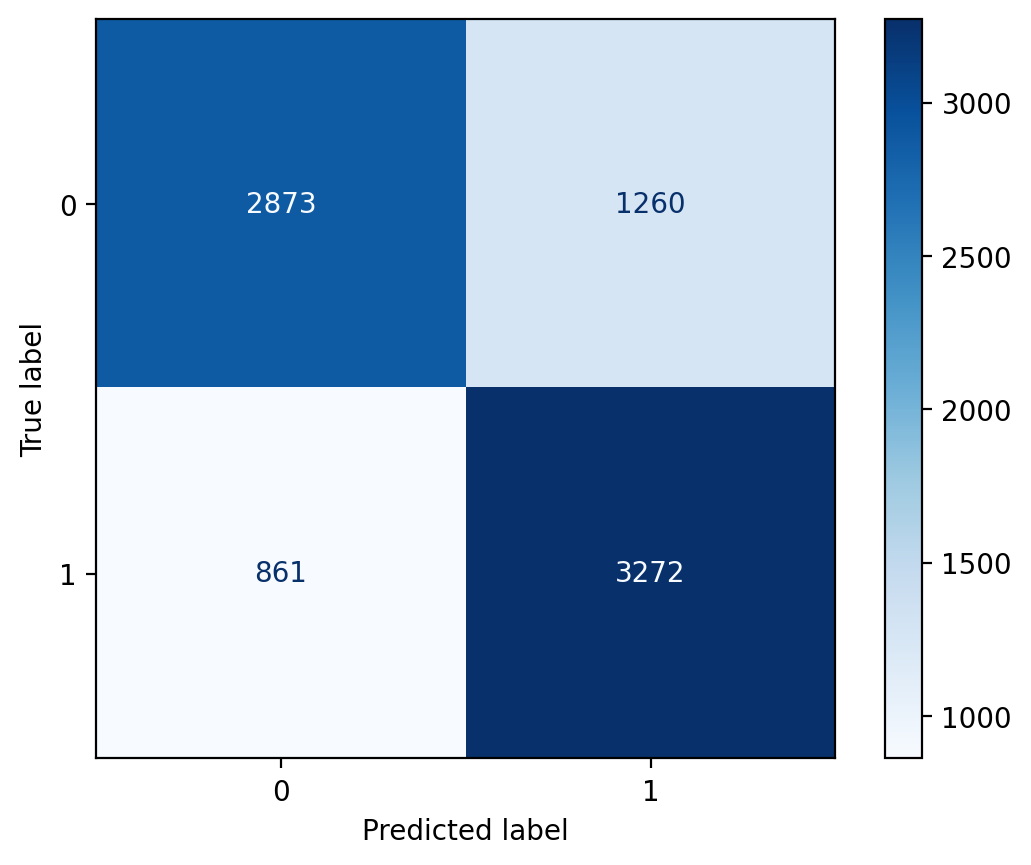

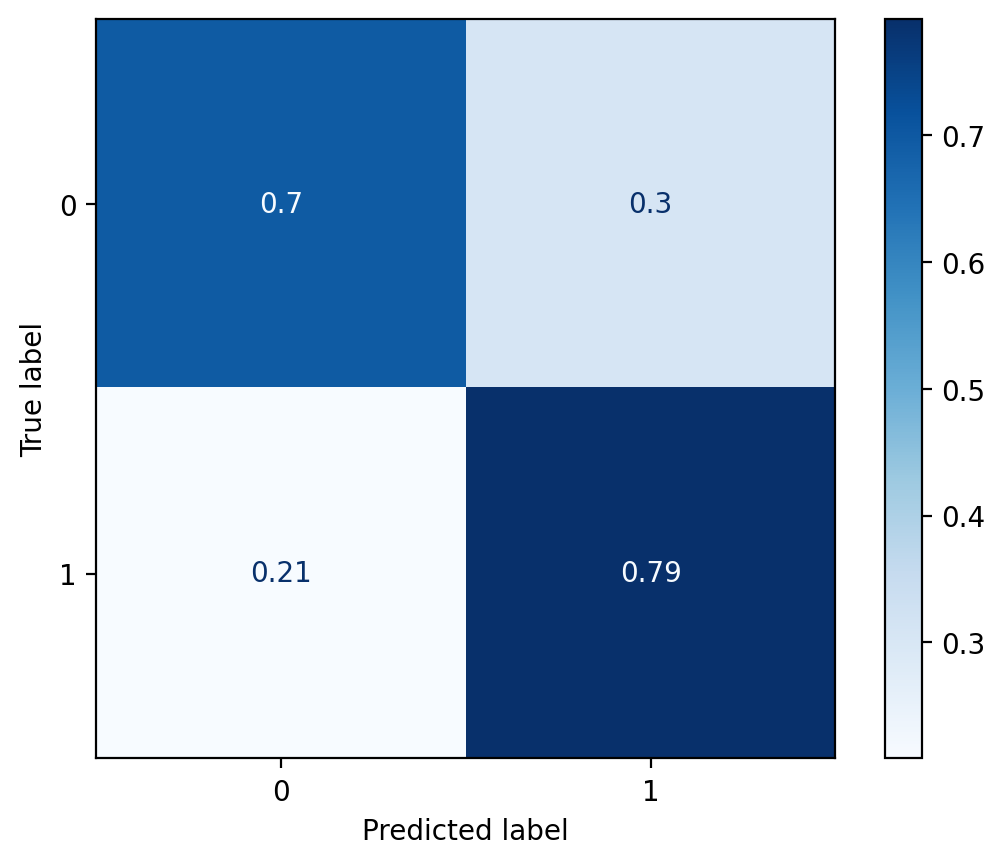

In [ ]:
plot_confusion_matrix(y_test, probs)